In [2]:
import codecs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import numdifftools

Load data

In [5]:
root = "../"
training_data_folder = '%straining_data/web-radio/output/rec' % root
embDir = '/Users/pasquale/git/music-embeddings'
what = 'artist'

uri_file = '%s/%s.emb.u' % (embDir, what)
vector_file = '%s/%s.emb.v' % (embDir, what)
header_file = '%s/%s.emb.h' % (embDir, what)
training_file = '%s/%s.dat' % (training_data_folder, what)

vectors = np.array([line.strip().split(' ') for line in codecs.open(vector_file, 'r', 'utf-8')])
heads = np.array([line.strip() for line in codecs.open(header_file, 'r', 'utf-8')])
uris = np.array([line.strip() for line in codecs.open(uri_file, 'r', 'utf-8')])

train_array = np.array([line.strip().split(' ') for line in codecs.open(training_file, 'r', 'utf-8')])
pd.DataFrame(train_array, columns=['seed', 'target', 'score']).head()


seed  \
0  http://data.doremus.org/artist/d33ebb23-7b8d-3...   
1  http://data.doremus.org/artist/01915146-b964-3...   
2  http://data.doremus.org/artist/01915146-b964-3...   
3  http://data.doremus.org/artist/72b3b303-5c15-3...   
4  http://data.doremus.org/artist/72b3b303-5c15-3...   

                                              target score  
0  http://data.doremus.org/artist/6329cd86-d47a-3...     1  
1  http://data.doremus.org/artist/6329cd86-d47a-3...     1  
2  http://data.doremus.org/artist/d33ebb23-7b8d-3...     1  
3  http://data.doremus.org/artist/6329cd86-d47a-3...     1  
4  http://data.doremus.org/artist/d33ebb23-7b8d-3...     1

In [ ]:
head_label = heads[0].split()
head_val = heads[1].split()
head_dim = []
for i in range(0, len(head_val)):
    for j in range(0, int(head_val[i])):
        head_dim.append(head_label[i])
        
# head_dim.append('fake')
# head_dim.append('fake')
# head_dim.append('fake')
head_dim

Data pre-processing: I want to substitute the seed and target with their embeddings

In [ ]:
def get_embs(x):
    # uri to embedding
    v = vectors[np.argwhere(uris == x)]
    if v.size == 0:
        result = -2. * np.ones(vectors[0].size)
    else:
        result = v[0][0]
    
#     result = np.concatenate((result,  [.12, .45, .73]))
    return result.astype('float32')

In [ ]:
col1 = np.array([get_embs(xi) for xi in train_array[:, 0]])
col2 = np.array([get_embs(xi) for xi in train_array[:, 1]])
col3 = np.array(train_array[:, 2]).astype('float32')
col3 = col3.reshape((col3.size, 1))

In [ ]:
emb_size = col1[0].size
emb_size

In [ ]:
training_vector = np.concatenate((col1, col2, col3), axis=1)
training_vector.shape

Split test and train

In [ ]:
train, test = train_test_split(training_vector, train_size=0.7)

train_vector = train[:, : -1]
train_label = train[:, -1]
train_label = train_label.reshape((len(train_label), 1))

test_vector = test[:, :-1]
test_label = test[:, -1]
test_label = test_label.reshape((len(test_label), 1))

In [4]:
print('Train')
print(train_vector.shape)
print(train_label.shape)
print('Test')
print(test_vector.shape)
print(test_label.shape)

Train


NameError: name 'train_vector' is not defined

Network

In [1033]:
def next_batch(num, data, labels):
    """
    Return a total of `num` random samples and labels. 
    """
    idx = np.arange(0, len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = data[idx]
    labels_shuffle = labels[idx]
    return data_shuffle, labels_shuffle

In [1034]:
def weighted_l2(a, b, w):
    # https://stackoverflow.com/a/8861999/1218213
    q = a - b
    return np.sqrt(np.sum(w * q * q, axis=1))

In [1035]:
def positive_norm(x):
    return preprocessing.normalize(np.abs(x), norm='l1')

def print_weights(w):
    y_pos = np.arange(len(w[0]))
    plt.barh(y_pos, w[0] * 100, align='center', alpha=0.5)
    plt.yticks(y_pos, head_dim)
    plt.xlabel("weights in %")
    plt.show()
    
def reset_weights():
    w = positive_norm(np.random.normal(size=[1, emb_size]))
    w = positive_norm(np.ones([1,emb_size]))
    return w

In [1095]:
# Parameters
learning_rate = 0.01
num_steps = 100000
batch_size = 1
display_step = 100

#epoch decay
l_rate_vec = np.ones((1,emb_size), np.float32) * learning_rate
decay_factor = 1. / num_steps

def l_rate(mask):
    global l_rate_vec
    decay = 1. / (1. + decay_factor )
    l_rate_vec *= np.where(mask, decay, 1. )
    return np.where(mask, l_rate_vec, l_rate_vec.mean() )

In [ ]:
_ones = np.ones((1,emb_size), np.float32)

def compute_penalty(expected, taken, total):
    return (expected - taken) / total


def compute_similarity_split(x, w):
    a, b = np.hsplit(x, 2)
    return compute_similarity(a, b, w)

def compute_similarity(seed, target, w):
    max_distance = weighted_l2(_ones, _ones * -1., _ones)
    
    bs = np.where(seed >= -1, 1, 0)
    bt = np.where(target >= -1, 1, 0)
    good_mask = np.logical_and(bs, bt)
    good_count = np.count_nonzero(good_mask, axis=1)
    

    _seed = np.where(good_mask, seed, 0.)
    _target = np.where(good_mask, target, 0.)
    
    # distance
    d = weighted_l2(_seed, _target, w)

    # how much info I am not finding
    penalty = compute_penalty(np.count_nonzero(bs, axis=1), good_count, emb_size)

    # score
    s = (max_distance - d) / max_distance
    
    return s * (1 - penalty), good_mask

Training

In [1097]:
def dE_dW(x, w, pred, l, mask):
    a, b = np.hsplit(x, 2)
    q = a - b
    q2 = w * q * q
    dd_dW = .5 / (q2 + 10 ** - 2)
    
    ds_dW = - dd_dW / max_distance
    de_dW = ds_dW * (pred - l) * 2 / batch_size
    return np.where(mask, de_dW, de_dW.mean())

ERR: 0.6088078686208297


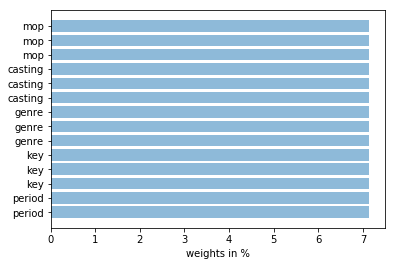

ERR: 0.00011038032535427889


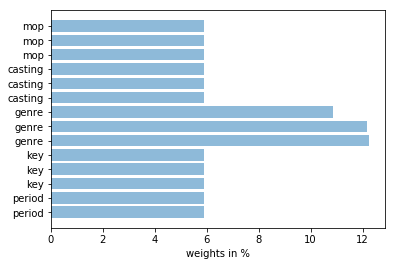

ERR: 0.33284198008172616


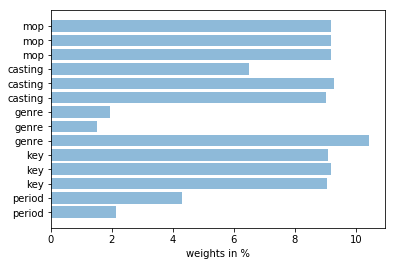

ERR: 6.059381828407032e-05


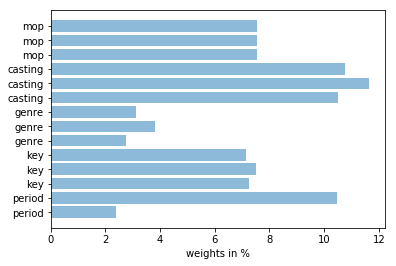

ERR: 1.5786837222483745e-05


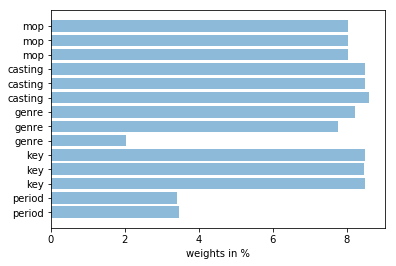

ERR: 0.18715228591336608


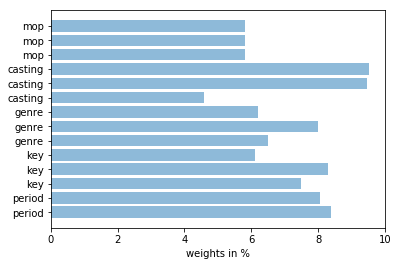

ERR: 0.18684297920637796


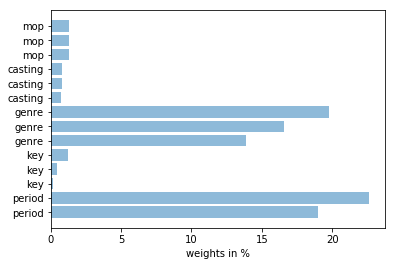

ERR: 4.8193494000487825e-05


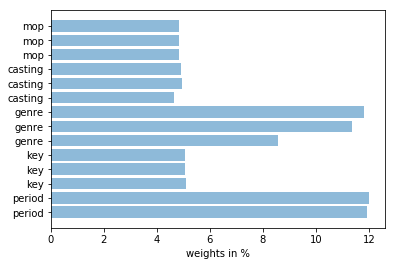

ERR: 0.05091628723512313


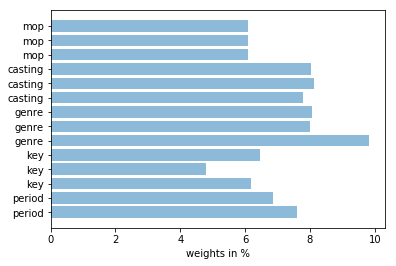

ERR: 1.758978478655424e-05


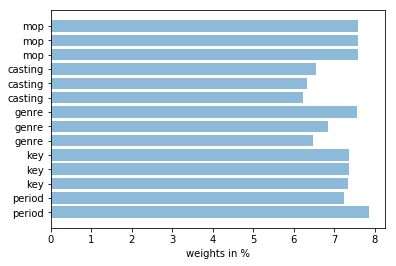

ERR: 3.8637246706169656e-05


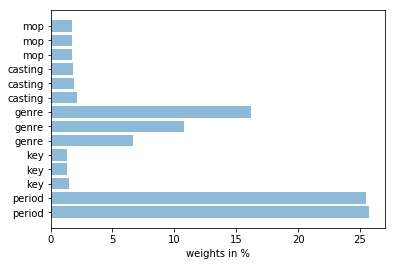

ERR: 1.9321560160332714e-05


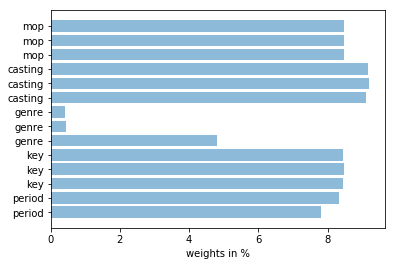

ERR: 0.0001198455802372399


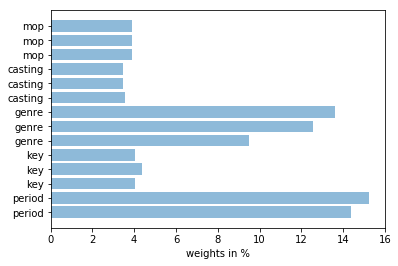

ERR: 0.00012718596519714184


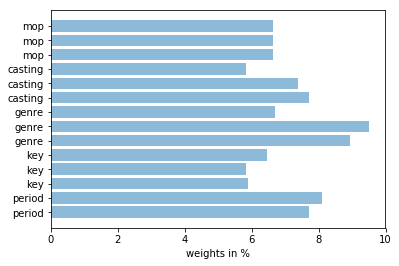

ERR: 0.0004811217577799546


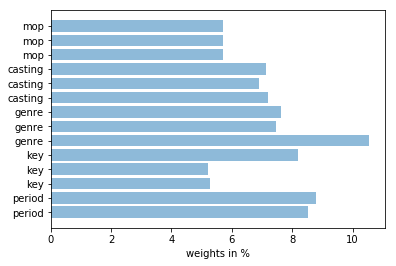

ERR: 1.6496218649151145e-05


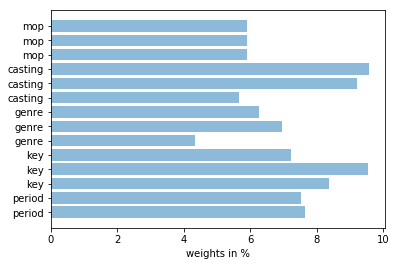

ERR: 0.005313336644158112


ERR: 5.394963942501321e-05


ERR: 0.33201729090428916


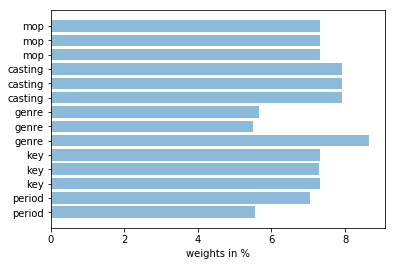

ERR: 5.768483064861995e-05


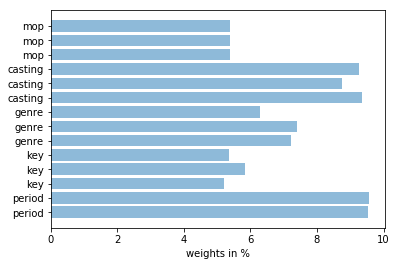

ERR: 0.00014218914478327814


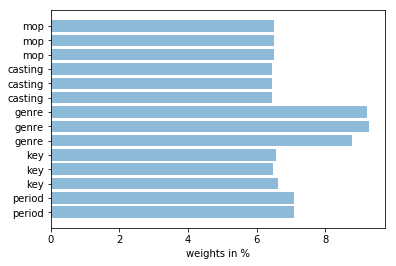

ERR: 0.00015808620729044587


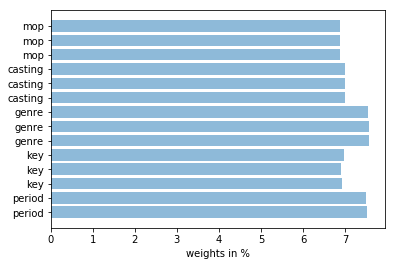

ERR: 0.5102040816326531


ERR: 0.08370449901343878


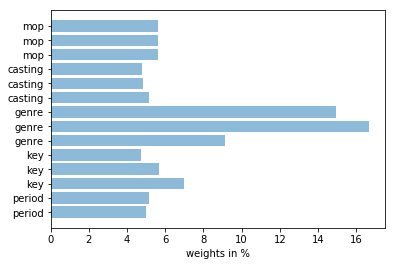

ERR: 0.00047558508610902827


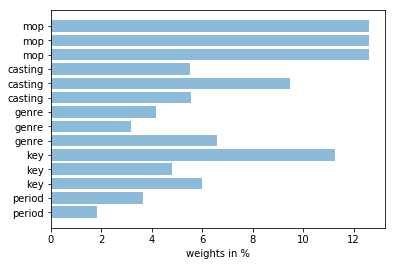

ERR: 3.305780316288789e-05


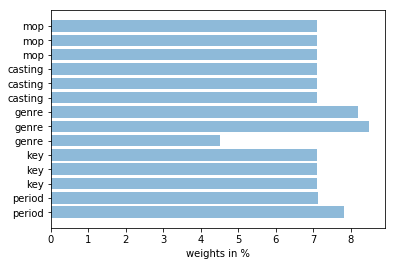

ERR: 0.4892902874820747


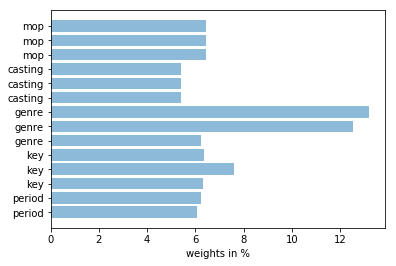

ERR: 6.385802218695131e-06


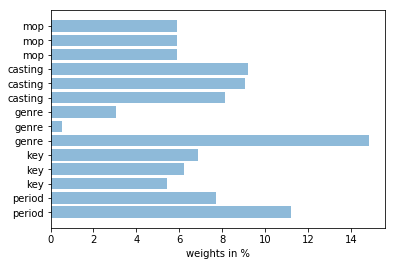

ERR: 0.045918367346938785


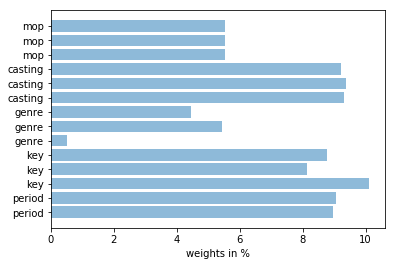

ERR: 6.365953618423107e-05


ERR: 0.00018369043494912565


ERR: 0.00021417977420152775


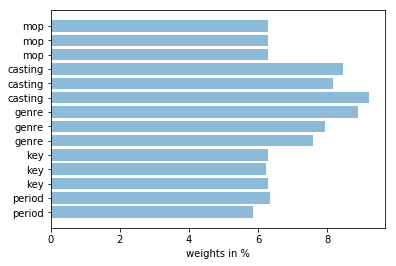

ERR: 0.00014333288698561555


ERR: 0.1874955107209576


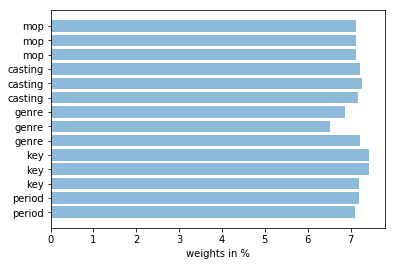

ERR: 3.572784173428277e-05


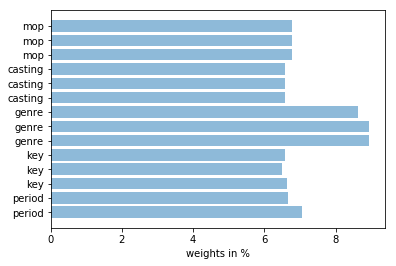

ERR: 0.4160164397199346


ERR: 0.04753605220931614


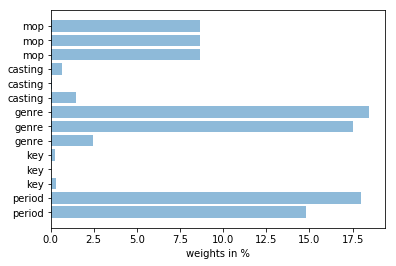

ERR: 0.18164652480019827


ERR: 0.0001171804379208852


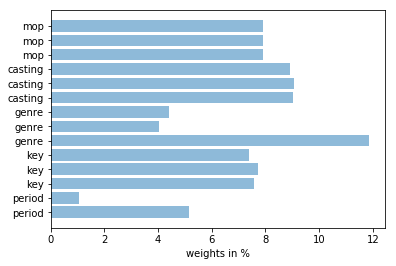

ERR: 0.0486281680166334


ERR: 0.00039182383053173444


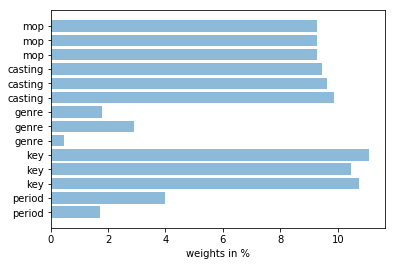

ERR: 0.08359864820086907


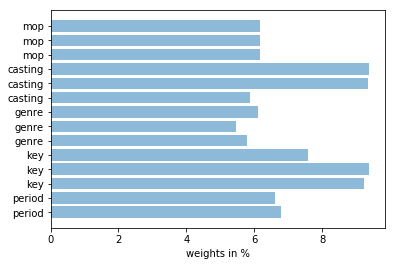

ERR: 0.000583802442933287


ERR: 0.051253295176767924


ERR: 4.6454584506143186e-05


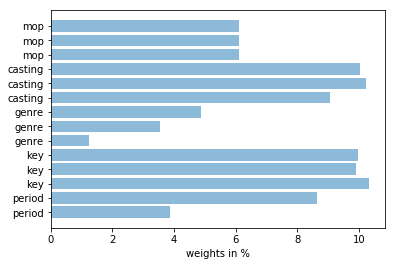

ERR: 1.948000624841536e-05


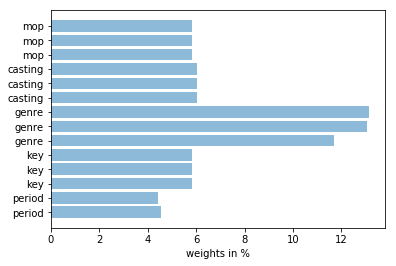

ERR: 3.805394205065481e-05


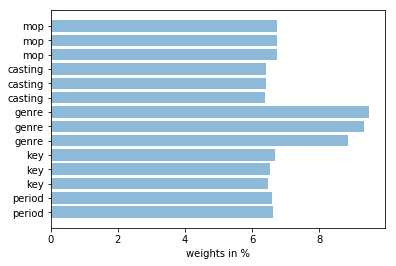

ERR: 0.0003676387856069049


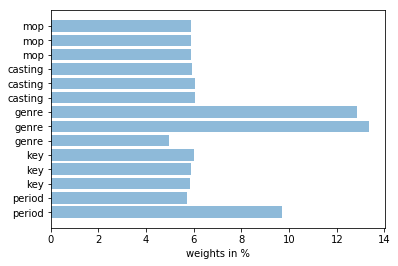

ERR: 0.0003901346593423864


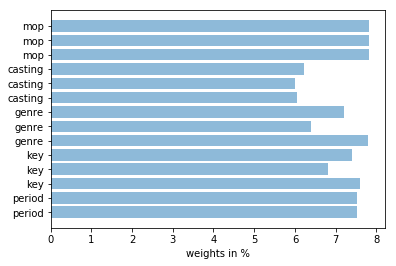

ERR: 1.1114845274578868e-05


ERR: 0.0002434812727922407


ERR: 0.0002564590339167267


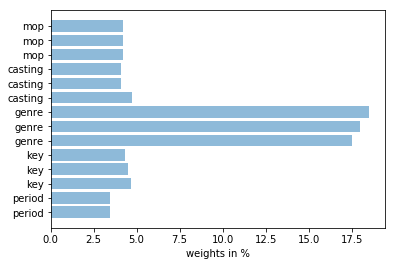

ERR: 4.528268208342298e-06


ERR: 0.0


ERR: 0.050711963478797605


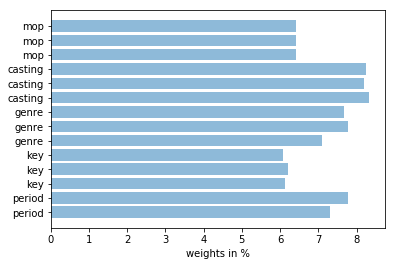

ERR: 2.2853625269718573e-05


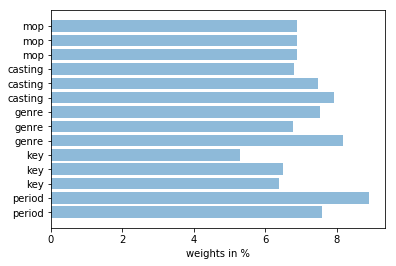

ERR: 0.0002514102807988772


ERR: 4.9079565215093366e-05


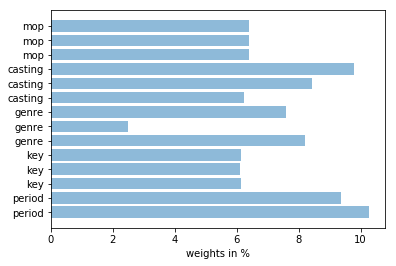

ERR: 0.1347575817608512


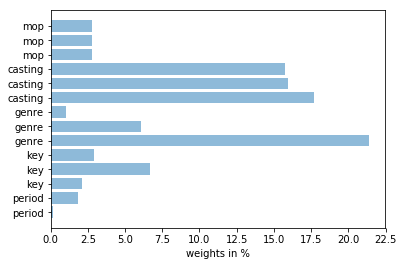

ERR: 0.19217473752112257


ERR: 0.33138596081459404


ERR: 0.00010879006630997782


ERR: 5.3845497407511254e-05


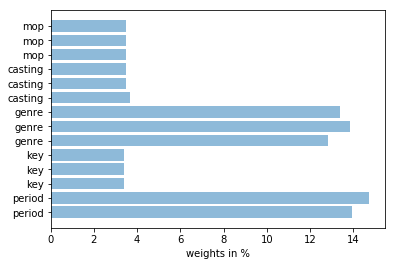

ERR: 9.27436040436283e-05


ERR: 0.9954445968418356


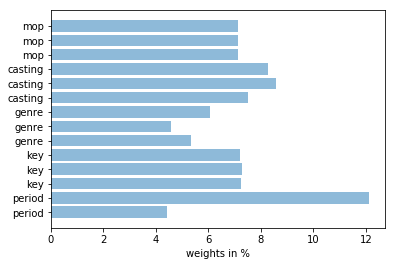

ERR: 0.047304707176169775


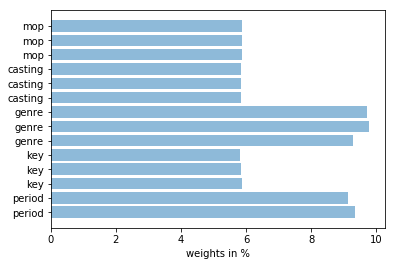

ERR: 0.19096900836099143


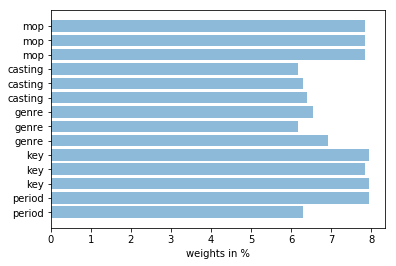

ERR: 2.0513458917329273e-05


ERR: 4.8426646161660494e-05


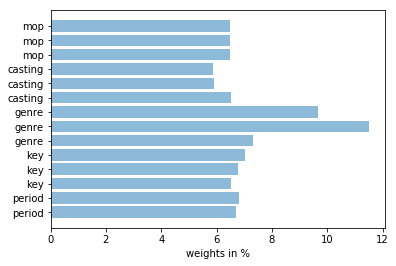

ERR: 1.8772026191804113e-05


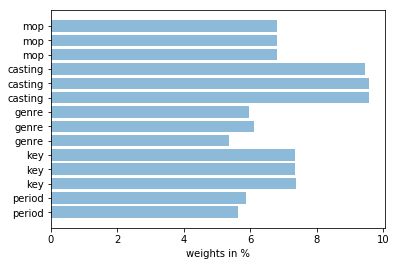

ERR: 1.1560378180185819e-05


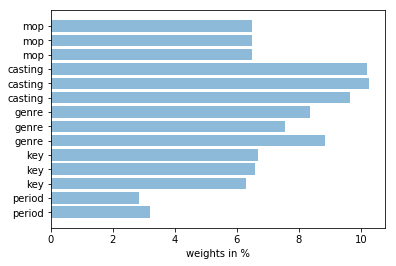

ERR: 0.05339848774964001


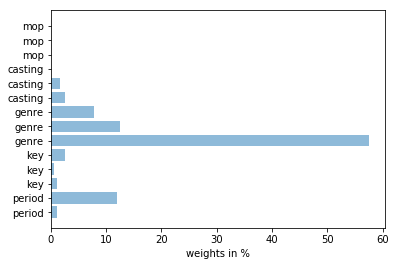

ERR: 5.046243422530918e-05


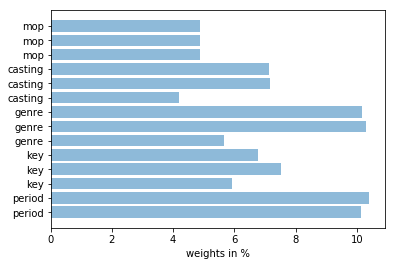

ERR: 0.0


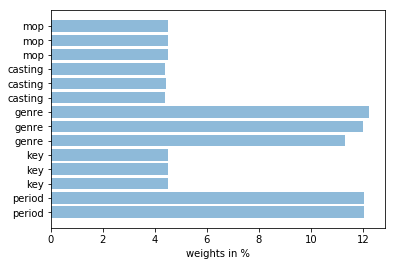

ERR: 0.047073238307057966


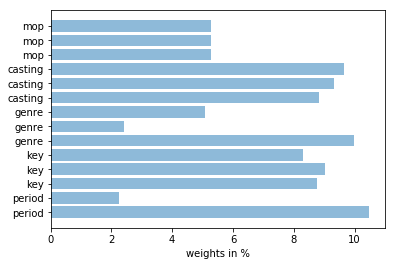

ERR: 0.087289576599627


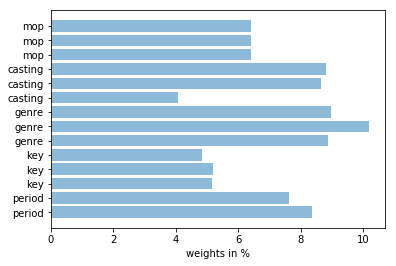

ERR: 0.25


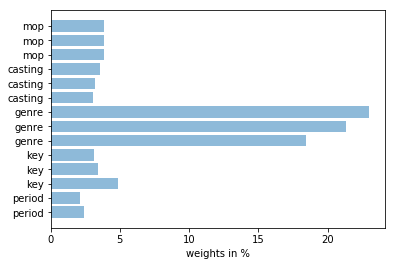

ERR: 2.7701662850778937e-06


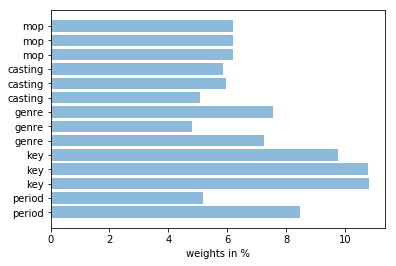

ERR: 0.006337950920046864


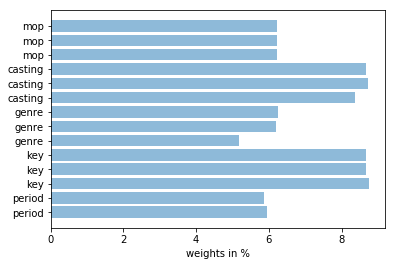

ERR: 9.676346232649747e-05


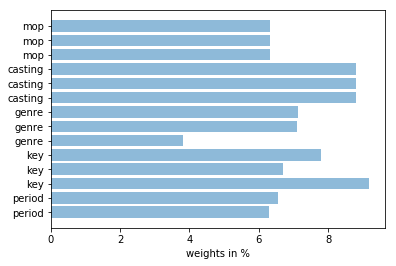

ERR: 2.082460718060287e-05


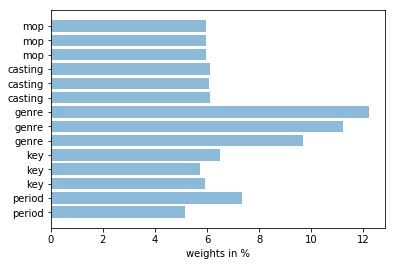

ERR: 0.04916036069588373


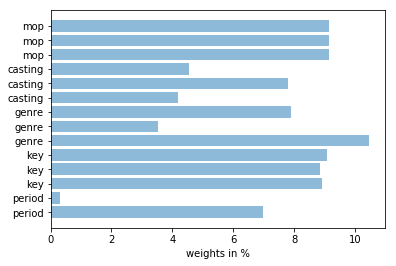

ERR: 0.41599039997398335


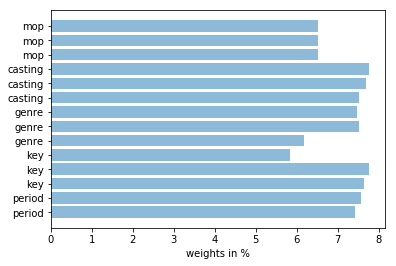

ERR: 0.00011563360999645258


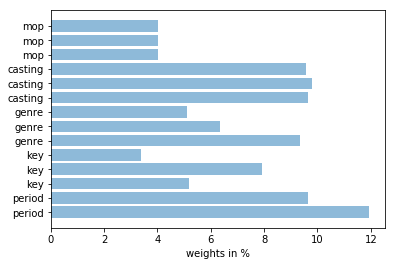

ERR: 8.19377278050087e-05


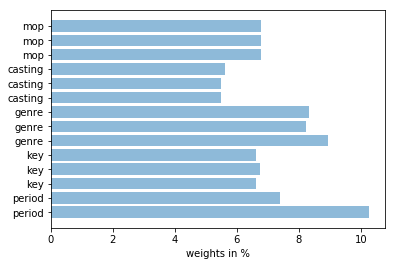

ERR: 0.00014278366468066143


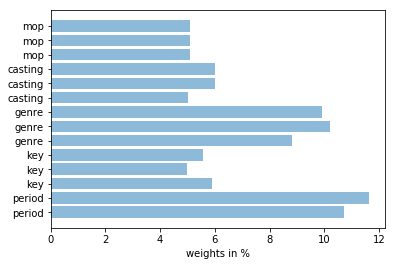

ERR: 0.0002469868670807236


ERR: 5.699598386888103e-07


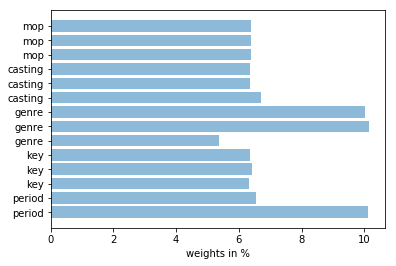

ERR: 0.04894875548504824


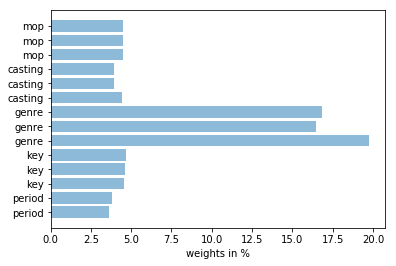

ERR: 5.063372140130778e-05


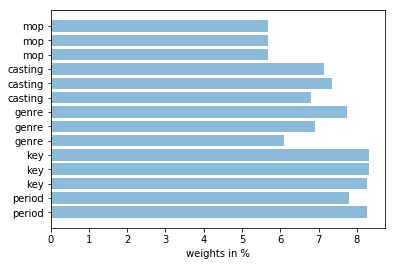

ERR: 0.5965315062788827


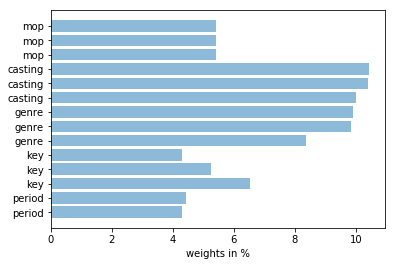

ERR: 3.11840337156624e-05


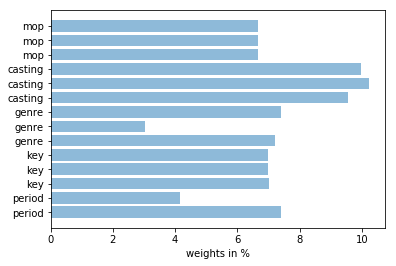

ERR: 7.111534422703082e-05


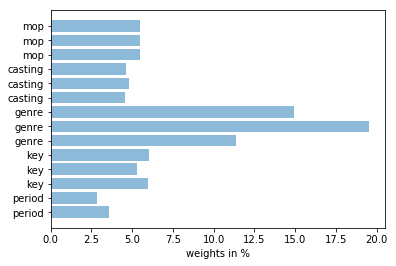

ERR: 0.6188569039723599


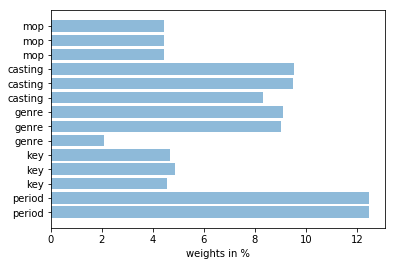

ERR: 0.006094930925795202


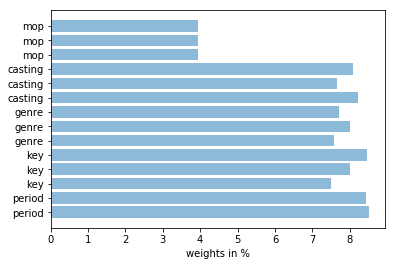

ERR: 0.6173469387755102


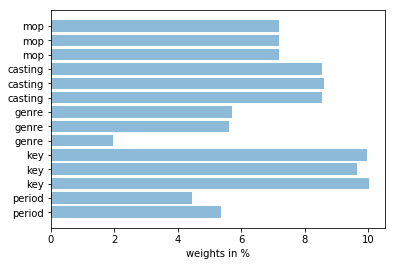

ERR: 0.005832137394921401


ERR: 0.00016719122297685816


ERR: 0.9708013388491514


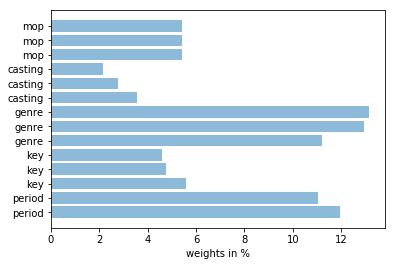

ERR: 4.9744938885785304e-05


ERR: 0.00010907935061676952


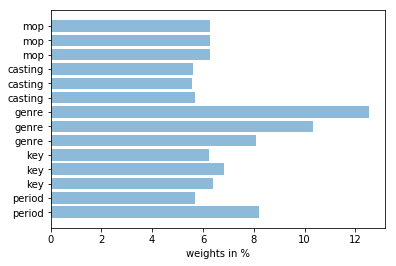

ERR: 0.0003793671781129262


ERR: 9.456544031528723e-05


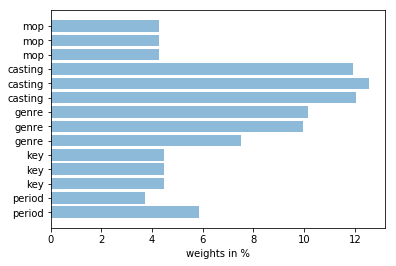

ERR: 0.13303311333552165


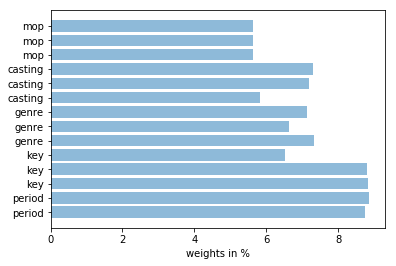

ERR: 0.5102040816326531


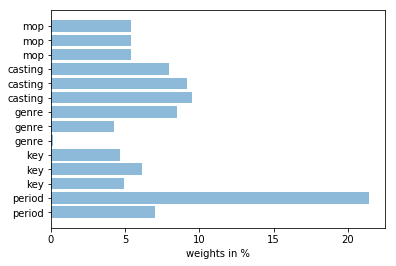

ERR: 0.00622092285724541


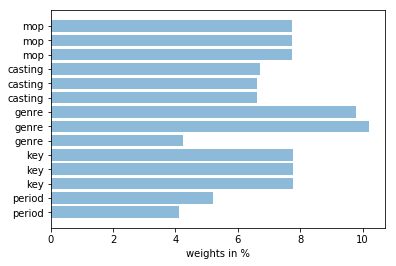

ERR: 4.936393659894951e-05


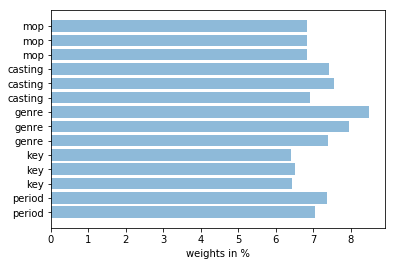

ERR: 3.31856293396e-05


ERR: 4.175108656781346e-05


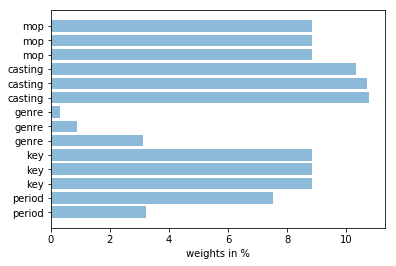

ERR: 0.04872928261171373


ERR: 0.18635128966533207


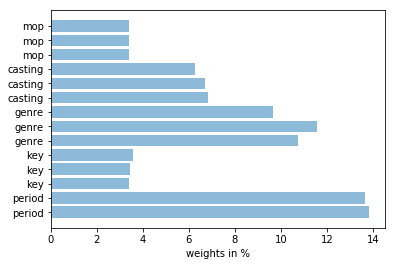

ERR: 0.0001129000687006768


ERR: 3.122382789574507e-05


ERR: 0.6180266304441765


ERR: 0.00016974679988434802


ERR: 1.1503977563865917e-05


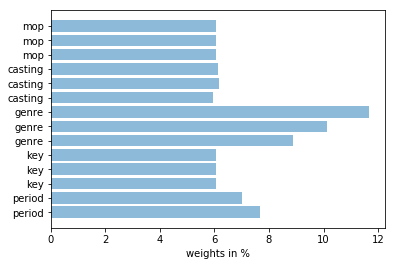

ERR: 0.19692393904682373


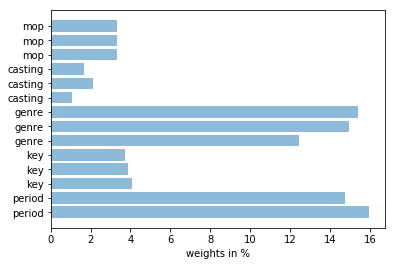

ERR: 0.0001033255432304985


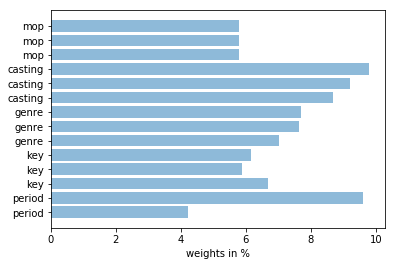

ERR: 0.049608953596923806


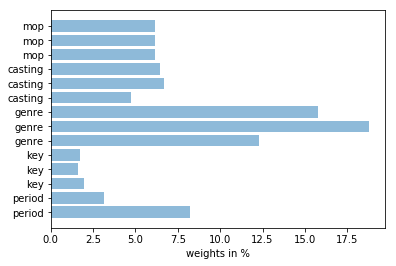

ERR: 0.19016825267679022


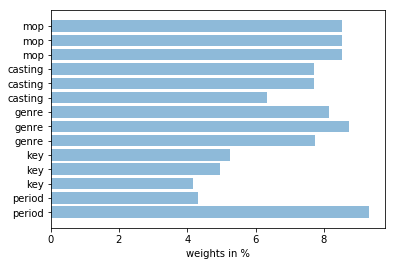

ERR: 0.00015990316283760525


ERR: 0.0492562017828893


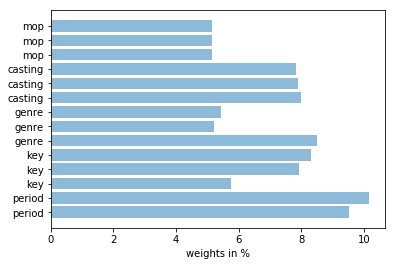

ERR: 0.9872848887612038


ERR: 0.08362268317092267


ERR: 0.04681917801396871


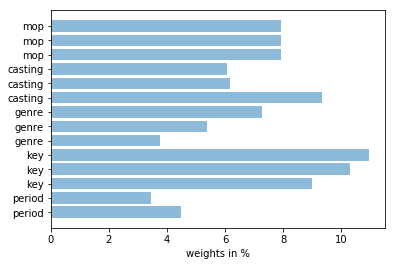

ERR: 0.1889723444020103


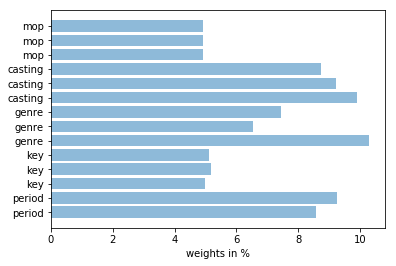

ERR: 0.08163265306122448


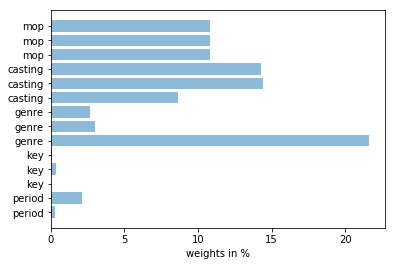

ERR: 0.00013609659623921218


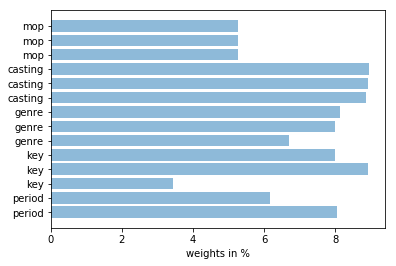

ERR: 3.26940927873133e-05


ERR: 3.77975114997788e-05


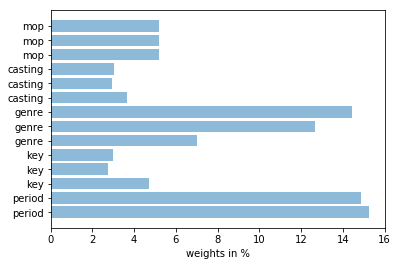

ERR: 2.147861773603816e-05


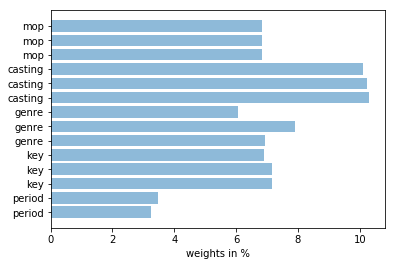

ERR: 0.04689556970295289


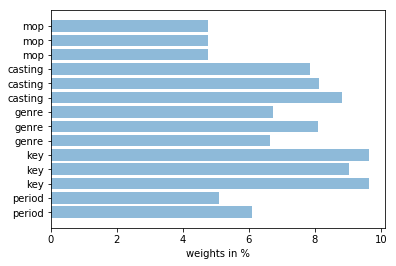

ERR: 4.140236535017492e-05


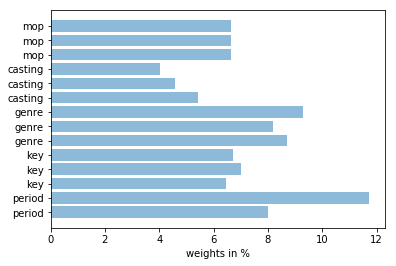

ERR: 0.049502498825071455


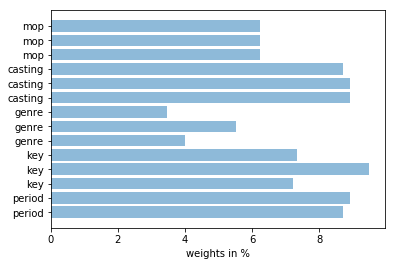

ERR: 0.008084508787840715


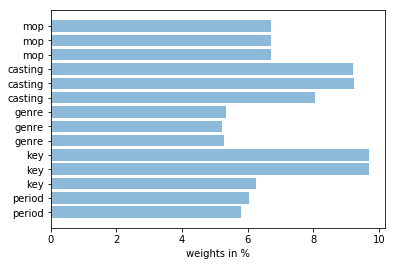

ERR: 0.33321543039488943


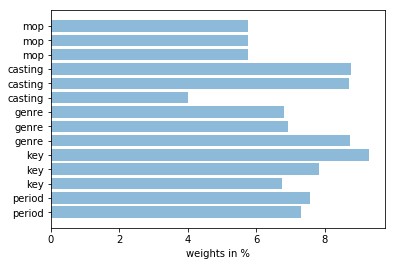

ERR: 0.04926457428990711


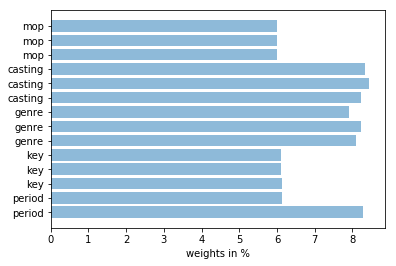

ERR: 8.635877993989026e-05


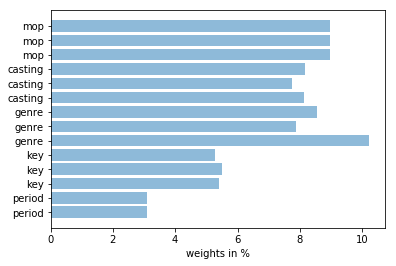

ERR: 1.0


ERR: 5.079884564815981e-05


ERR: 0.006455900001629441


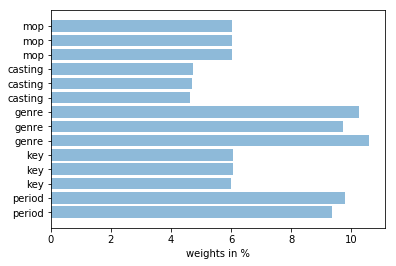

ERR: 3.8612237259245185e-05


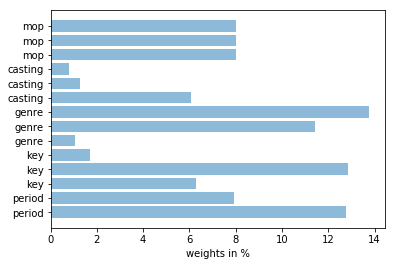

ERR: 0.00020134141069282944


ERR: 7.707583278595755e-05


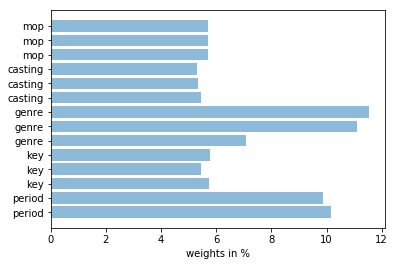

ERR: 0.048588511323571594


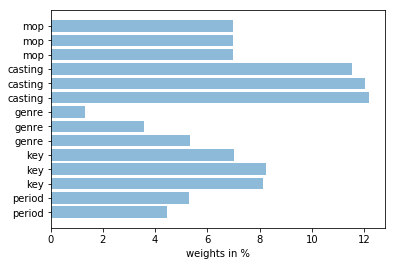

ERR: 0.00021437419044976873


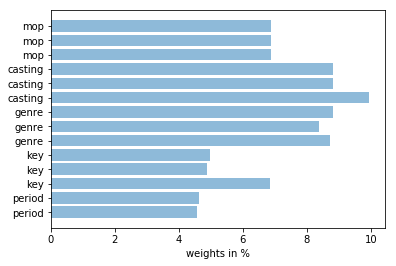

ERR: 5.745864772396818e-06


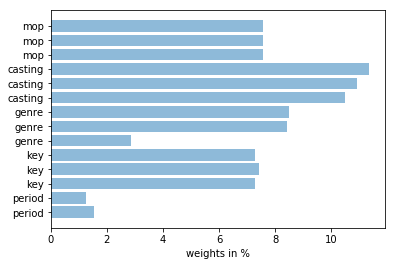

ERR: 0.0001789737590289675


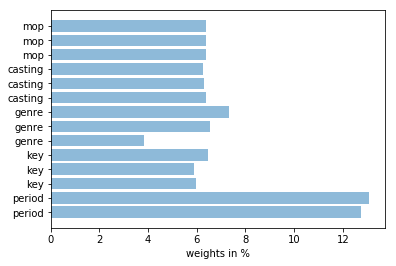

ERR: 0.04969326176313169


ERR: 0.00016147225249645933


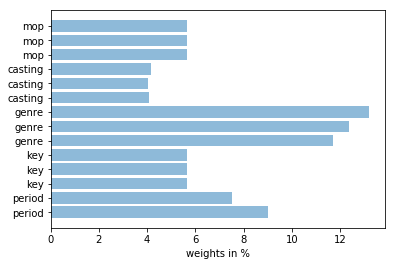

ERR: 0.0863806083222736


ERR: 0.00021475043232431964


ERR: 0.0001080382015304097


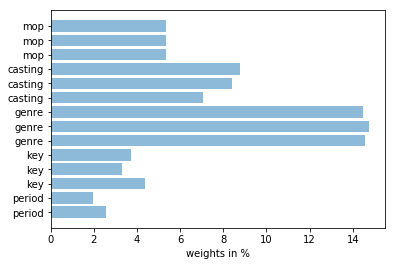

ERR: 0.00010474030082077613


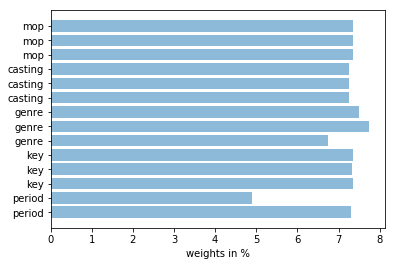

ERR: 2.2531309044141042e-05


ERR: 0.00016574695074194566


ERR: 0.0


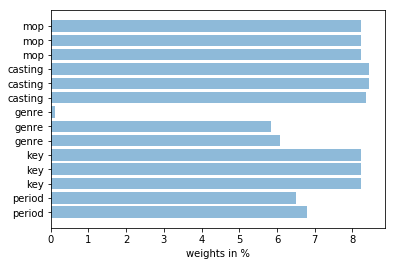

ERR: 1.818219055623258e-05


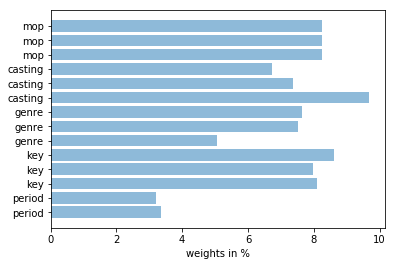

ERR: 0.00016691712404571618


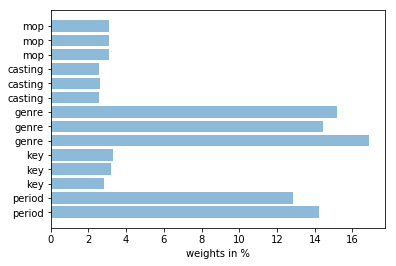

ERR: 0.00010784123696606286


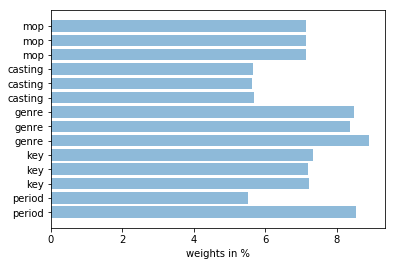

ERR: 0.00025065916220020056


ERR: 0.18522101607451416


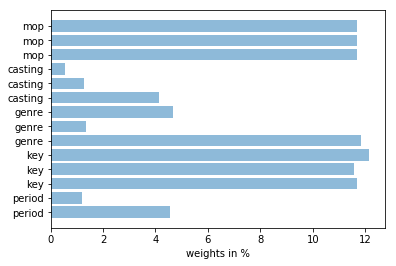

ERR: 0.18920644201494224


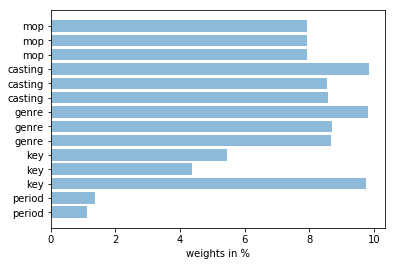

ERR: 0.9990045838611066


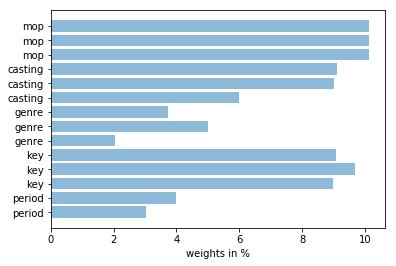

ERR: 0.00035332619014386815


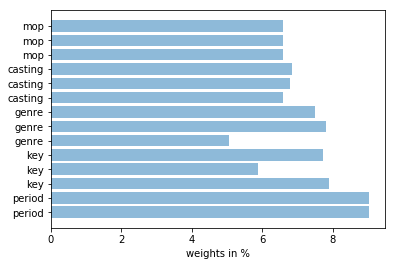

ERR: 3.548766473941639e-05


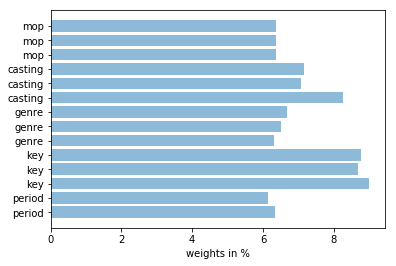

ERR: 0.0


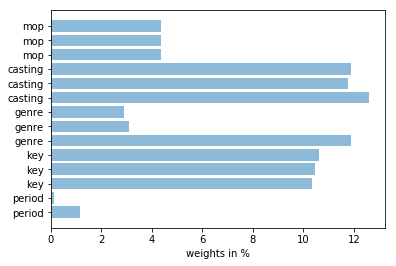

ERR: 0.6173469387755102


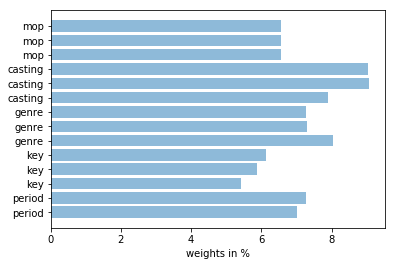

ERR: 0.050960668550992495


ERR: 2.403389576789776e-05


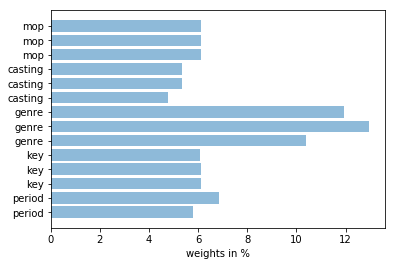

ERR: 0.0846690709151012


ERR: 0.0003741628465848178


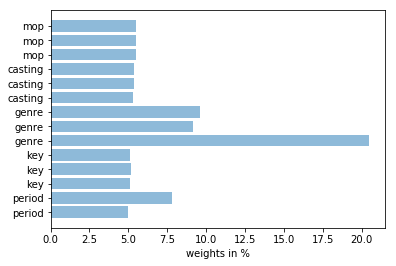

ERR: 0.6186044908738382


ERR: 0.9683572304578661


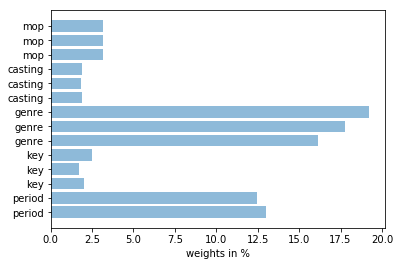

ERR: 0.19021001323291425


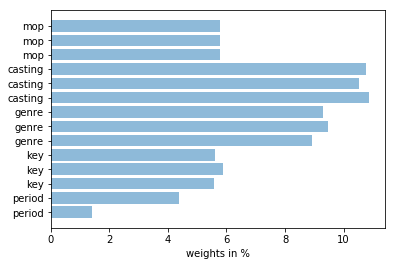

ERR: 0.00016845908589971606


ERR: 0.0001494258258727283


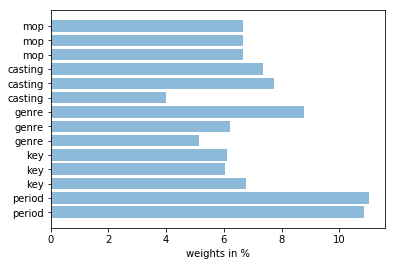

ERR: 0.00013431741942650206


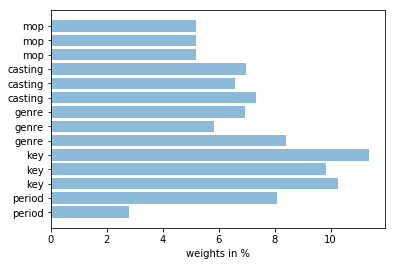

ERR: 0.0003247135077169309


ERR: 0.0


ERR: 0.0003564206155308376


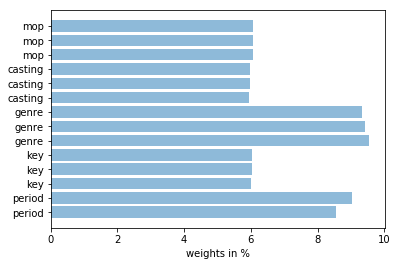

ERR: 0.18615103039409736


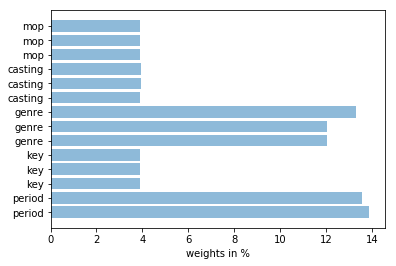

ERR: 0.18609709515188813


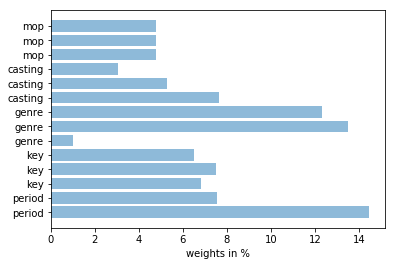

ERR: 0.00011254111567293344


ERR: 0.00014025793200464032


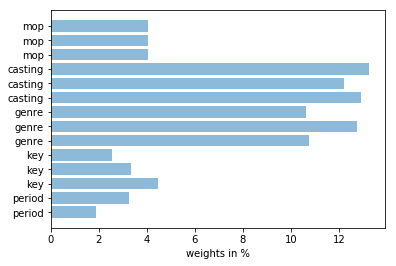

ERR: 0.006434442209563593


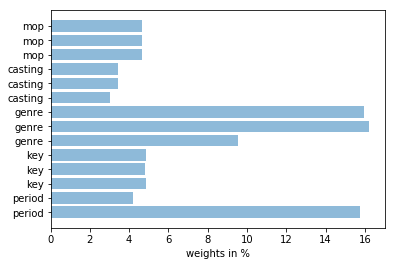

ERR: 0.08563806823477944


ERR: 2.2152542177823478e-05


ERR: 0.9914842426698623


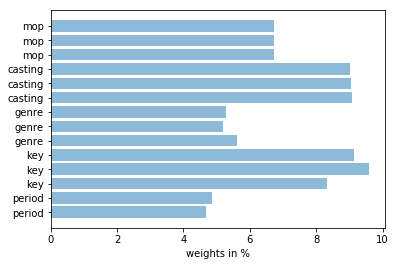

ERR: 0.005764089962212383


ERR: 7.588631945084781e-05


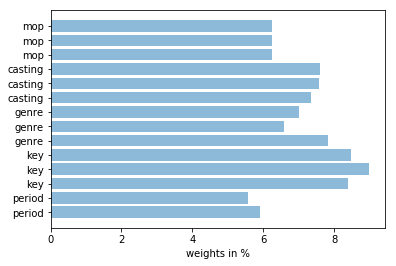

ERR: 0.00017717218306920277


ERR: 0.0002741585406843449


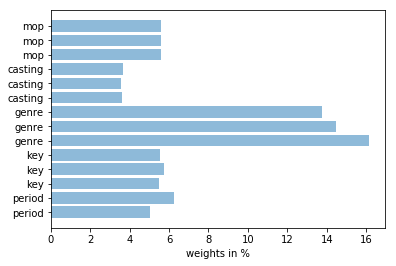

ERR: 0.000280160432352046


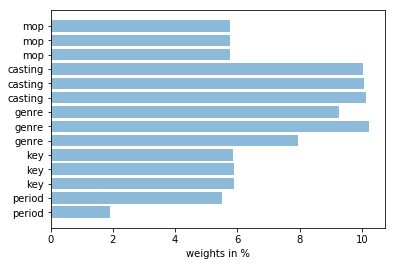

ERR: 5.4676152627813996e-05


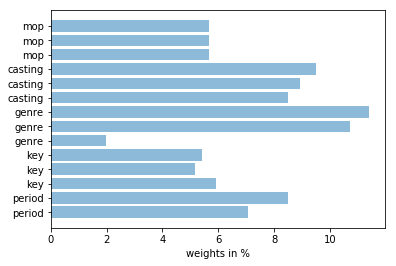

ERR: 3.2998159091504684e-06


ERR: 0.00012252152077336207


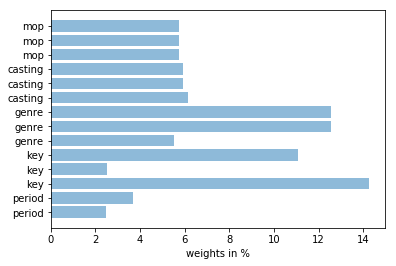

ERR: 0.05133362256190788


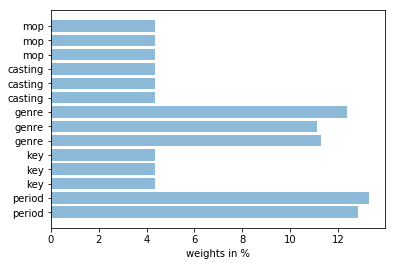

ERR: 0.9958526542391674


ERR: 0.04976740056298581


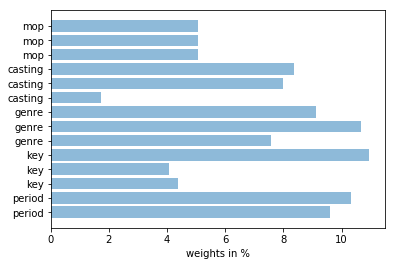

ERR: 0.000259198925974217


ERR: 0.006304377170221173


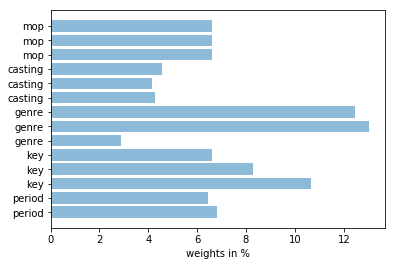

ERR: 9.007751635072292e-05


ERR: 0.18966462573008697


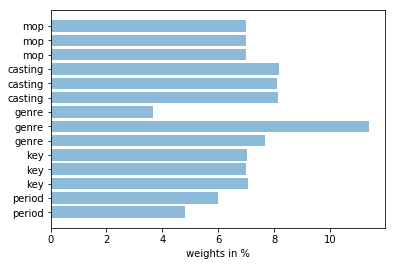

ERR: 0.04834731610706369


ERR: 6.220498755525098e-05


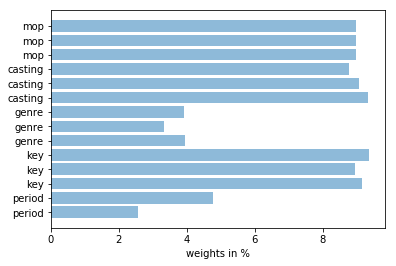

ERR: 8.456856635009336e-05


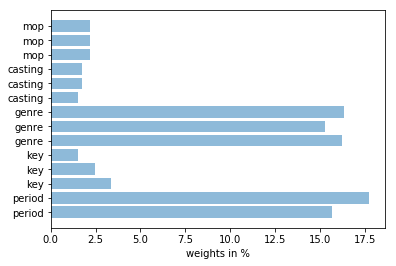

ERR: 0.0002687189870407866


ERR: 0.0001612492317358465


ERR: 6.093365425633792e-05


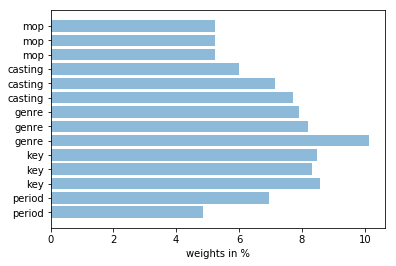

ERR: 0.047787305648630714


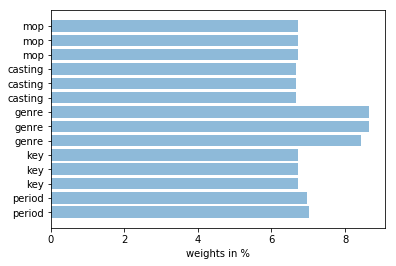

ERR: 2.0677439745367938e-06


ERR: 4.040784814583625e-05


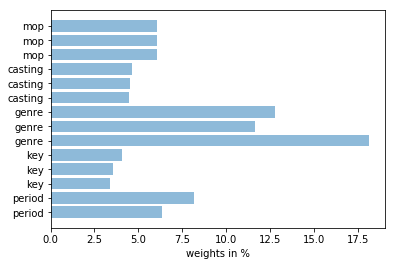

ERR: 0.04822930244594297


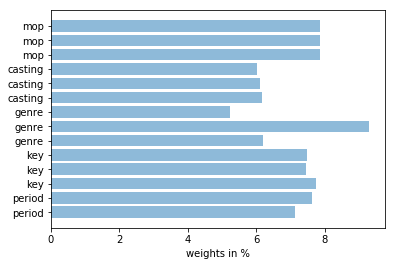

ERR: 0.04843813983961952


ERR: 0.9734612412499626


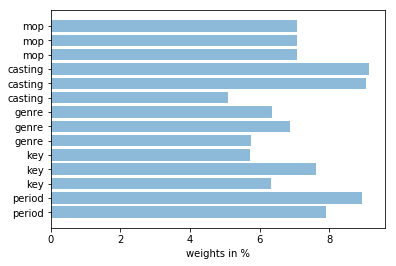

ERR: 1.9371621500470034e-05


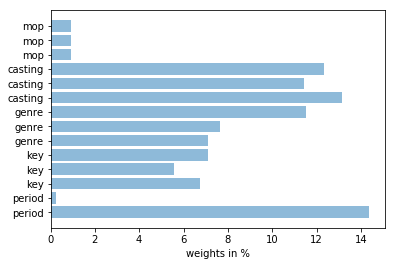

ERR: 0.00021423739985497616


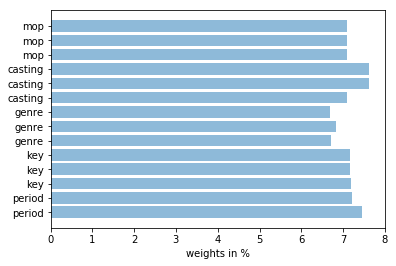

ERR: 5.740116098277496e-05


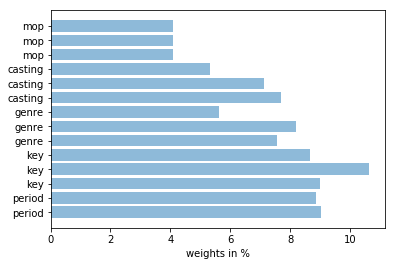

ERR: 9.63073724352531e-05


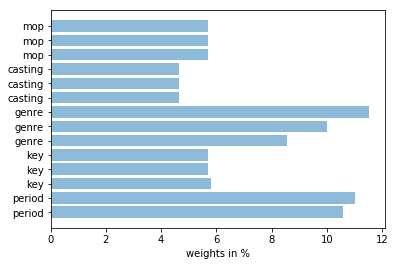

ERR: 3.848745023005086e-05


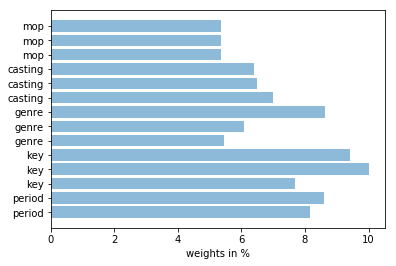

ERR: 0.0001794259577036362


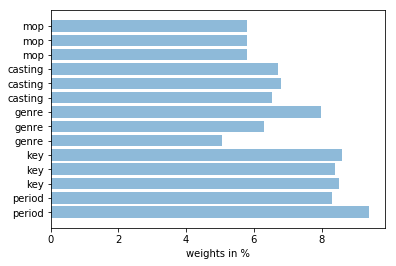

ERR: 0.04680610139725167


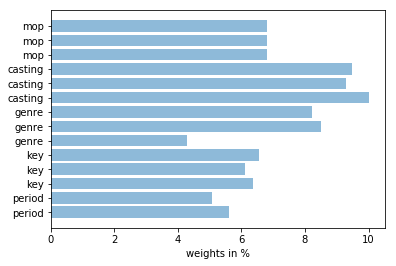

ERR: 0.0001453480006164349


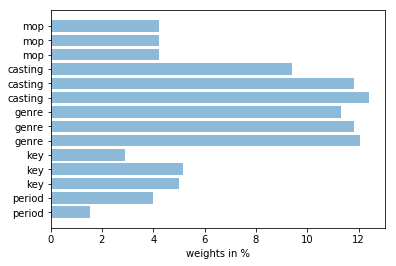

ERR: 0.05159261446109955


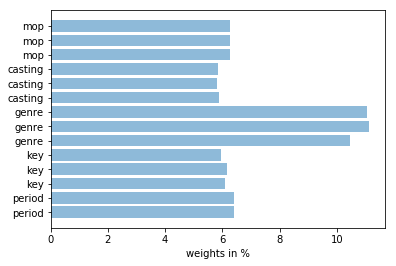

ERR: 0.050198087886060144


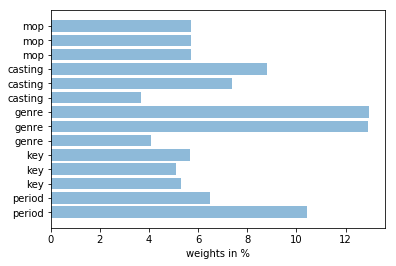

ERR: 0.00026754547641437567


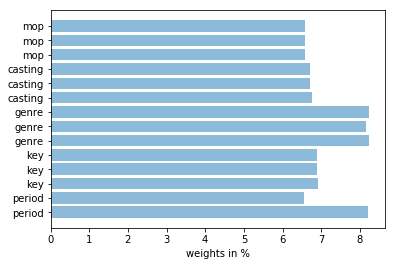

ERR: 3.3123687625118684e-05


ERR: 0.05154608946942237


ERR: 0.04754868548788721


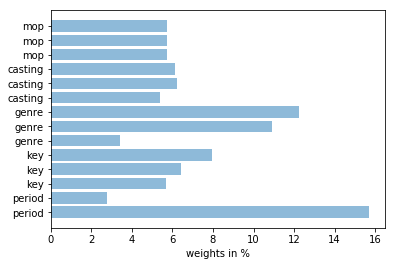

ERR: 0.047652407424767146


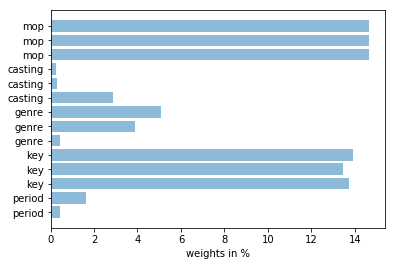

ERR: 6.029665052832544e-05


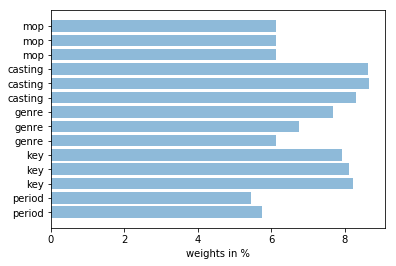

ERR: 2.5687027457464006e-05


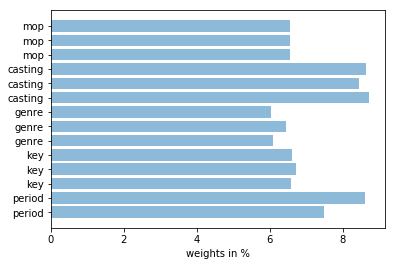

ERR: 2.6485981401336257e-05


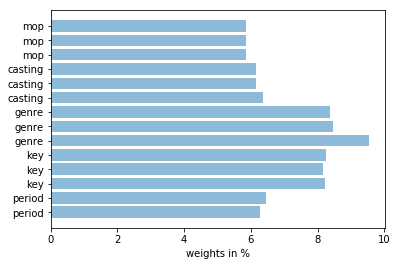

ERR: 3.3151908518529897e-06


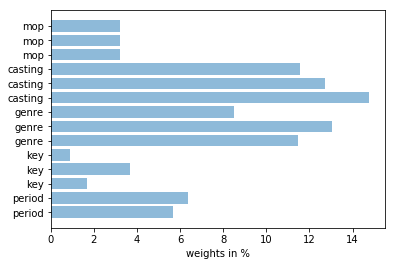

ERR: 0.048418673087774776


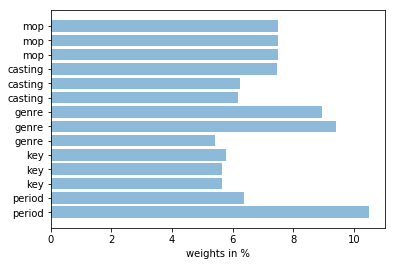

ERR: 0.0478979622435248


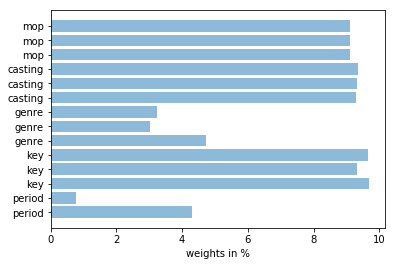

ERR: 0.6112813400446283


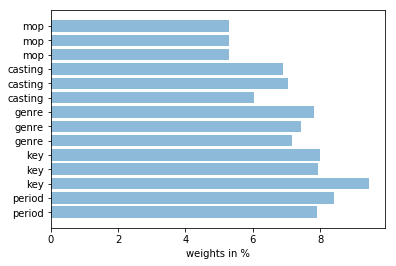

ERR: 0.9776633203113025


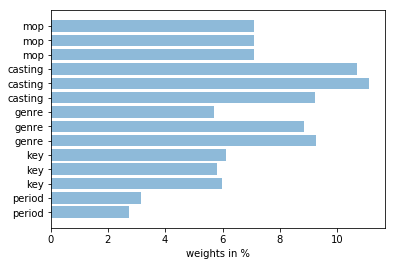

ERR: 8.763367009103376e-06


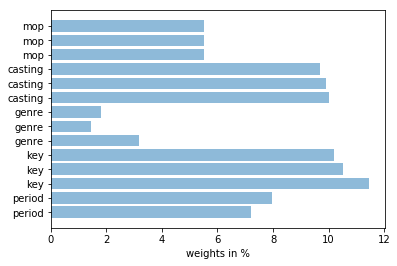

ERR: 1.979129386372504e-05


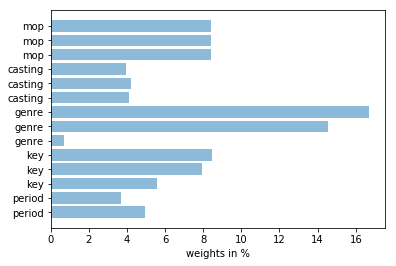

ERR: 0.32789920782755927


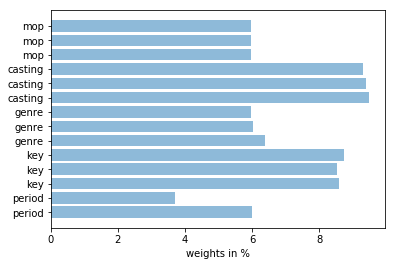

ERR: 2.8633394051769783e-05


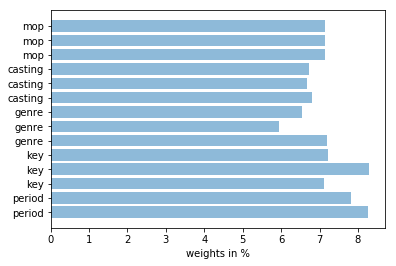

ERR: 0.41586867228929814


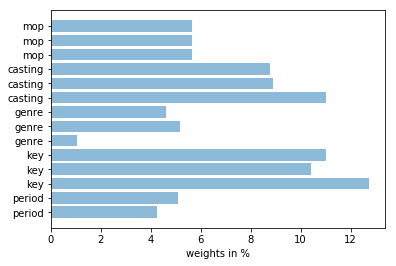

ERR: 4.197993963784508e-06


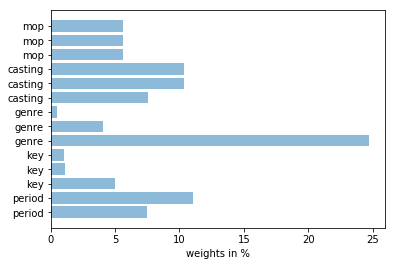

ERR: 0.0


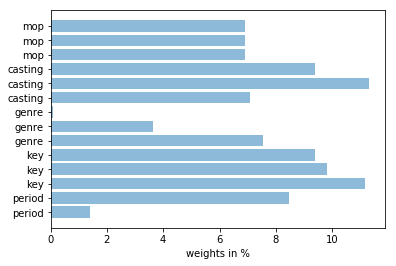

ERR: 0.6195303780504441


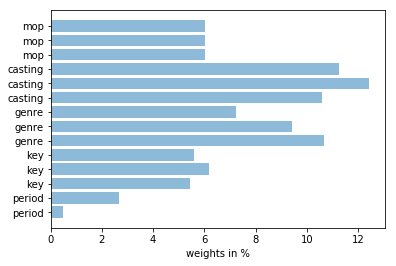

ERR: 0.0001773080658060031


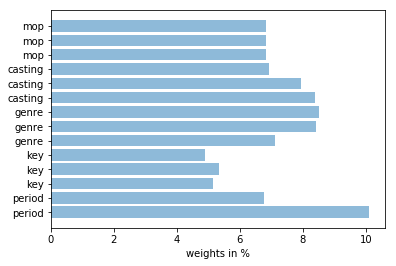

ERR: 0.044806143713491155


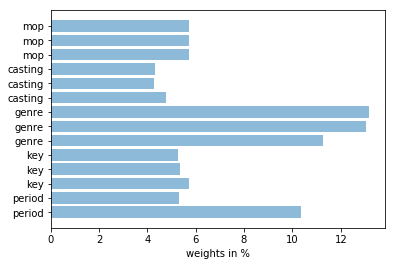

ERR: 2.5675971925790643e-05


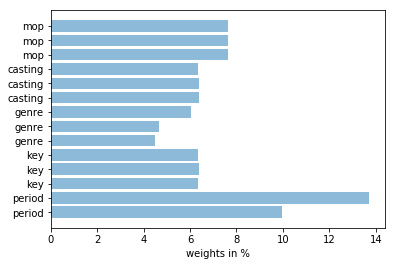

ERR: 0.00011356609798227085


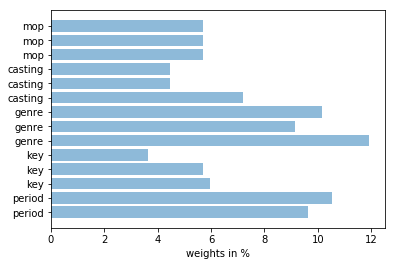

ERR: 0.00010452708800602541


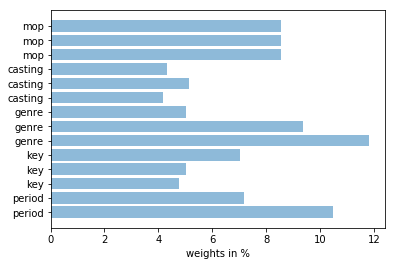

ERR: 0.05114959776274453


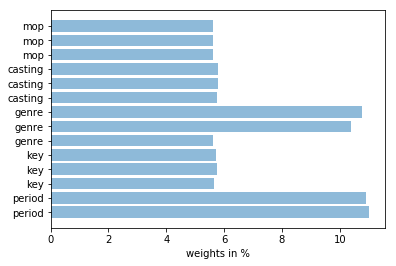

ERR: 4.1142673922299144e-05


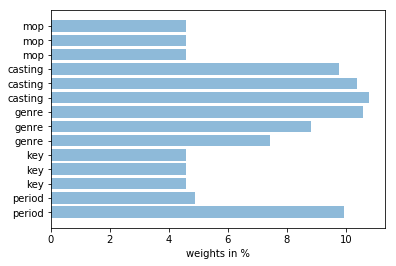

ERR: 7.882333329762714e-05


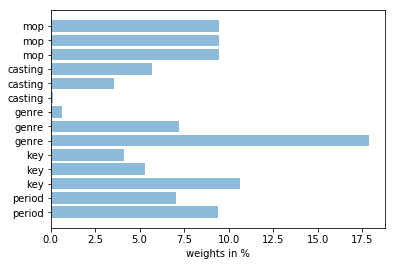

ERR: 0.00037891574791813526


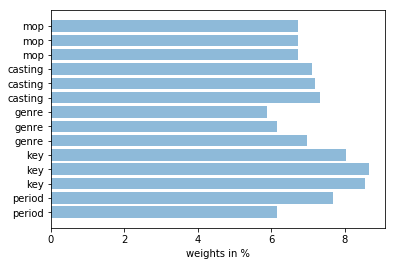

ERR: 0.00023769809502653872


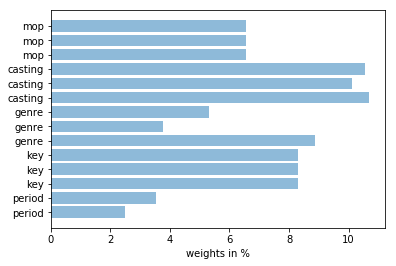

ERR: 3.0395901937295056e-05


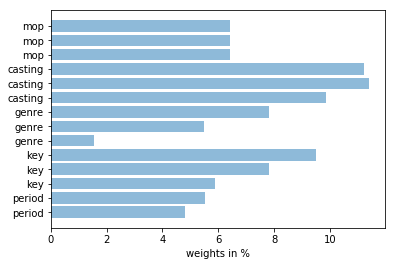

ERR: 2.7467015689573067e-05


ERR: 0.19077691072360128


ERR: 6.404590672949247e-05


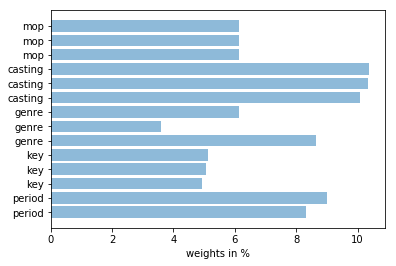

ERR: 0.5157427703034425


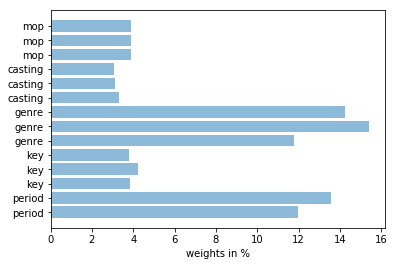

ERR: 0.05637047545866384


ERR: 9.403175854736295e-05


ERR: 0.0001964655552569845


ERR: 4.40267846847694e-05


ERR: 0.00021032405111651587


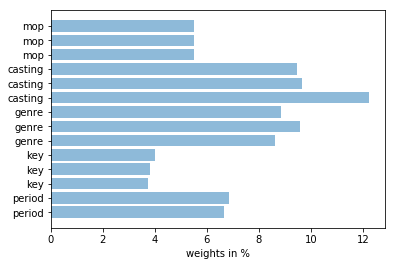

ERR: 0.024039675277970497


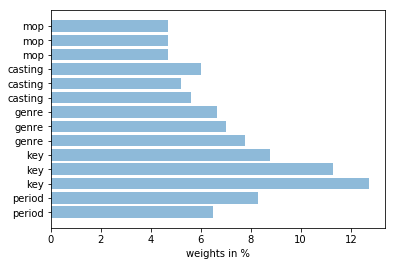

ERR: 0.2523318910139595


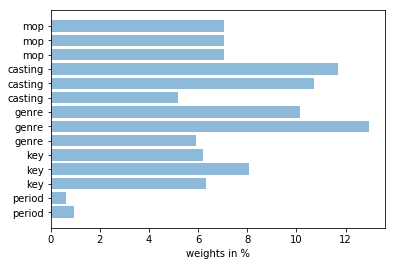

ERR: 0.05114093730550139


ERR: 0.00018174545868875143


ERR: 1.3902968504241227e-05


ERR: 3.712410448734094e-05


ERR: 0.19285627578338443


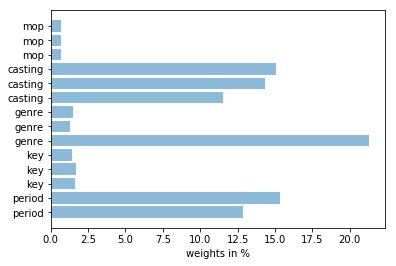

ERR: 0.0002781124735103609


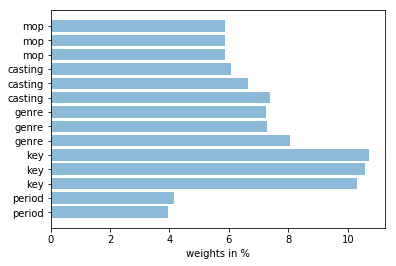

ERR: 0.25


ERR: 1.940296591574804e-05


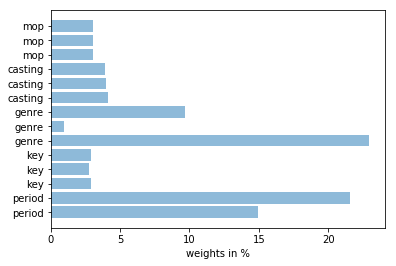

ERR: 0.045918367346938785


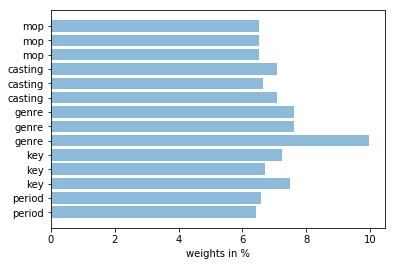

ERR: 0.1329010153125061


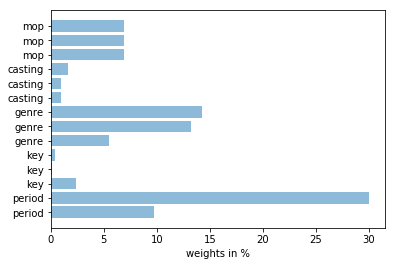

ERR: 0.005294160217979897


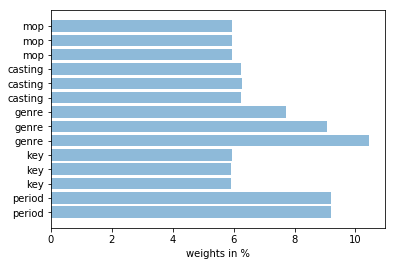

ERR: 2.7465452569016946e-05


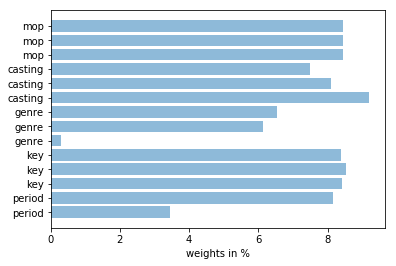

ERR: 0.1892570317171294


ERR: 6.557793298777547e-05


ERR: 0.0002839445161093561


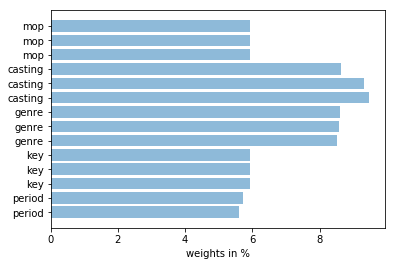

ERR: 0.049527780430559616


ERR: 0.0008291736450759779


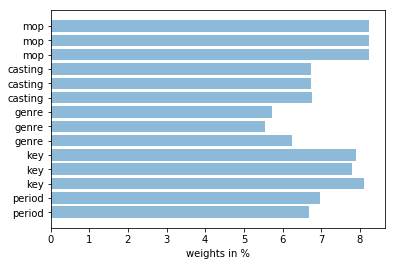

ERR: 3.397611266880486e-05


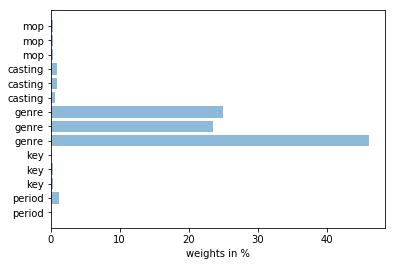

ERR: 0.00026363830950009375


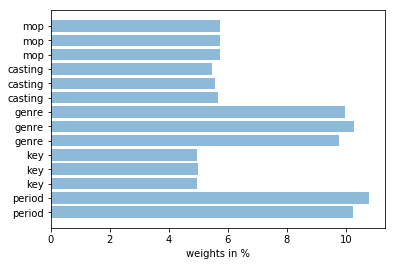

ERR: 8.558189428370434e-06


ERR: 0.008102551183843062


ERR: 0.08719071168653628


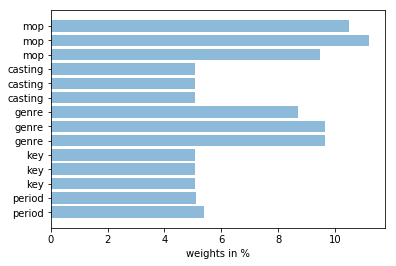

ERR: 0.6173469387755102


ERR: 0.18897680294214095


ERR: 0.0003144471740933147


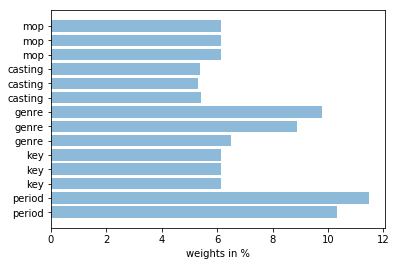

ERR: 2.378777728736176e-05


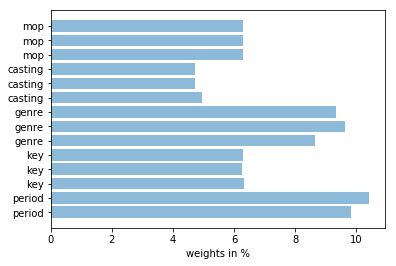

ERR: 0.04916593668711338


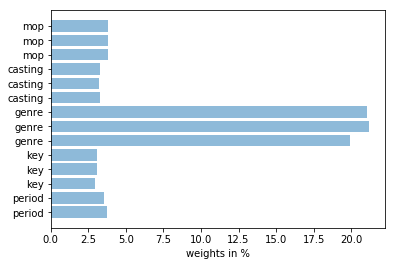

ERR: 2.328754184669678e-05


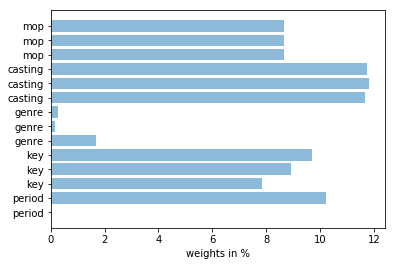

ERR: 2.310835395578224e-05


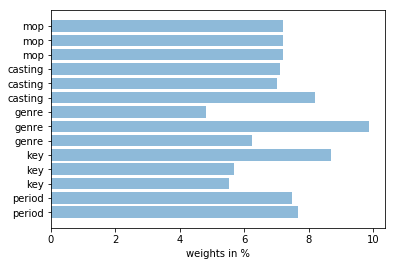

ERR: 0.00033434230820247884


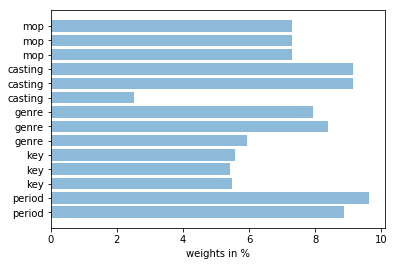

ERR: 0.05122066962178946


ERR: 0.00018922254118945343


ERR: 0.0


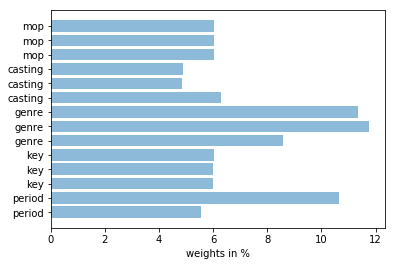

ERR: 0.047653959807766585


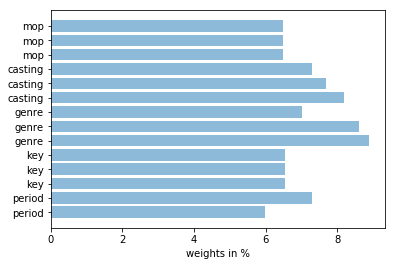

ERR: 0.00021661718069672503


ERR: 5.629077230983184e-05


ERR: 0.00025759108193671473


ERR: 0.005358054900507273


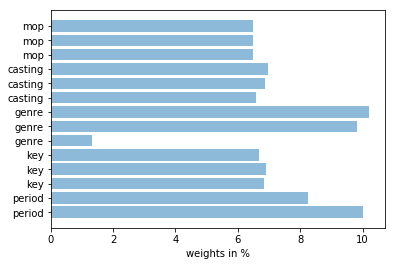

ERR: 4.407471966869963e-05


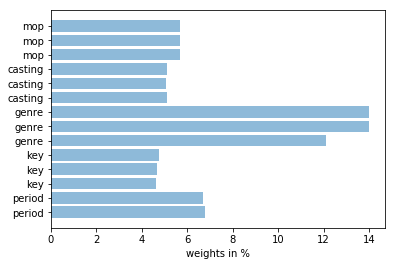

ERR: 0.0


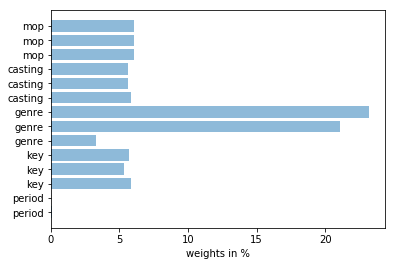

ERR: 0.0002536069513222995


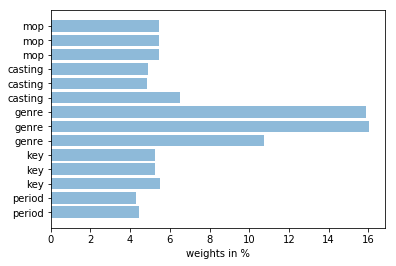

ERR: 0.1861797150216565


ERR: 0.00028700191634201035


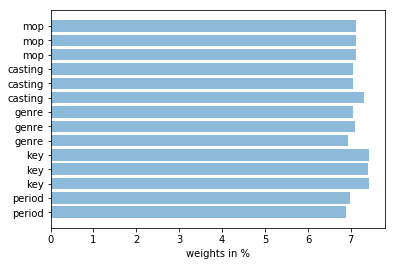

ERR: 0.04679914225160453


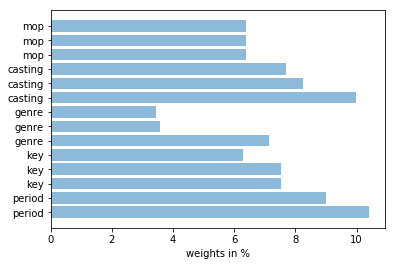

ERR: 0.9723325479114123


ERR: 0.006542963969987261


ERR: 0.4187521733907601


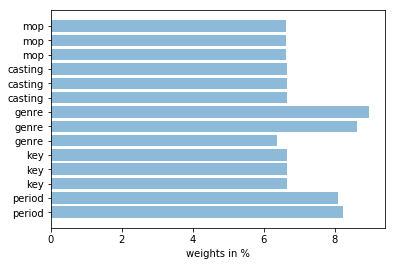

ERR: 0.5923037584428469


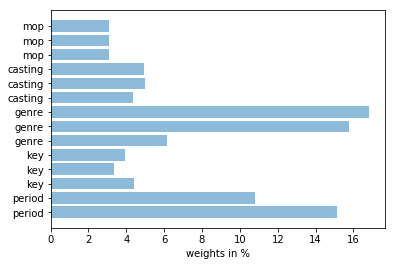

ERR: 0.054804277551934504


ERR: 0.0001298026587488872


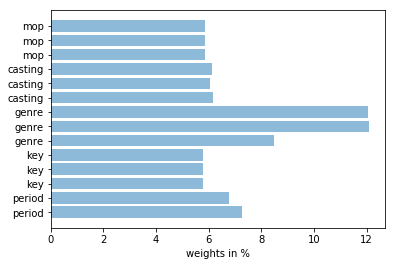

ERR: 2.1771842338479918e-05


ERR: 0.0001794403049655514


ERR: 0.022288098009691882


ERR: 0.32794737001617064


ERR: 5.252459563251418e-05


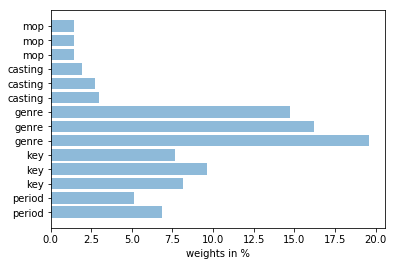

ERR: 0.00011990726537913455


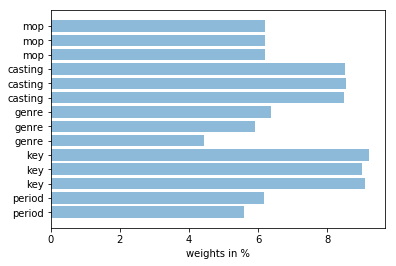

ERR: 0.00016518617427038182


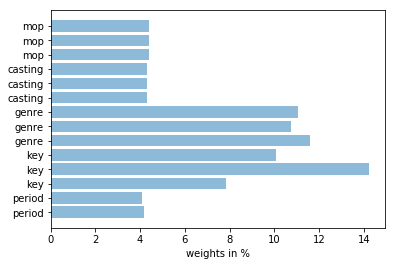

ERR: 4.369648493713736e-05


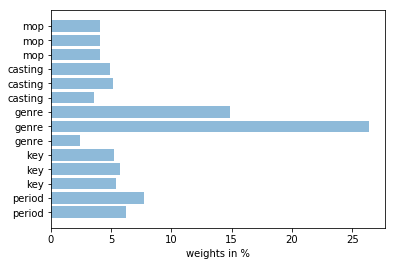

ERR: 0.048454806234640935


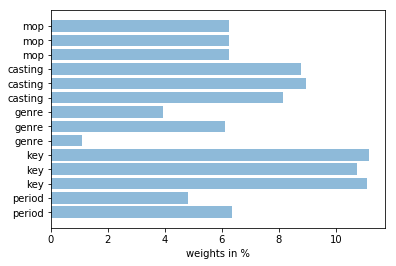

ERR: 0.00015554024016489884


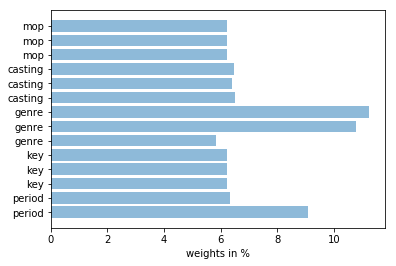

ERR: 0.08384784286082853


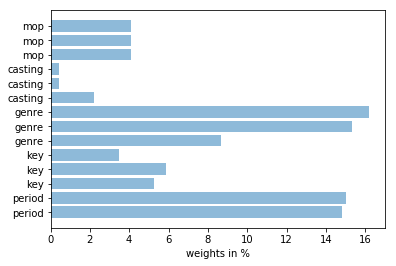

ERR: 0.05012134218761768


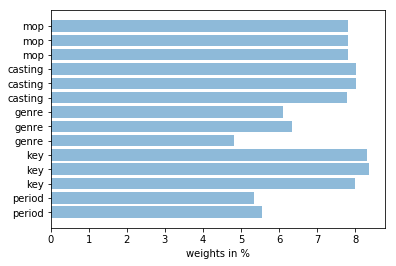

ERR: 0.0


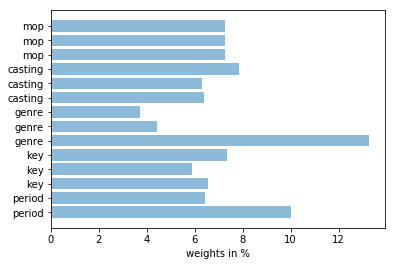

ERR: 6.024488555396426e-05


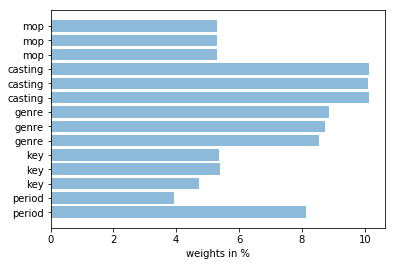

ERR: 0.0002752963162169093


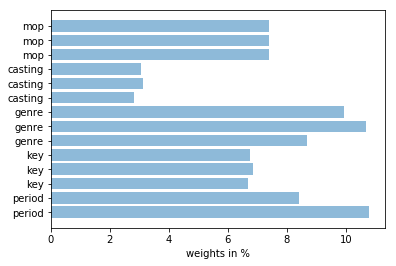

ERR: 0.0003960360484920613


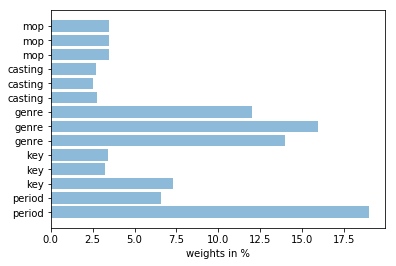

ERR: 0.048943841844379256


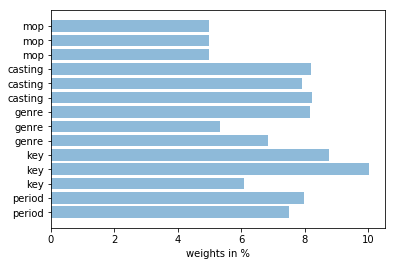

ERR: 0.04732082620530785


ERR: 2.7465880048597695e-05


ERR: 0.00026164241998318904


ERR: 0.05104188737545067


ERR: 0.504304129002705


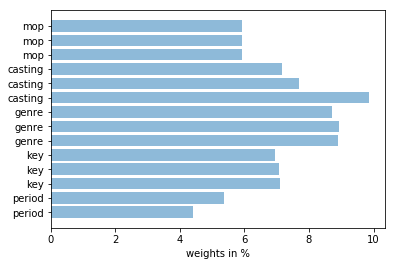

ERR: 0.08946815703499145


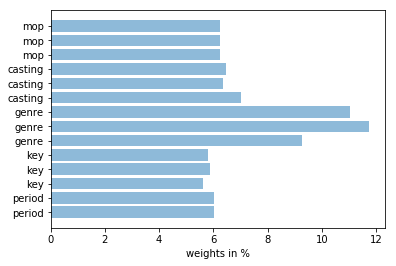

ERR: 2.7919531699897907e-05


ERR: 0.00011128170875574738


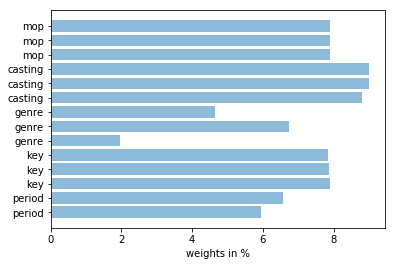

ERR: 7.530575999276317e-06


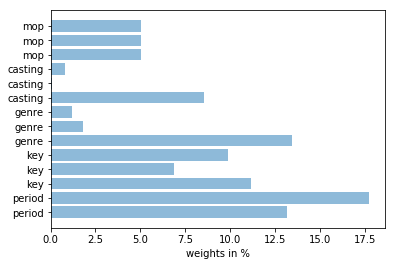

ERR: 0.05157523958874982


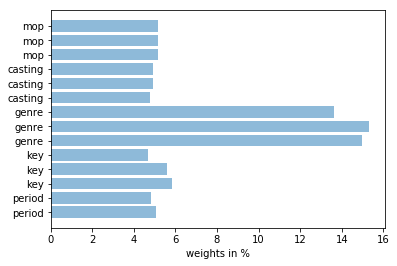

ERR: 0.0466033068998291


ERR: 0.08163265306122448


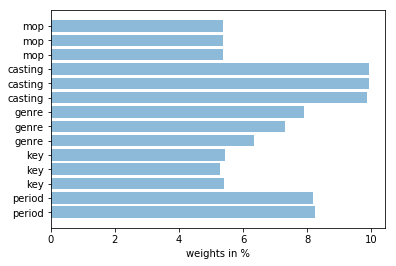

ERR: 0.19175866630743127


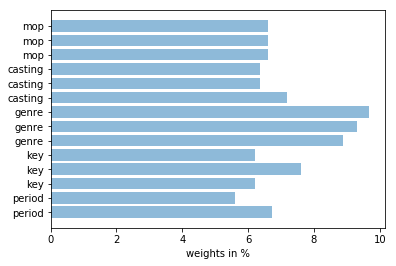

ERR: 0.3343513462028187


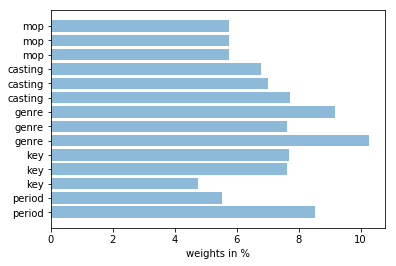

ERR: 0.18738068762489374


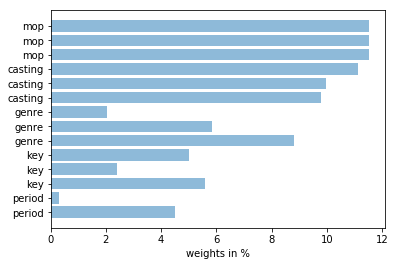

ERR: 0.0001674556896538776


ERR: 0.19020806237440108


ERR: 0.41646814806924093


ERR: 4.44223548106538e-05


ERR: 9.057374114834368e-05


ERR: 0.00015336010826686805


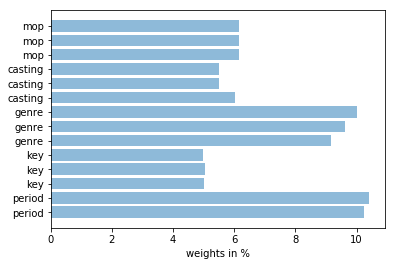

ERR: 4.689523804663183e-05


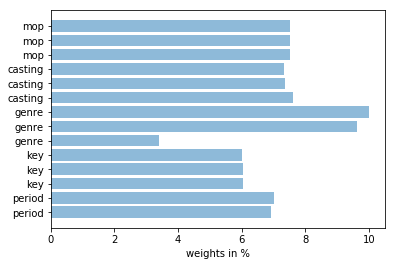

ERR: 0.00010624925845666787


ERR: 0.00019487363231078942


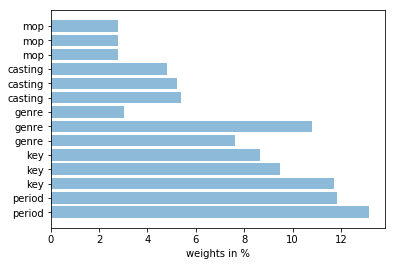

ERR: 1.5450233053127414e-05


ERR: 0.00020852199558379155


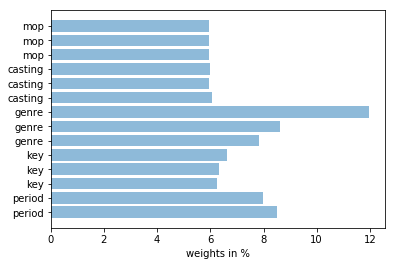

ERR: 0.00019326057228744888


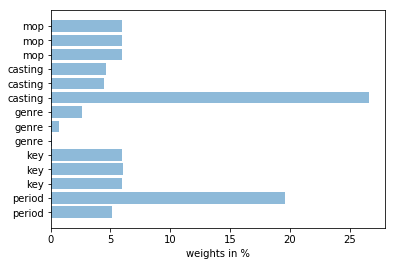

ERR: 2.864971730188349e-05


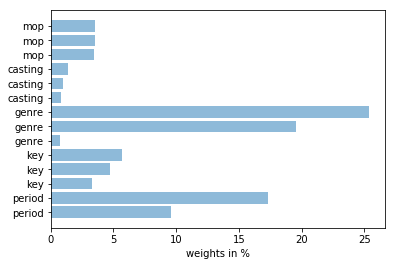

ERR: 6.585130034592287e-05


ERR: 0.00012211966914249176


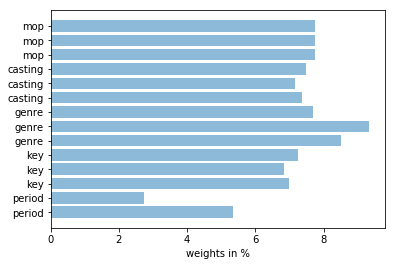

ERR: 2.3449436539679102e-05


ERR: 0.00011908302914616841


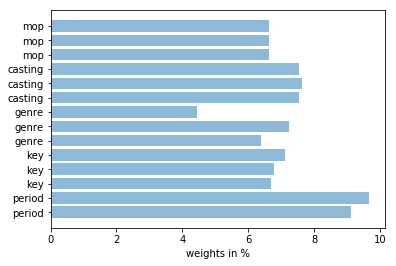

ERR: 4.08001538741677e-05


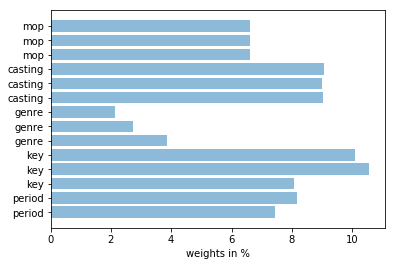

ERR: 0.04925032485054717


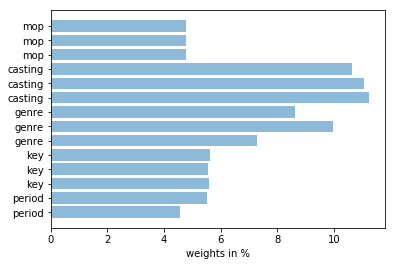

ERR: 0.00013481727796001223


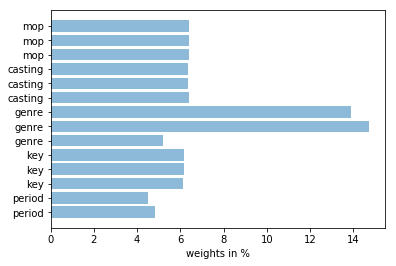

ERR: 1.0004912633631733e-05


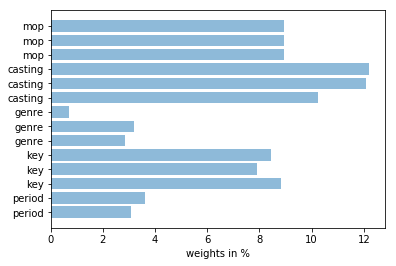

ERR: 0.00010201948008992834


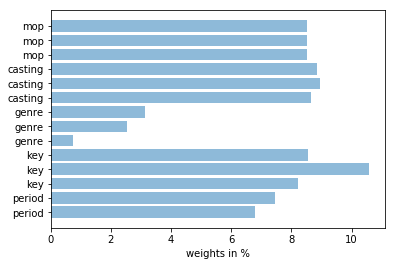

ERR: 0.048312808396470557


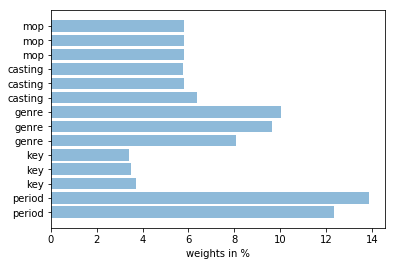

ERR: 1.4833135777145134e-05


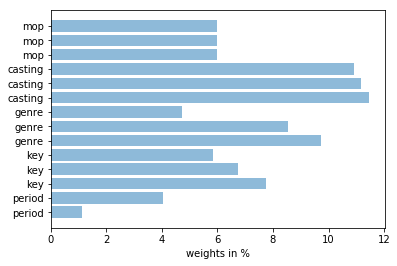

ERR: 0.0001453912551060528


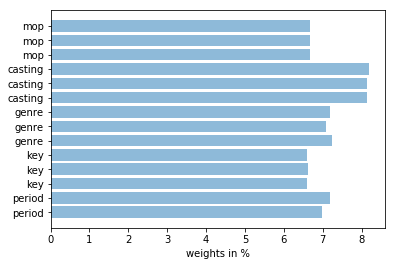

ERR: 0.00010773620674329798


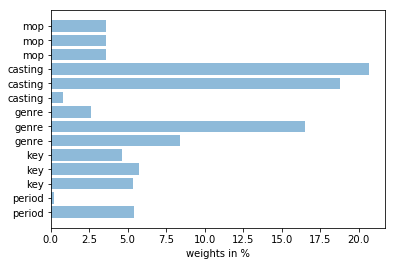

ERR: 0.0005715305311374503


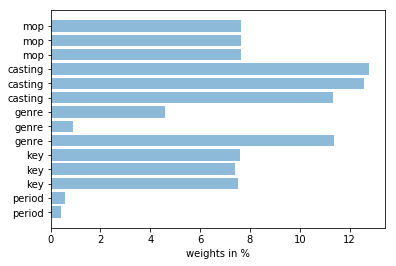

ERR: 0.00016719436979396033


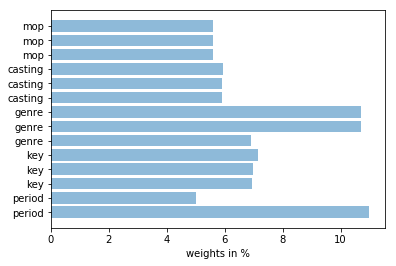

ERR: 0.0002364879761148458


ERR: 0.050733875223286574


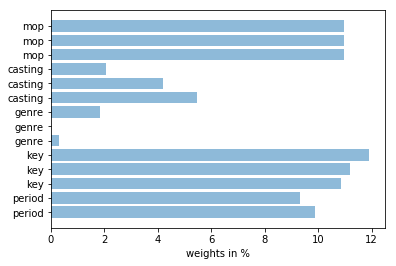

ERR: 0.0


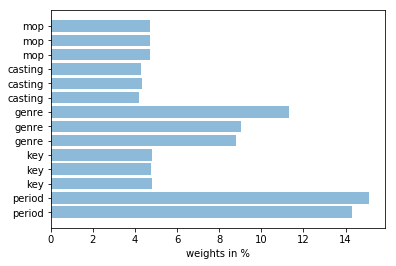

ERR: 8.973833993586853e-05


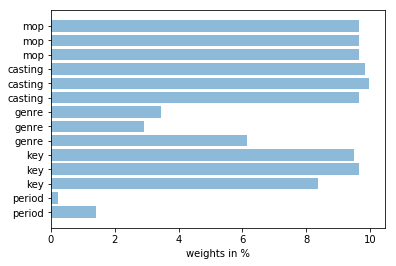

ERR: 0.00018193465096337662


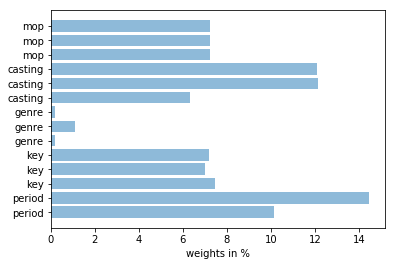

ERR: 0.33112113189509734


ERR: 0.18856208248024334


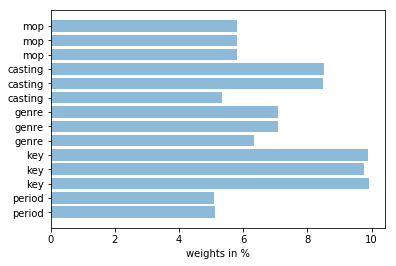

ERR: 0.0001510781513791046


ERR: 0.1863202129956575


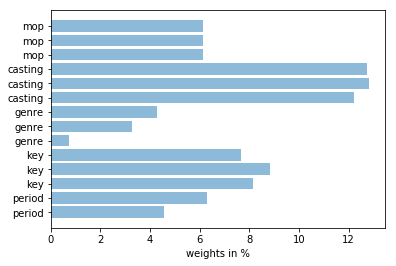

ERR: 0.00018575144142318967


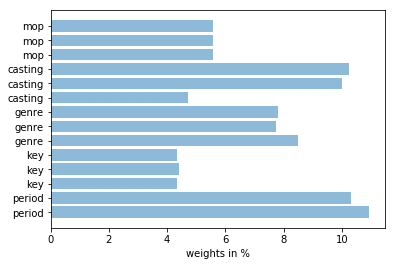

ERR: 0.04734461170715895


ERR: 1.1158879636158666e-05


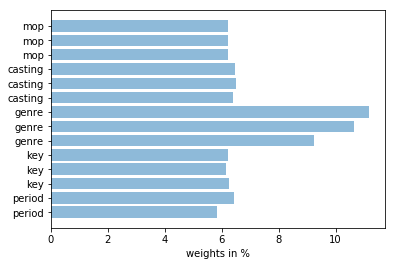

ERR: 7.569012385640349e-05


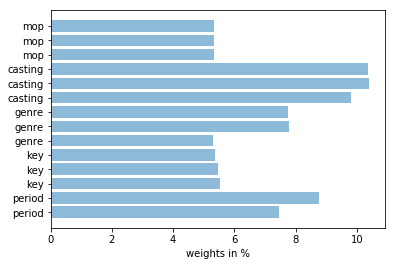

ERR: 4.502869897178463e-05


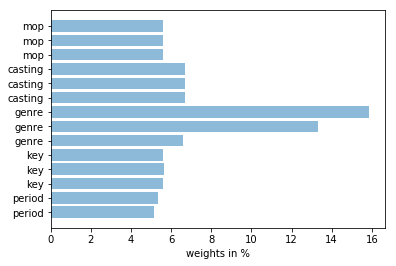

ERR: 0.18655970447121342


ERR: 0.00025228343839374016


ERR: 8.165239904124789e-05


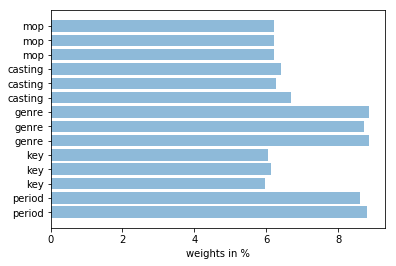

ERR: 7.34560019027015e-05


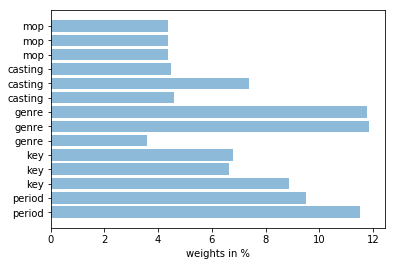

ERR: 0.049681395402566185


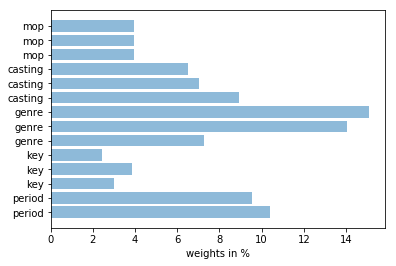

ERR: 0.04654145050648293


ERR: 0.0002820293907051653


ERR: 0.05007498155632662


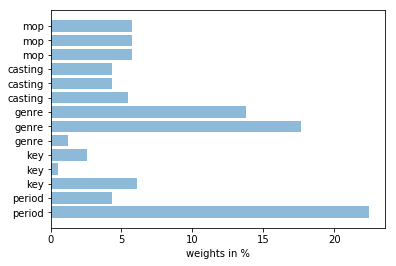

ERR: 0.00014496198878889165


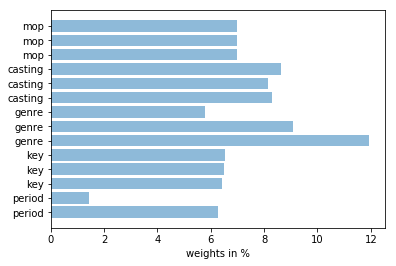

ERR: 0.00013266531307134786


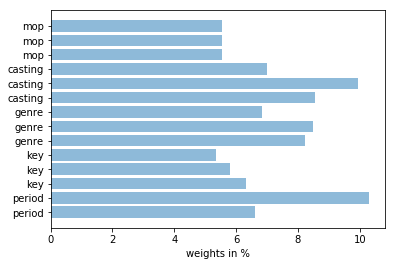

ERR: 0.04762515165991943


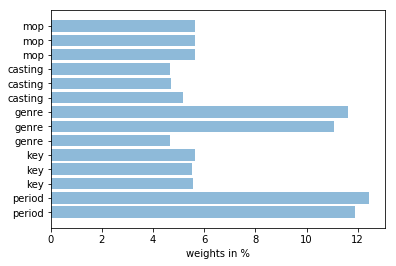

ERR: 0.08718989005487017


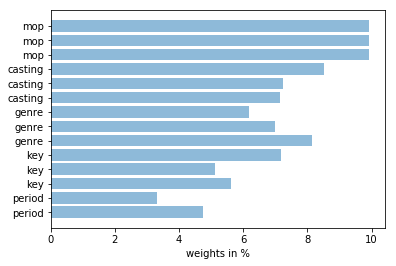

ERR: 7.825457164872343e-06


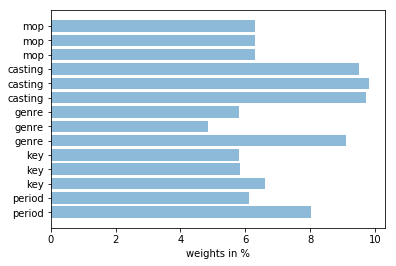

ERR: 0.04858458287458834


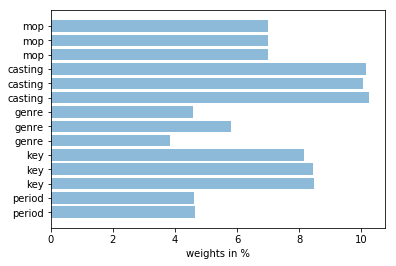

ERR: 0.048812182601757674


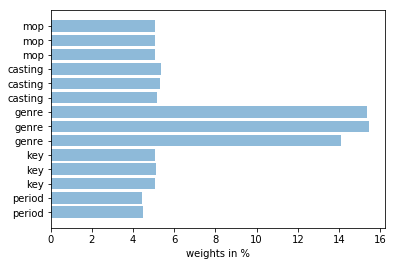

ERR: 0.0059563294742271565


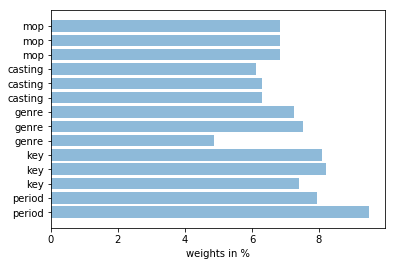

ERR: 0.005693746140493079


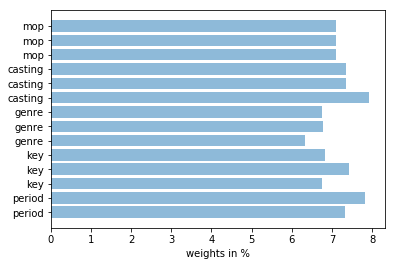

ERR: 4.884004401992411e-05


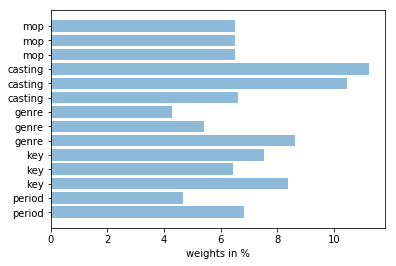

ERR: 0.9796227207284175


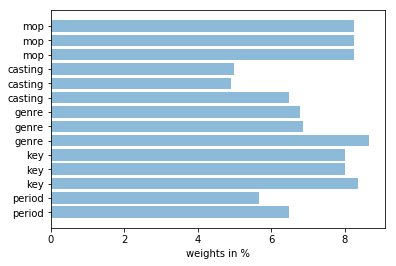

ERR: 2.6380951713068147e-05


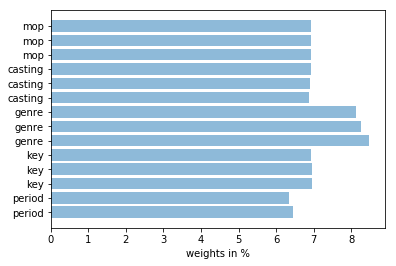

ERR: 0.00014245113737723584


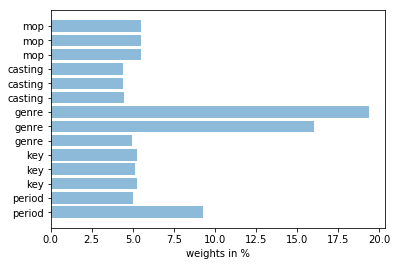

ERR: 0.18913605328260852


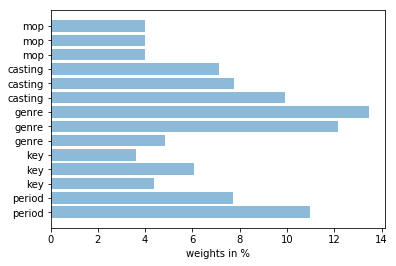

ERR: 3.6666995886985526e-05


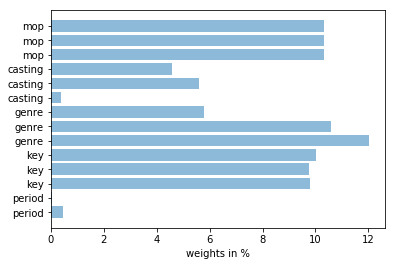

ERR: 5.346422468637554e-05


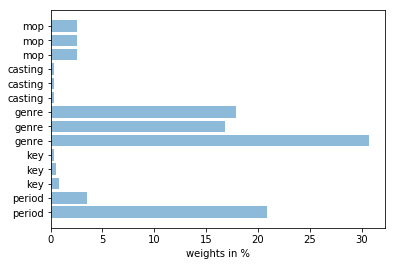

ERR: 0.00010610331876687522


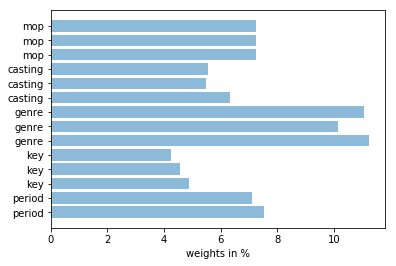

ERR: 0.04729403644214319


ERR: 0.1911612523769634


ERR: 0.053980729882938665


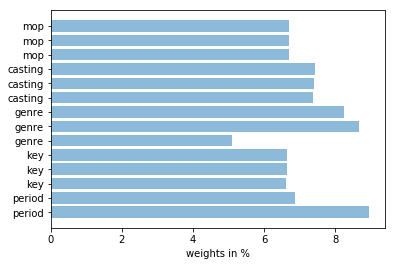

ERR: 2.290856174332716e-05


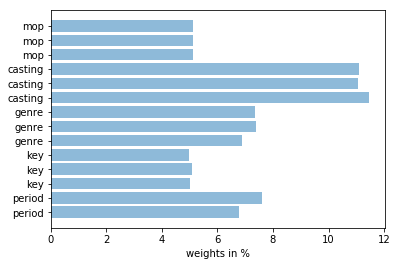

ERR: 4.404576294059608e-06


ERR: 0.25767722239373375


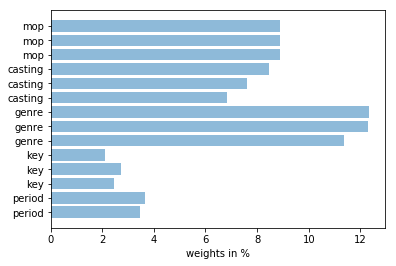

ERR: 0.00018243236443407139


ERR: 0.005475960112091512


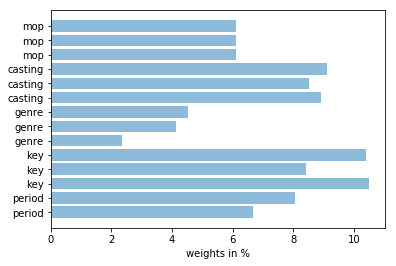

ERR: 9.048015580059289e-05


ERR: 0.0002515941550987142


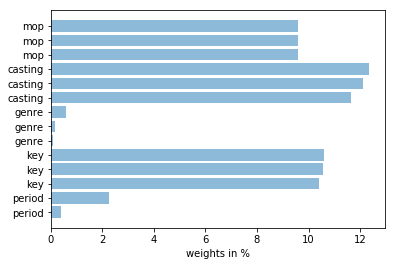

ERR: 9.629045848549881e-05


ERR: 0.049293656433688035


ERR: 2.786820149584805e-05


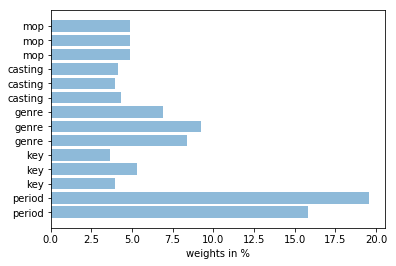

ERR: 0.0001303285224582462


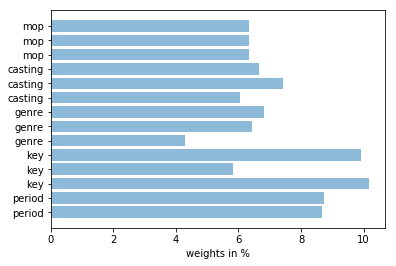

ERR: 0.00017058381154353864


ERR: 0.00036038995862883774


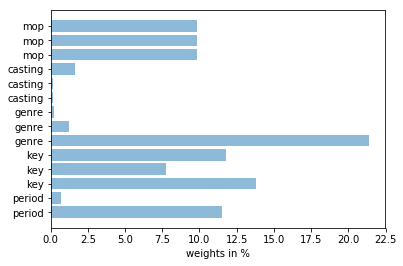

ERR: 0.048885819225491685


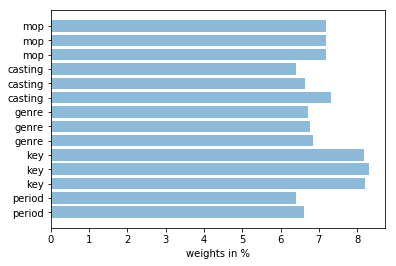

ERR: 0.1915400355028224


ERR: 8.449290130203106e-05


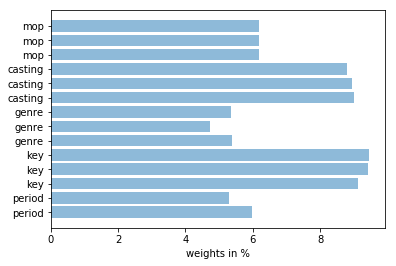

ERR: 6.765516901455303e-05


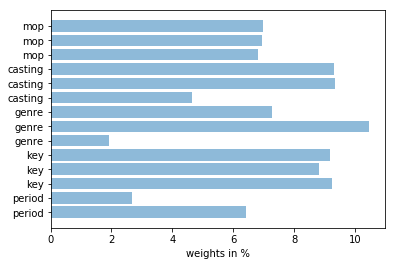

ERR: 7.617411813478918e-05


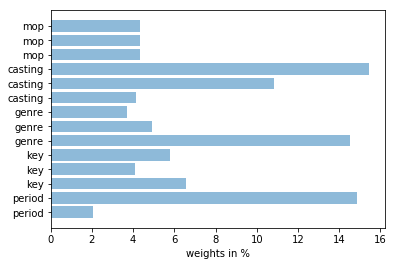

ERR: 0.5980697548678056


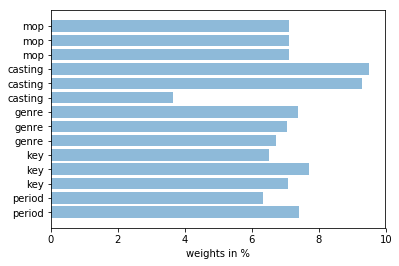

ERR: 0.04795396867620063


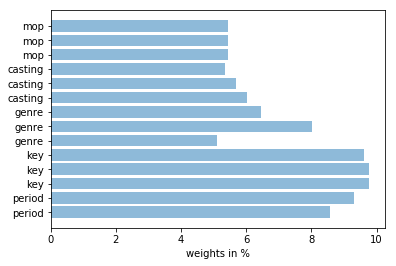

ERR: 2.6554046030337416e-05


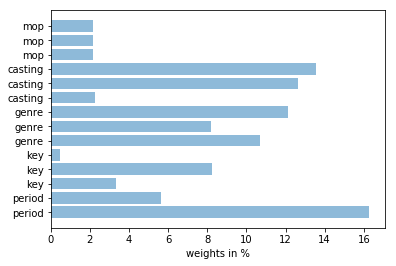

ERR: 0.08478118572567404


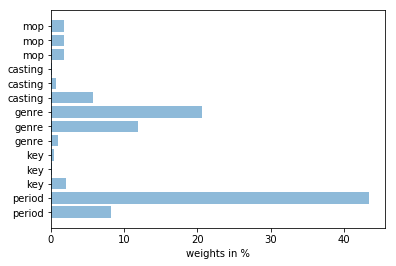

ERR: 5.1328297853851135e-05


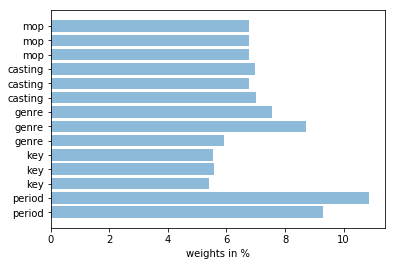

ERR: 9.32862806799135e-05


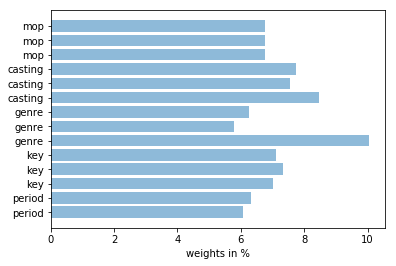

ERR: 0.0005560109529883037


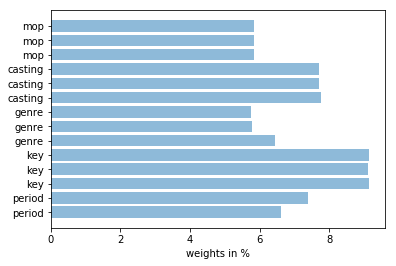

ERR: 0.00019188735198721443


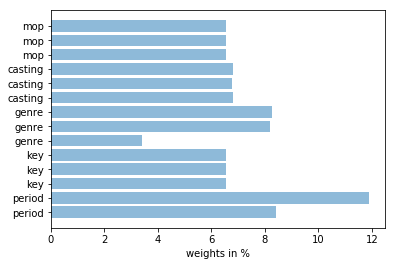

ERR: 0.0003117866756141438


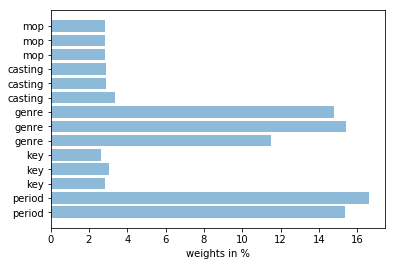

ERR: 9.889466534827153e-05


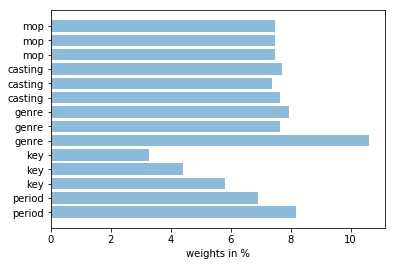

ERR: 0.0002212853915752639


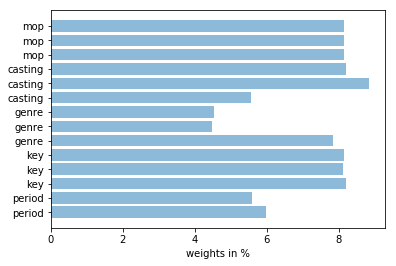

ERR: 1.5501000821814589e-06


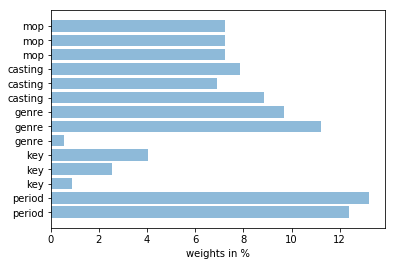

ERR: 8.30342343203486e-05


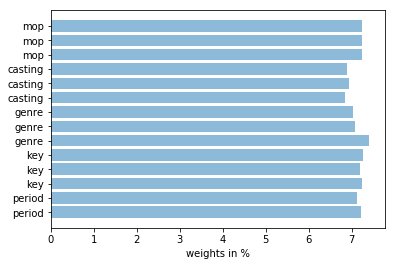

ERR: 5.190909849589649e-05


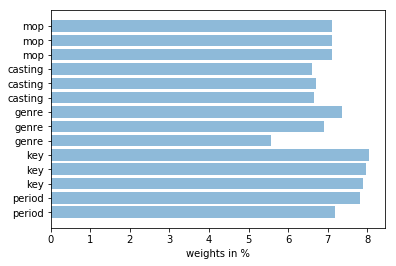

ERR: 0.048881487332746505


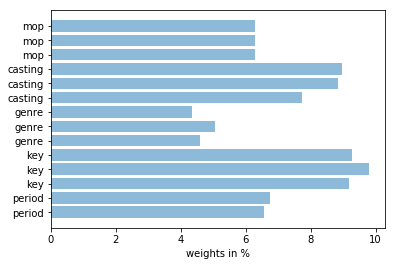

ERR: 2.6986973764832337e-05


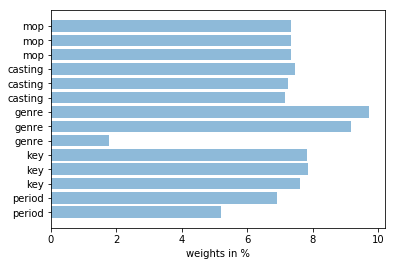

ERR: 0.04685597523183716


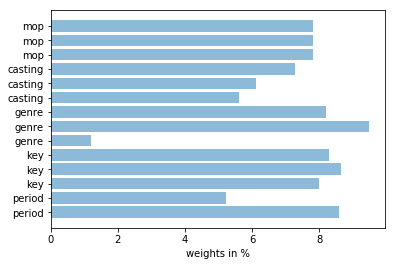

ERR: 8.634573483382976e-05


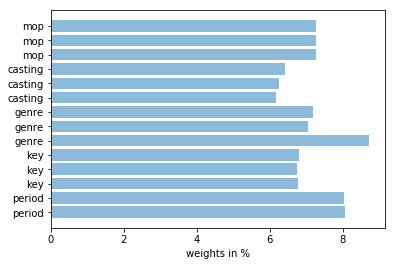

ERR: 2.8207087436155568e-05


ERR: 0.0005926378869037322


ERR: 0.04983692878101643


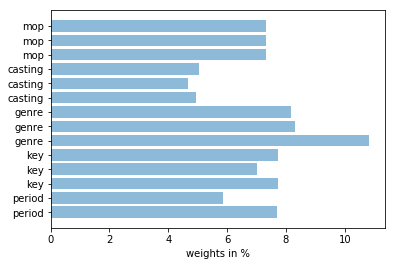

ERR: 0.0001993172709036777


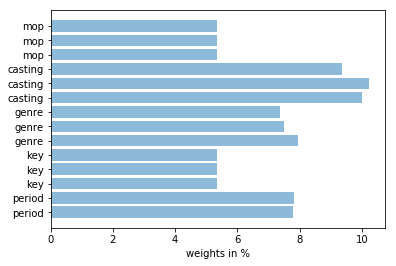

ERR: 0.00026430903235018244


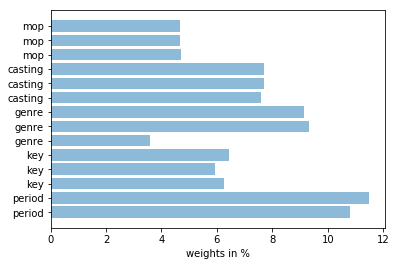

ERR: 0.3328898812401572


ERR: 1.4212842739822353e-05


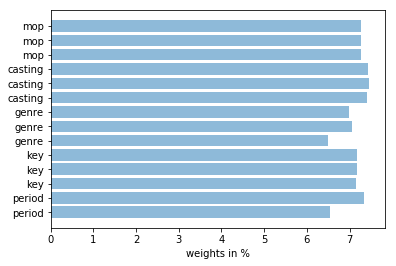

ERR: 0.049521863295147316


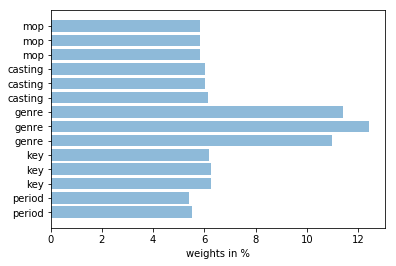

ERR: 7.673499377962249e-05


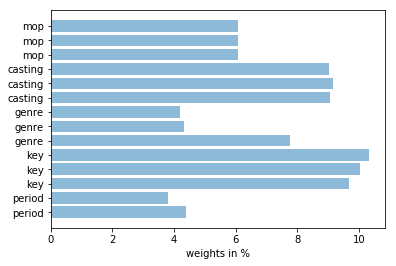

ERR: 0.0479675372218183


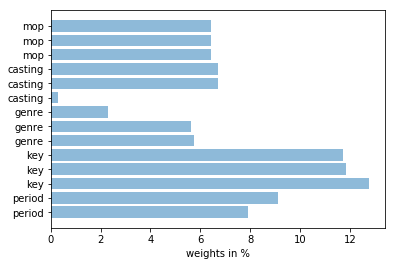

ERR: 0.00018094073834773998


ERR: 0.846850199766354


ERR: 0.04909351146622392


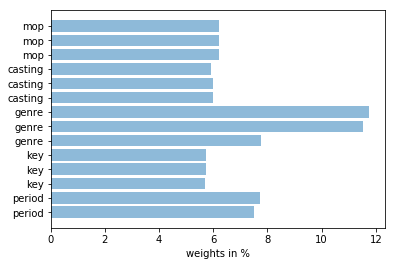

ERR: 0.00030767697336995007


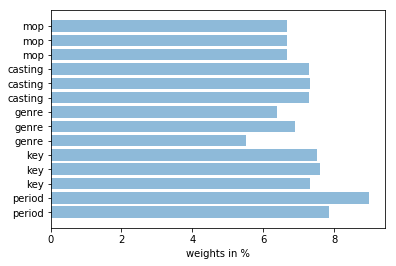

ERR: 0.006069683403439241


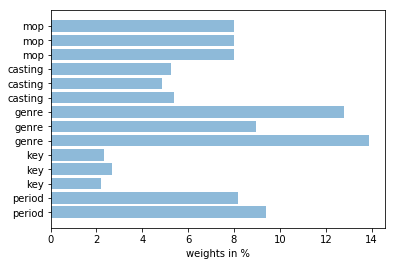

ERR: 5.750941453506981e-05


ERR: 0.00026814009220922153


ERR: 0.1324815354519224


ERR: 0.08163265306122448


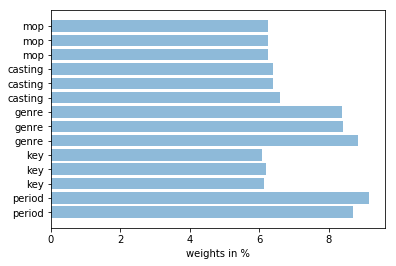

ERR: 0.6185204477155013


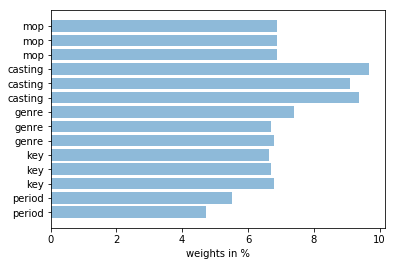

ERR: 6.622660507302565e-05


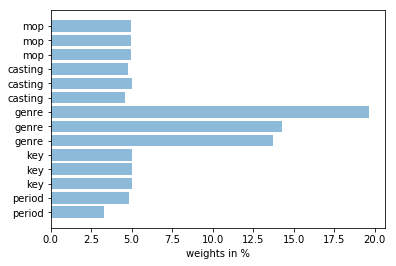

ERR: 0.04691821719659744


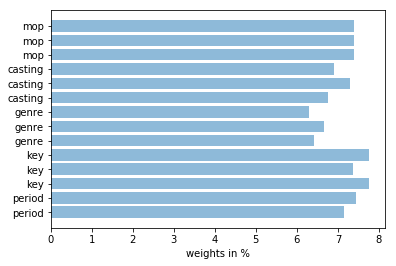

ERR: 4.976459076370414e-05


ERR: 9.363648333231736e-05


ERR: 0.9874591577396071


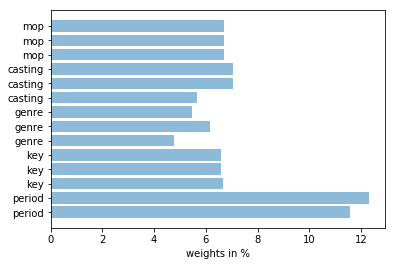

ERR: 0.0002989752876332919


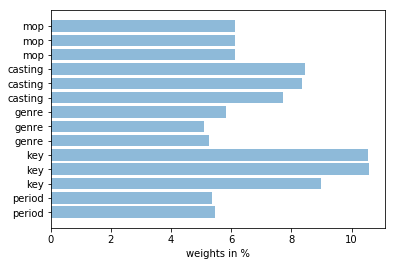

ERR: 3.594329338189908e-05


ERR: 4.2530425538029545e-05


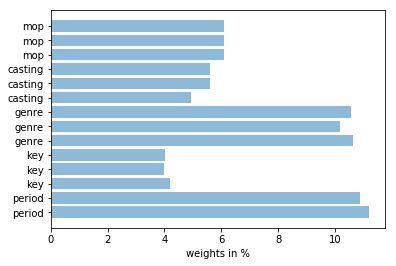

ERR: 0.04725234239092728


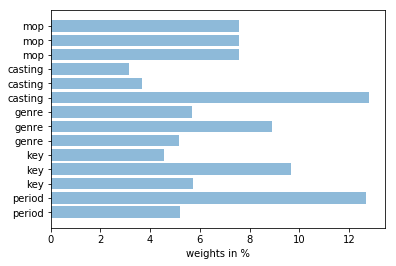

ERR: 0.0


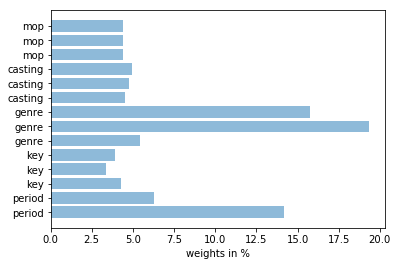

ERR: 0.0


ERR: 0.05193698941127525


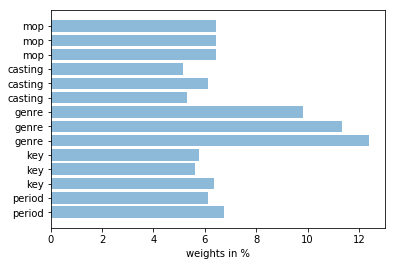

ERR: 0.04948748317176885


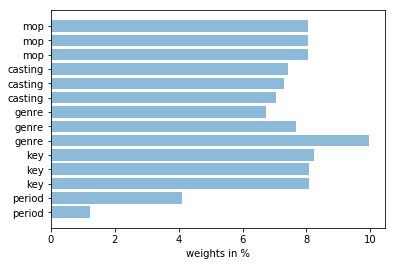

ERR: 7.458725189536849e-05


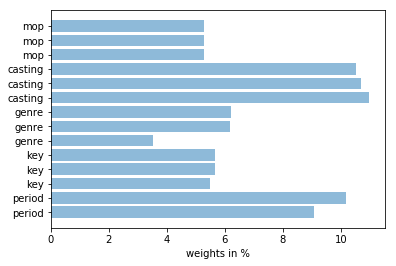

ERR: 2.8012750983253545e-05


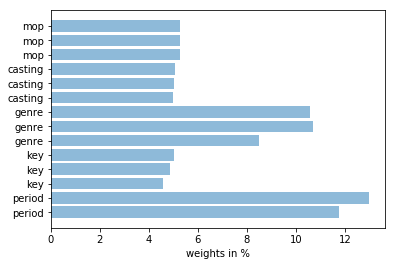

ERR: 0.00612667832109208


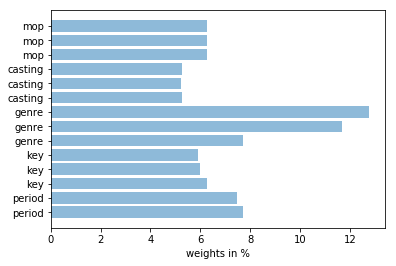

ERR: 0.00017359351265265962


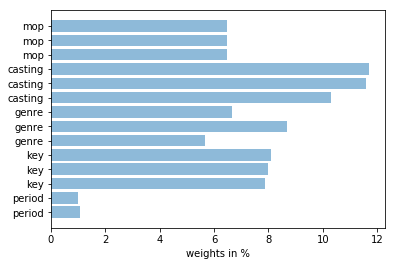

ERR: 0.0


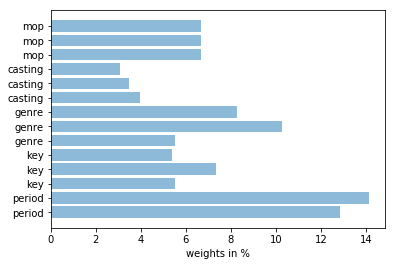

ERR: 8.276299600687419e-05


ERR: 0.0003476566587628256


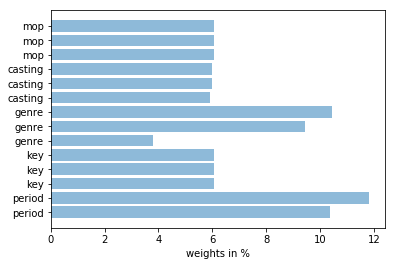

ERR: 9.243969258493359e-05


ERR: 0.0006889270727553155


ERR: 0.000482860780820394


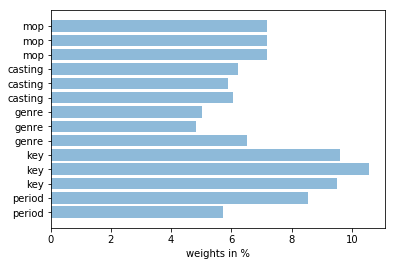

ERR: 0.00017739047525459583


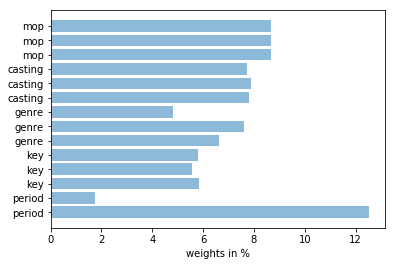

ERR: 0.0


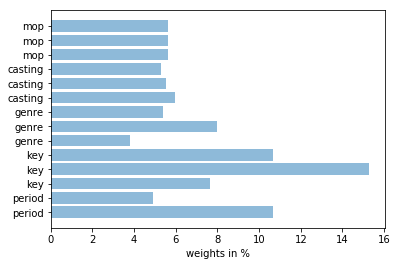

ERR: 0.33067049008556193


ERR: 0.047362293871773924


ERR: 0.0001509568894652453


ERR: 0.0002954352762754343


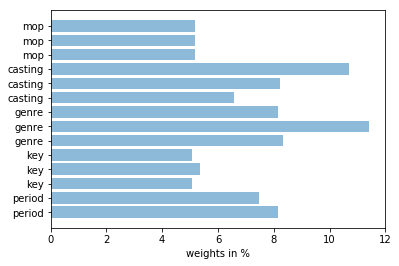

ERR: 0.00025301169705855246


ERR: 0.00018074393611858188


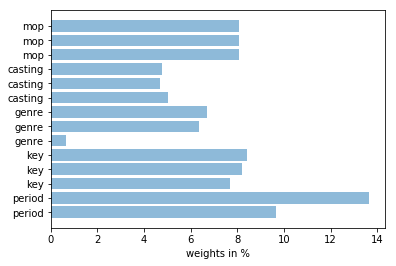

ERR: 0.021562641051495347


ERR: 0.00032137047938441944


ERR: 0.33137092727975526


ERR: 0.0002539720291502563


ERR: 9.919813972350035e-06


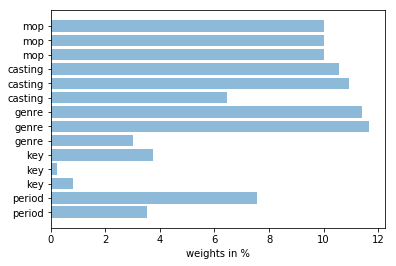

ERR: 0.006653812803057087


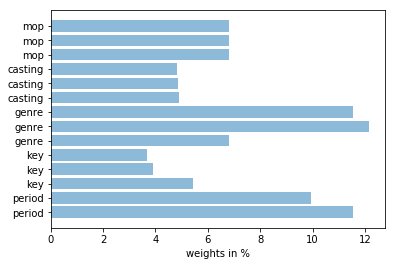

ERR: 1.951096832104362e-05


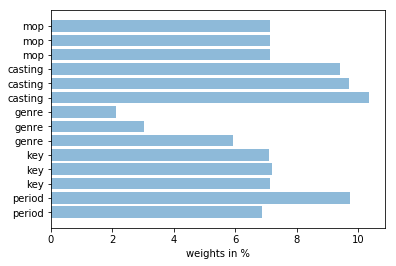

ERR: 0.049176659379121405


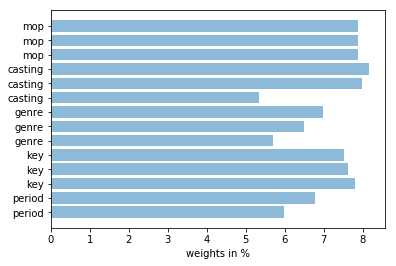

ERR: 0.00019367582923197484


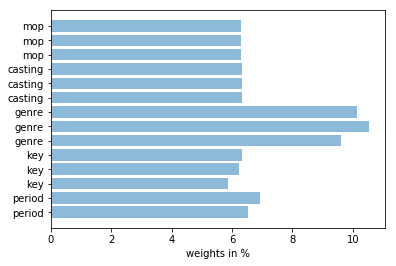

ERR: 0.0001400303135134286


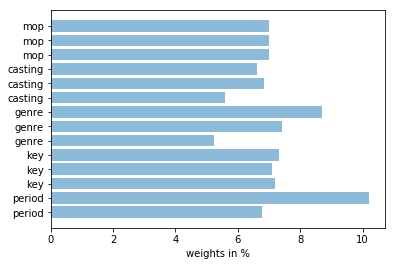

ERR: 2.1069625199418943e-05


ERR: 0.32853590439690344


ERR: 4.2509352431197143e-05


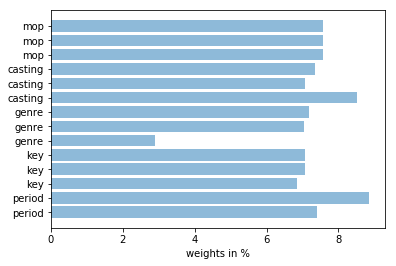

ERR: 0.048392350849280785


ERR: 0.18809768904372165


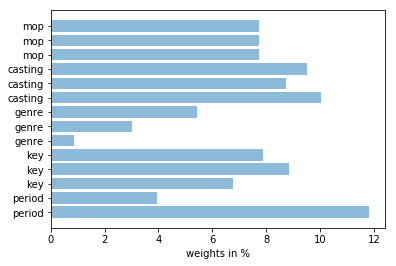

ERR: 5.7350576818069185e-05


ERR: 3.249307075031414e-05


ERR: 0.04692928617538011


ERR: 0.0004058986971753515


ERR: 0.9732275885887607


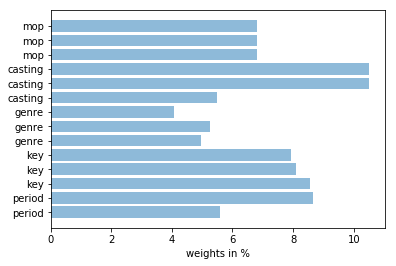

ERR: 0.050123199916994675


ERR: 0.05005917731388499


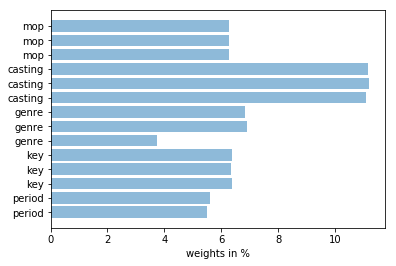

ERR: 0.19013072475587106


ERR: 0.05084719388158353


ERR: 0.18544971116706624


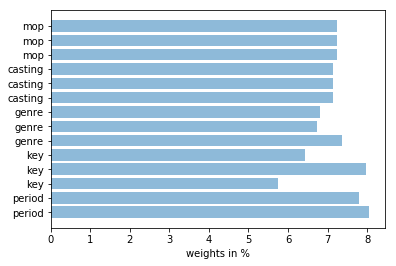

ERR: 2.7092377686109452e-05


ERR: 0.04925279748879273


ERR: 2.0790063485621968e-05


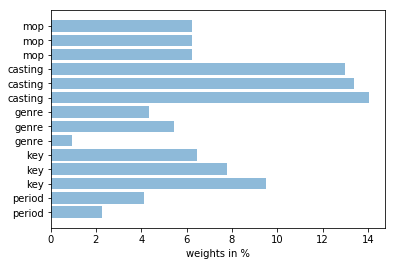

ERR: 0.04803500259117793


ERR: 0.00023478244866299093


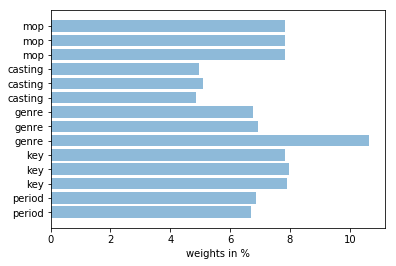

ERR: 0.00019647079523168776


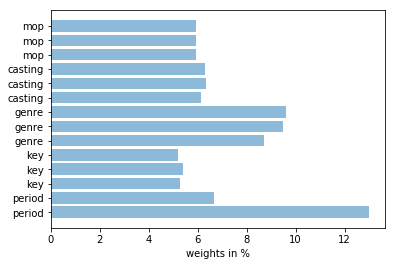

ERR: 5.260713458618022e-05


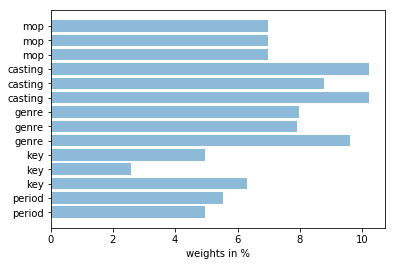

ERR: 0.00025065808396522064


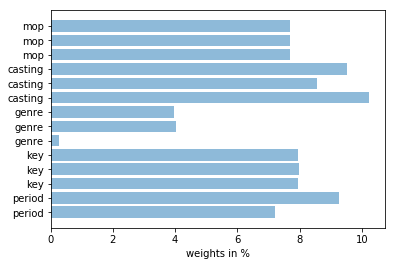

ERR: 5.830022616612829e-05


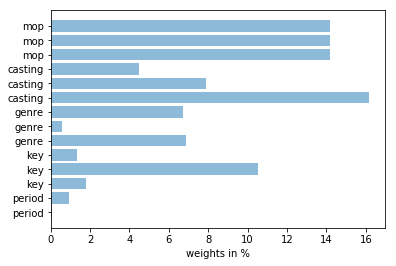

ERR: 0.0508932228333195


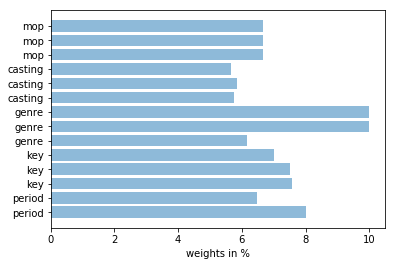

ERR: 8.784021728231391e-05


ERR: 5.4117407706174353e-05


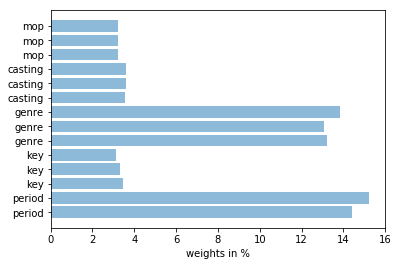

ERR: 0.049877250460437436


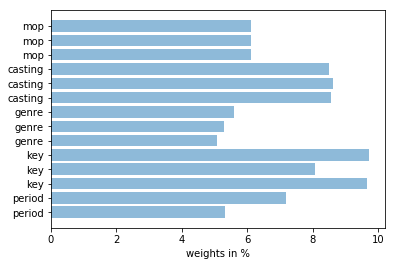

ERR: 1.5170596282116182e-05


ERR: 0.00020751171097745889


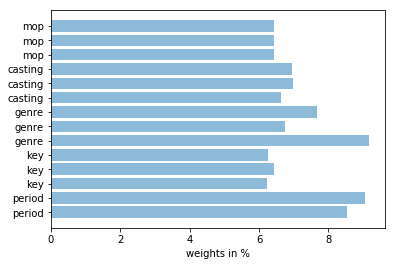

ERR: 0.049178919076332754


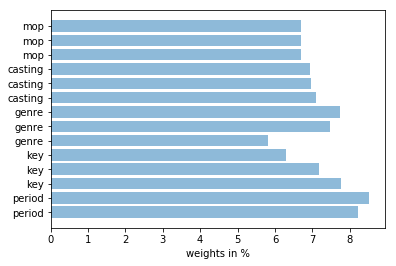

ERR: 0.00016514507831258518


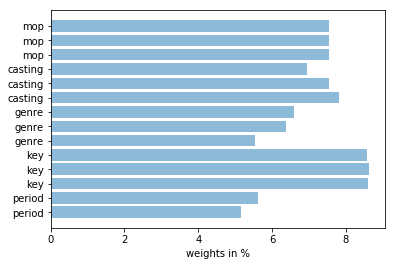

ERR: 4.244166748468967e-05


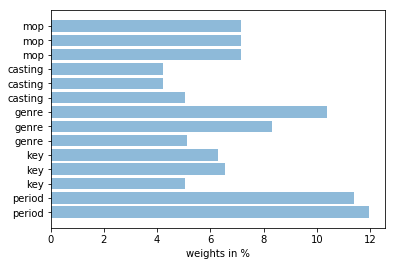

ERR: 0.18675609837723922


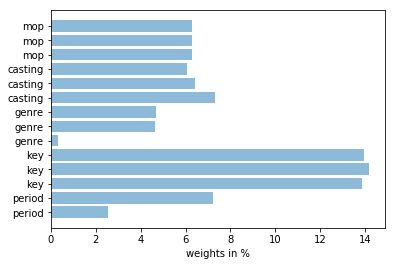

ERR: 3.6192774389300977e-05


ERR: 0.0002157133325396227


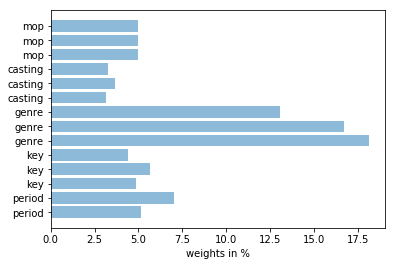

ERR: 1.0880252816444103e-05


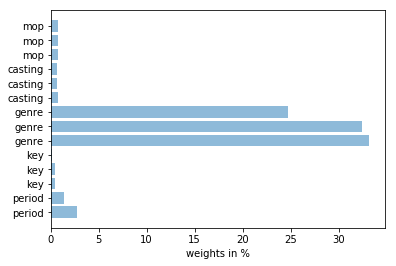

ERR: 9.120950489528965e-05


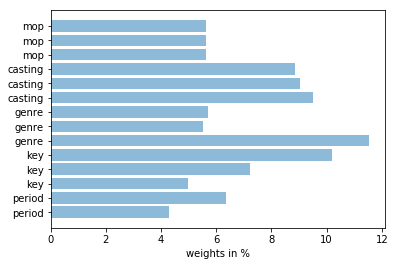

ERR: 0.047979878473106544


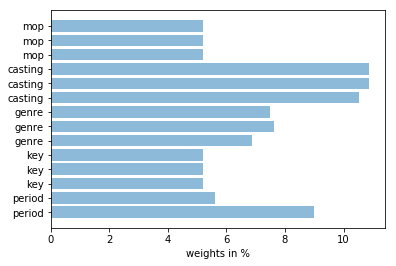

ERR: 4.487557147865579e-05


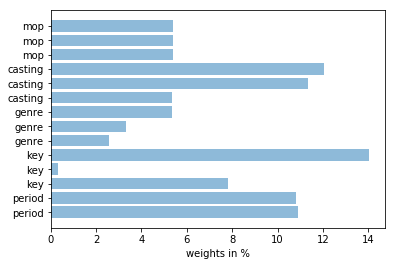

ERR: 1.0322121515300337e-05


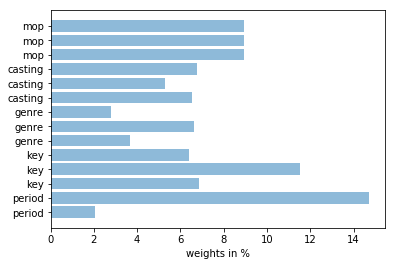

ERR: 0.0


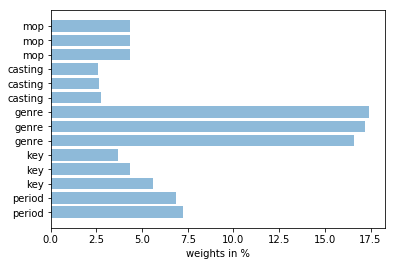

ERR: 4.421633804539191e-05


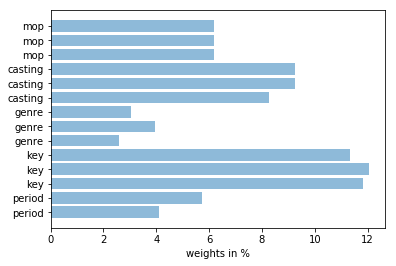

ERR: 0.00011160831540626844


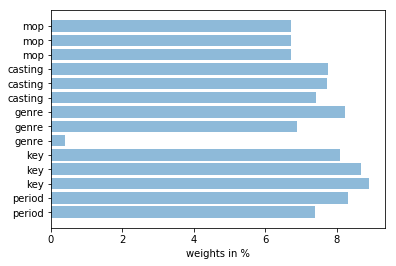

ERR: 0.00010087409144241088


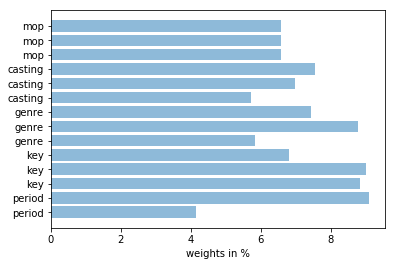

ERR: 0.0


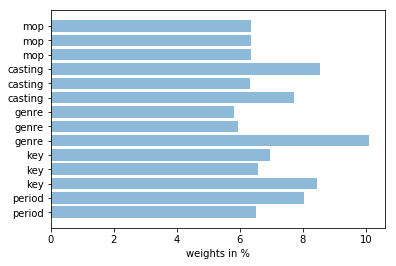

ERR: 0.00012392508070399488


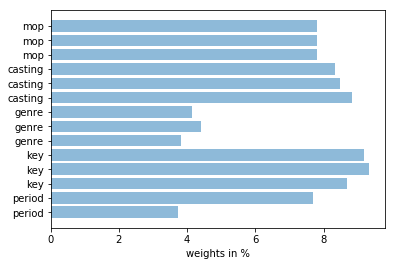

ERR: 5.3702189449868216e-05


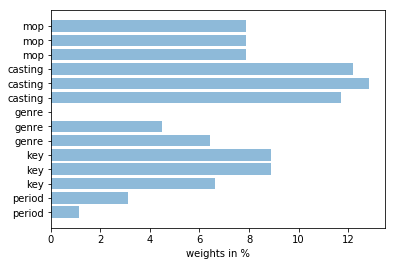

ERR: 6.50053584395978e-05


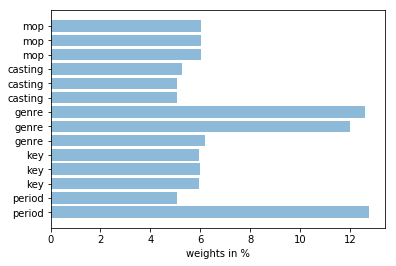

ERR: 0.048739014057521554


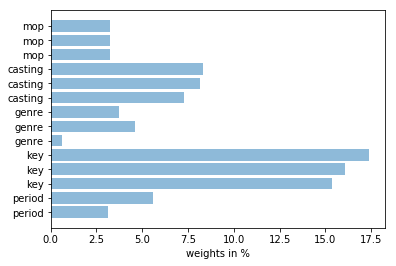

ERR: 1.0565190196183194e-05


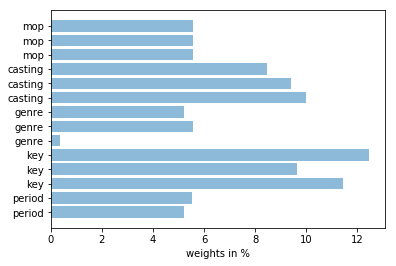

ERR: 2.9824188553739653e-05


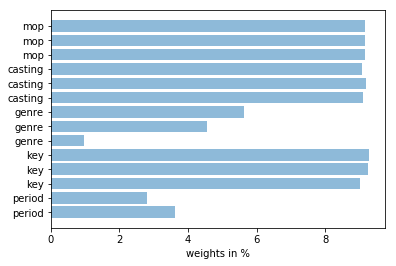

ERR: 0.00042614589907601324


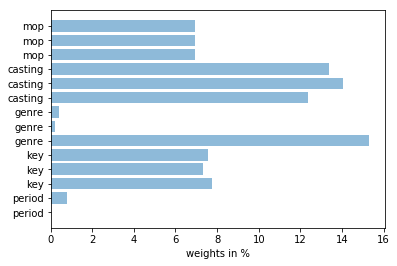

ERR: 0.0001306314275612194


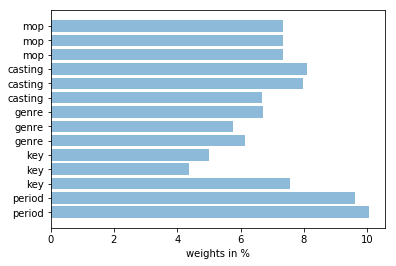

ERR: 3.545162429023397e-05


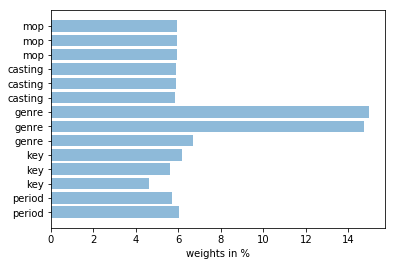

ERR: 5.4290501676934644e-05


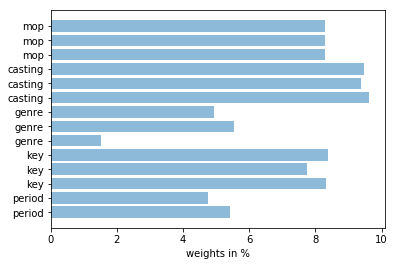

ERR: 4.350622176910008e-05


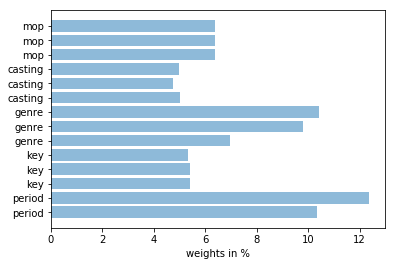

ERR: 8.641858159307829e-05


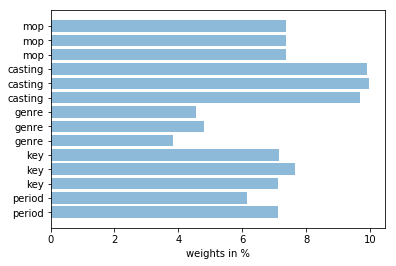

ERR: 0.2515354490515883


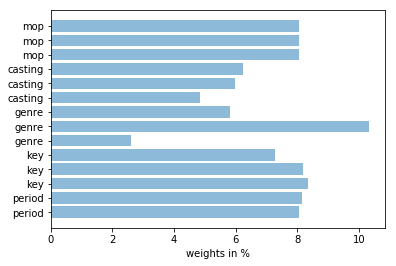

ERR: 0.04983346648578058


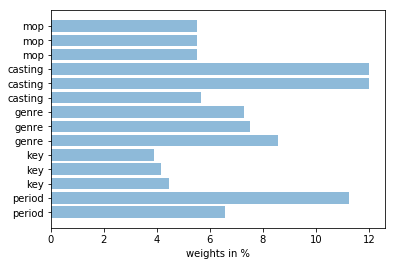

ERR: 0.9708763417787979


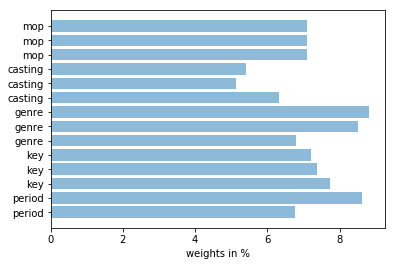

ERR: 1.0


ERR: 0.05069246930661511


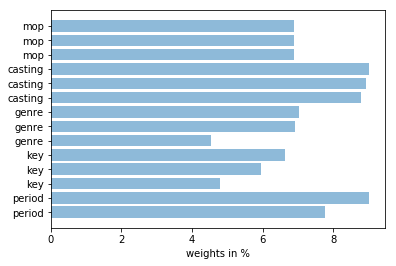

ERR: 0.0015633612503692933


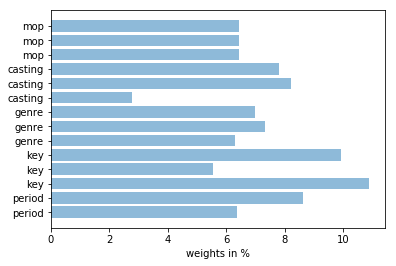

ERR: 0.047625665003207814


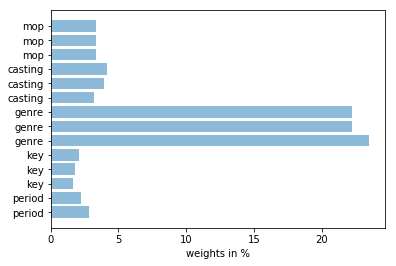

ERR: 2.6217305057084096e-05


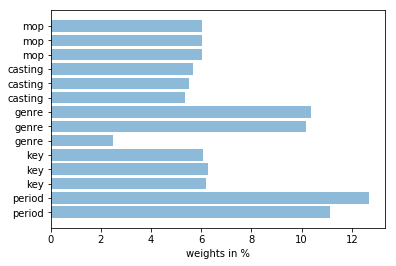

ERR: 0.00013964791058958387


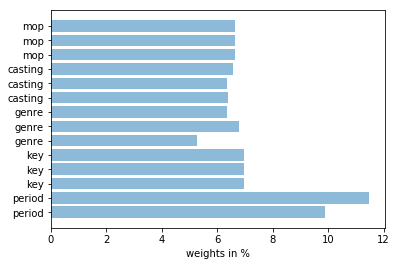

ERR: 0.0468810119761459


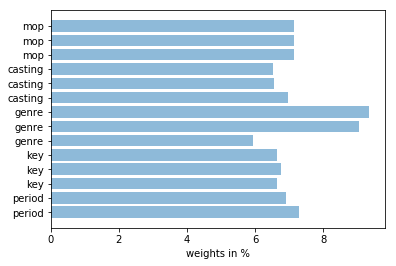

ERR: 0.04962751545047093


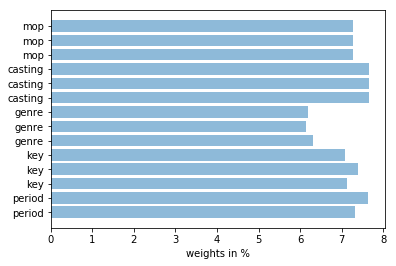

ERR: 0.33303334009186647


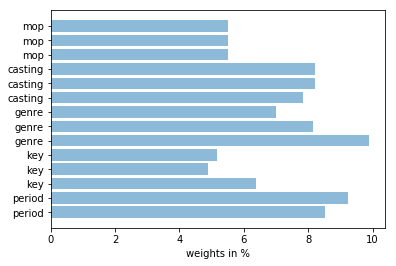

ERR: 0.04834291767700888


ERR: 0.048918589421369015


ERR: 0.00027912822828889946


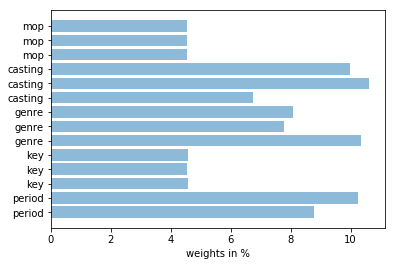

ERR: 6.306186961932792e-05


ERR: 0.00015682551095303564


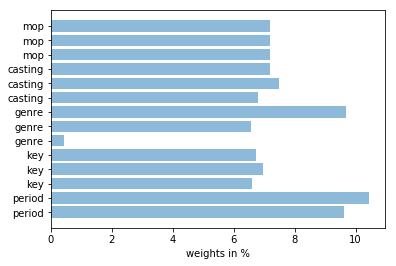

ERR: 0.00018973586459546931


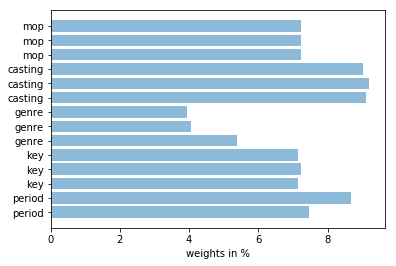

ERR: 0.00026254827938547415


ERR: 0.8564712826715087


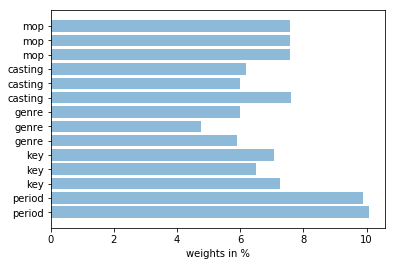

ERR: 0.04802092439285171


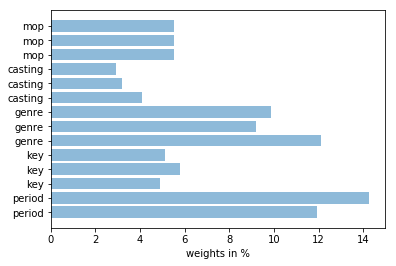

ERR: 0.6025257373030011


ERR: 0.0001952612010137397


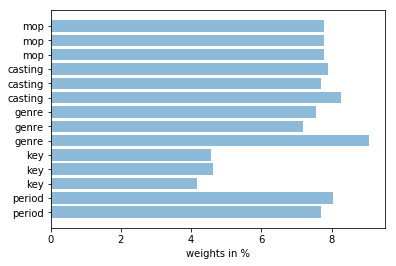

ERR: 0.00011969915529190869


ERR: 0.0002204141516617463


ERR: 0.00010668720356354592


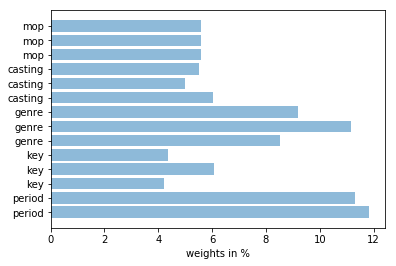

ERR: 5.33648451499705e-05


ERR: 0.04890993302147372


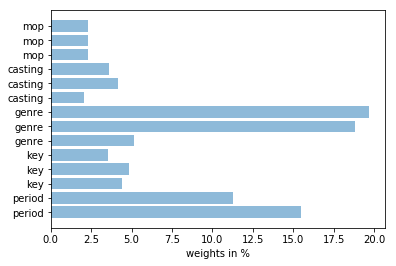

ERR: 0.00024996495774152783


ERR: 0.2554090525894039


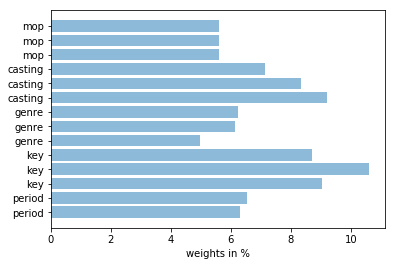

ERR: 0.983931453728852


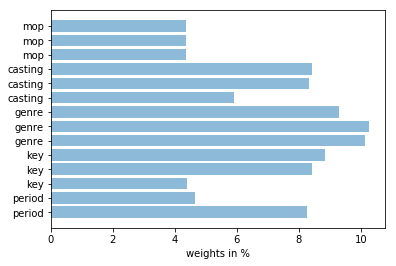

ERR: 5.437037733384068e-05


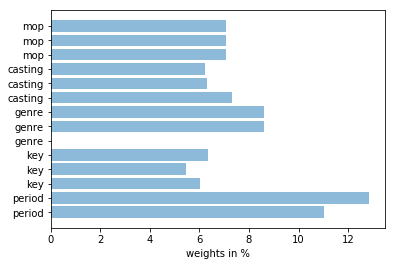

ERR: 0.00010392567146684634


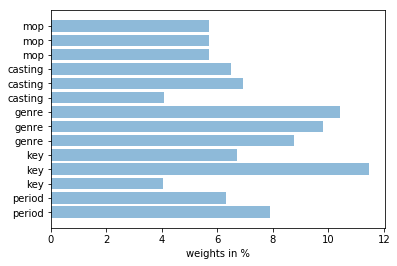

ERR: 0.0


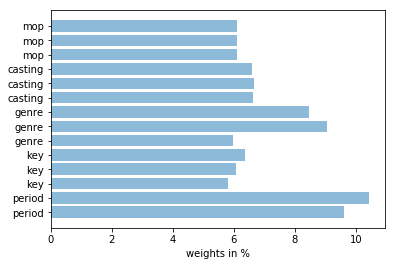

ERR: 0.9955166984450955


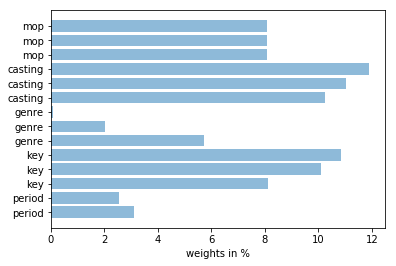

ERR: 0.00012357018761949696


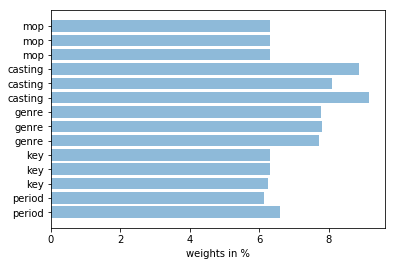

ERR: 0.04740375779642871


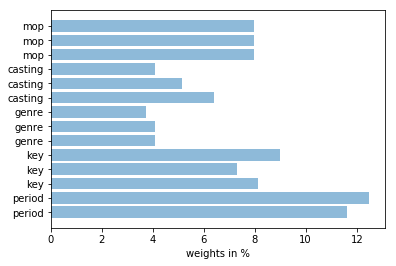

ERR: 0.00013260409054756446


ERR: 3.39529649453069e-05


ERR: 3.416989780553017e-05


ERR: 0.04807745110604472


ERR: 7.560799536565331e-05


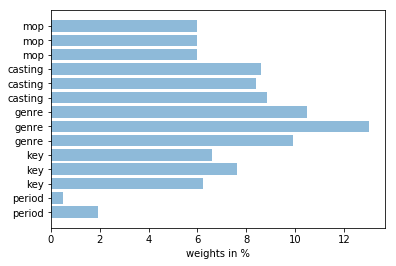

ERR: 0.00019506143164424694


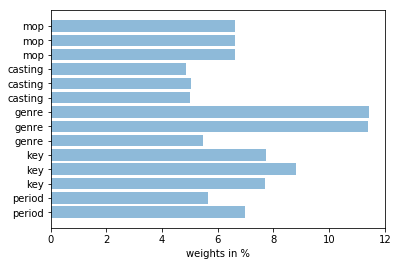

ERR: 0.049708713077243206


ERR: 0.18830082542904272


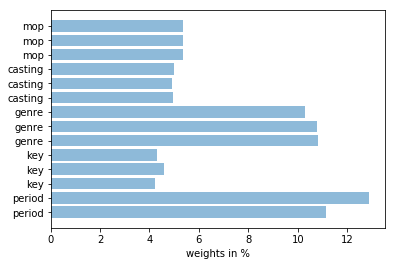

ERR: 0.06250293705247457


ERR: 1.0234891242317418e-06


ERR: 3.749702897606963e-05


ERR: 6.134825435527248e-05


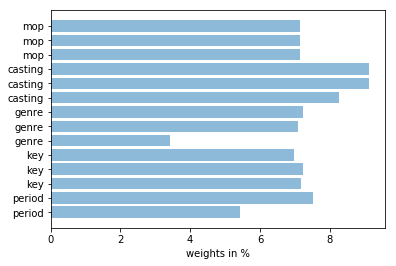

ERR: 0.3294140159551447


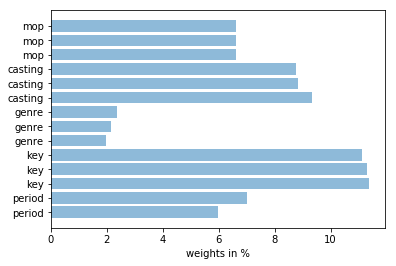

ERR: 0.05108116264068383


ERR: 0.048335556753234296


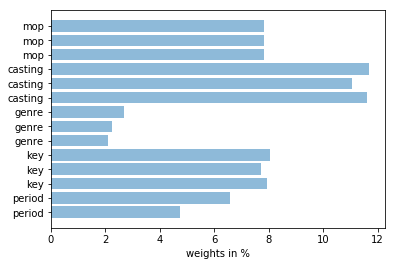

ERR: 4.177800342338421e-05


ERR: 5.7371926633018563e-05


ERR: 0.9598344514057262


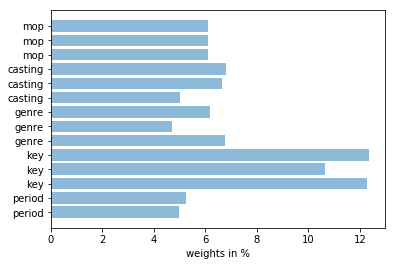

ERR: 6.14279322860108e-05


ERR: 0.18647790740135048


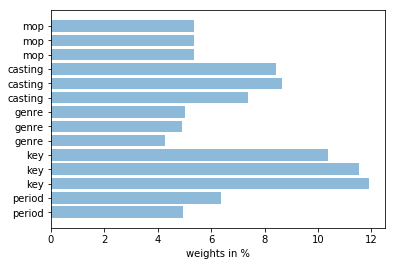

ERR: 9.777994858636591e-05


ERR: 0.00014920451319151592


ERR: 0.0507376411868089


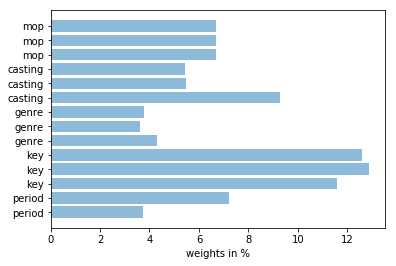

ERR: 0.3310672390955022


ERR: 0.0002669676633372505


ERR: 0.18652947716404986


ERR: 0.19224750890449502


ERR: 3.527272432724181e-05


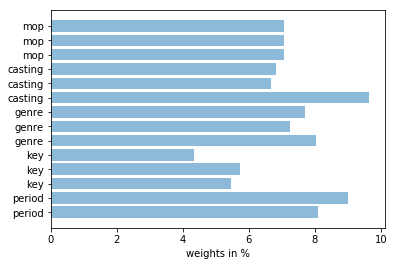

ERR: 0.188908523266915


ERR: 1.0


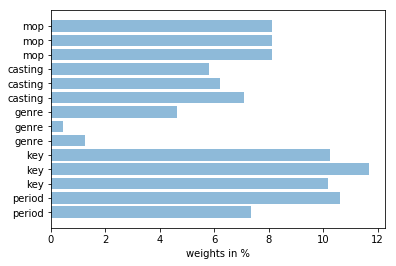

ERR: 0.04870986035583103


ERR: 0.0002830531292486886


ERR: 2.3972416018036582e-05


ERR: 0.00010163758817670899


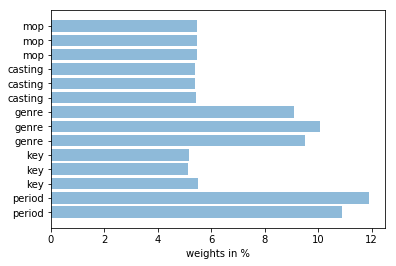

ERR: 0.00017906533127428056


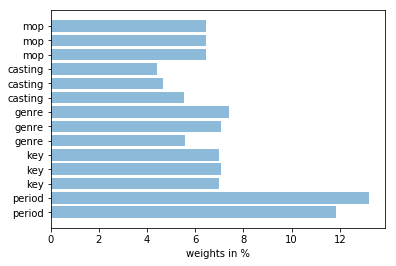

ERR: 4.523494088788875e-05


ERR: 0.0004563529656948441


ERR: 0.0


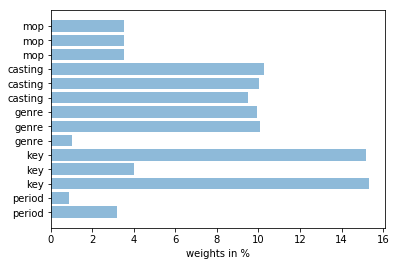

ERR: 0.6105275288130042


ERR: 0.021839071763088084


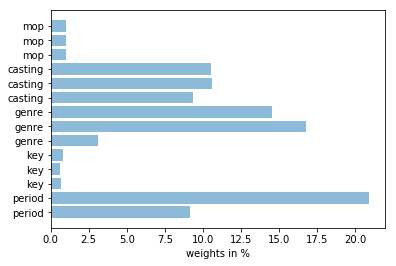

ERR: 0.0


ERR: 8.315821506325677e-05


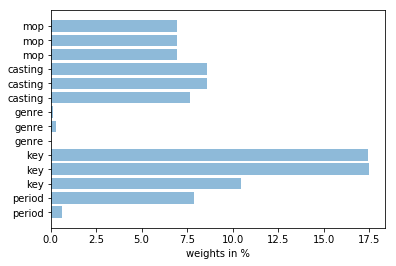

ERR: 4.035292047153361e-05


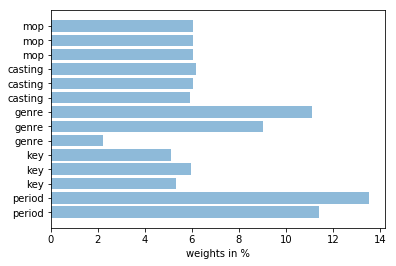

ERR: 9.638868826403928e-05


ERR: 0.00016828987469614103


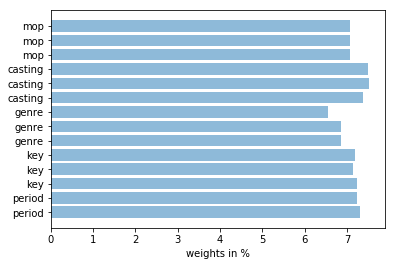

ERR: 5.730386262782221e-05


ERR: 0.1858760981266018


ERR: 0.05037862805220823


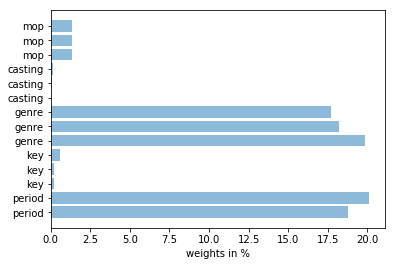

ERR: 0.41585788770674237


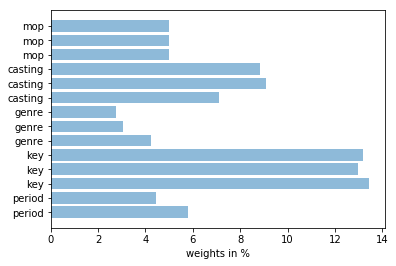

ERR: 0.051773507961949294


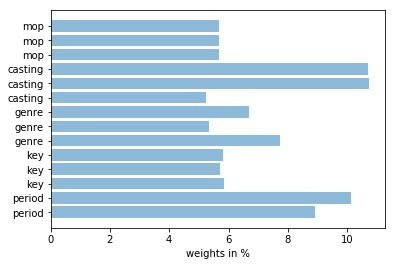

ERR: 0.9949588850161192


ERR: 0.00046520531187562515


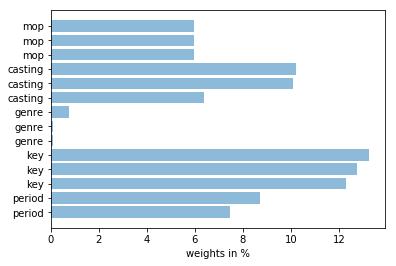

ERR: 0.00030450698651841857


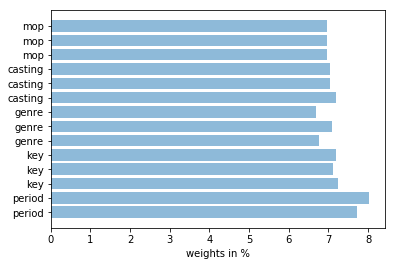

ERR: 0.04823485536174313


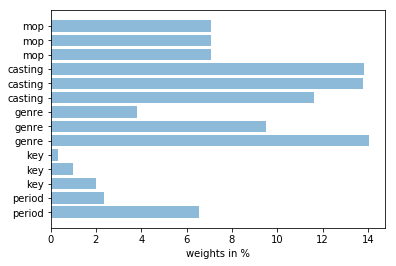

ERR: 0.0002083022088005411


ERR: 0.00012976589510487412


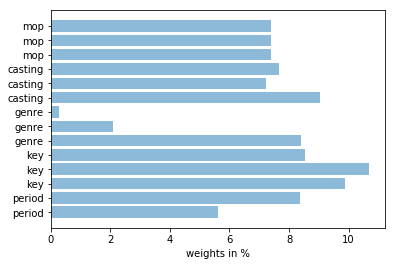

ERR: 5.933465611314591e-05


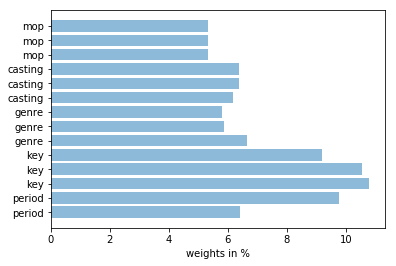

ERR: 0.00013205586210264988


ERR: 0.00011975721158840015


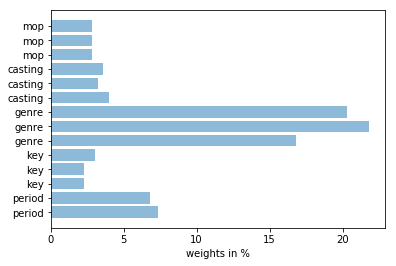

ERR: 2.2114678731929867e-05


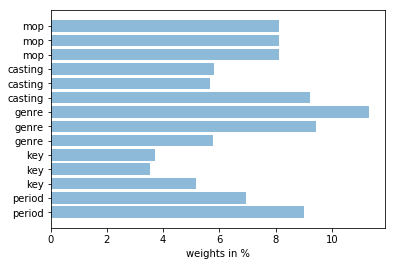

ERR: 6.954613882946637e-05


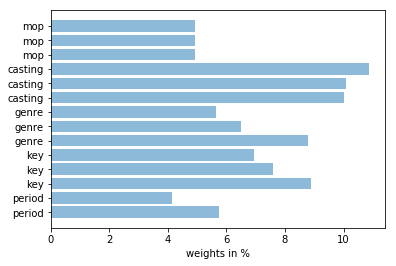

ERR: 0.0001314540381458303


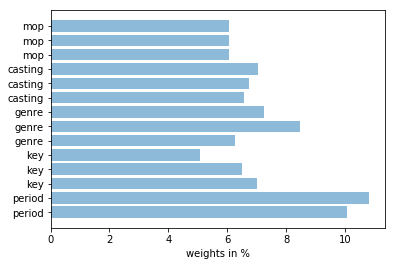

ERR: 6.412645152892424e-05


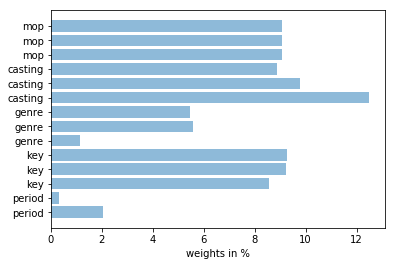

ERR: 0.00021816499913063437


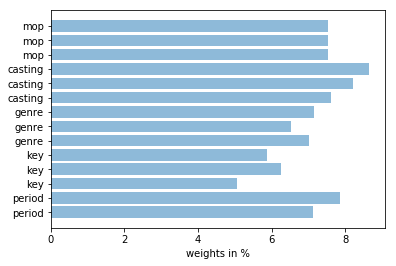

ERR: 0.416285161827847


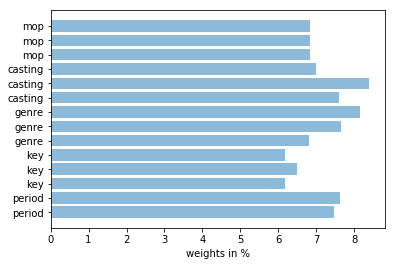

ERR: 0.00017774877983364146


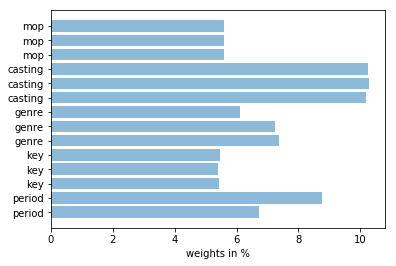

ERR: 0.3356913300833451


ERR: 5.9930952226590944e-05


ERR: 0.25


ERR: 2.5152426950530786e-05


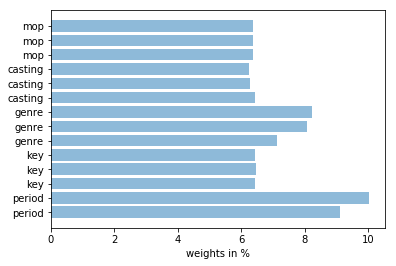

ERR: 0.00021458155554165834


ERR: 0.18692783178245995


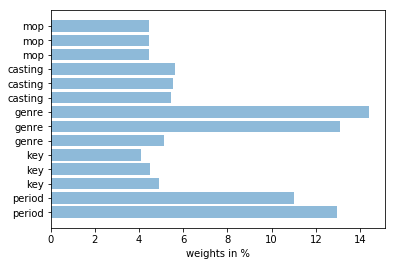

ERR: 0.00024351324043380578


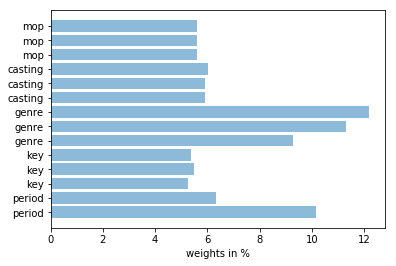

ERR: 0.00039930819202116526


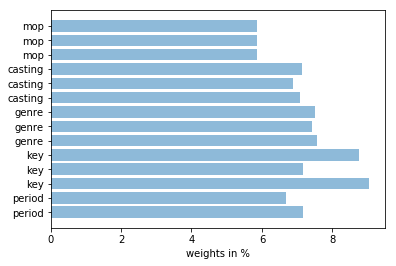

ERR: 9.540392786825858e-06


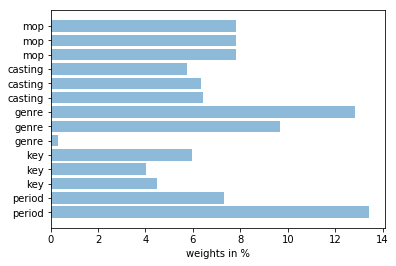

ERR: 0.00014241676532791416


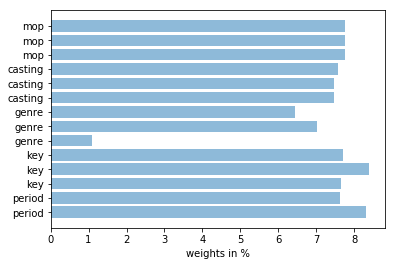

ERR: 0.00027322871153955826


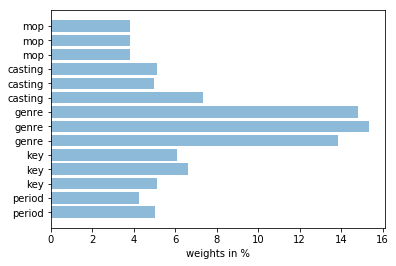

ERR: 0.6173469387755102


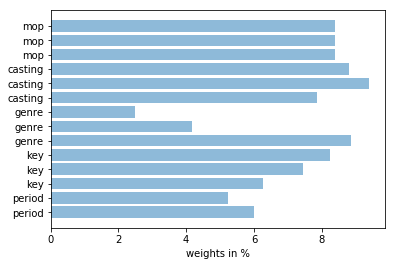

ERR: 2.2634025879453285e-05


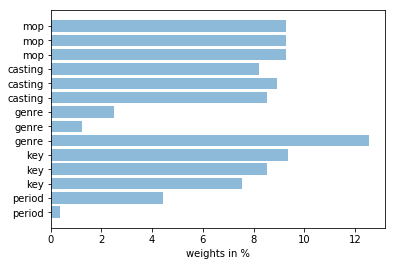

ERR: 5.432231208515413e-05


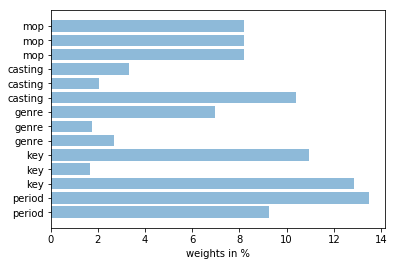

ERR: 0.05303199070750642


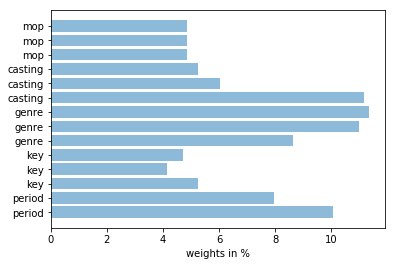

ERR: 0.04996783783028688


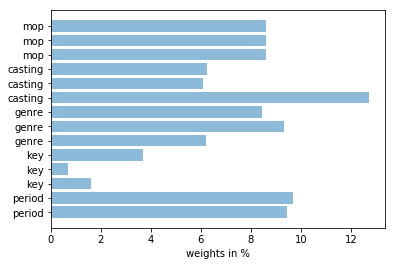

ERR: 3.253704296545327e-05


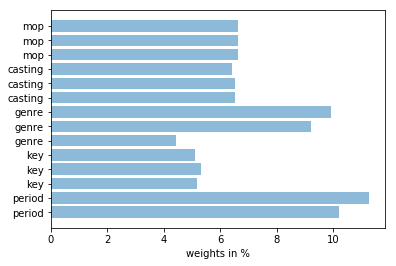

ERR: 0.9625011846582643


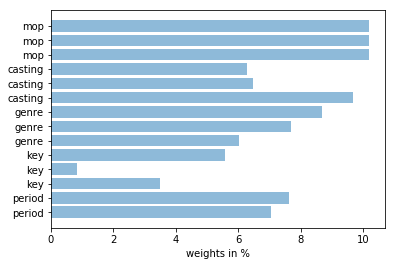

ERR: 1.033891895774798e-05


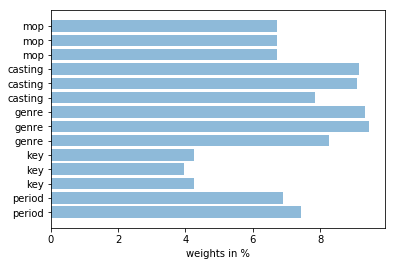

ERR: 0.00012597885925810283


ERR: 0.00041310549787914404


ERR: 0.006404635245804786


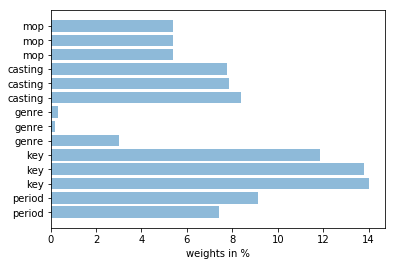

ERR: 0.5132358480053878


ERR: 0.0002634390561535302


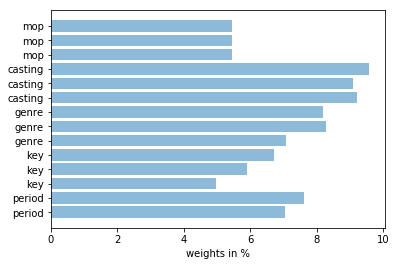

ERR: 6.982408428424176e-05


ERR: 0.00018258508273525783


ERR: 2.7699166887518375e-05


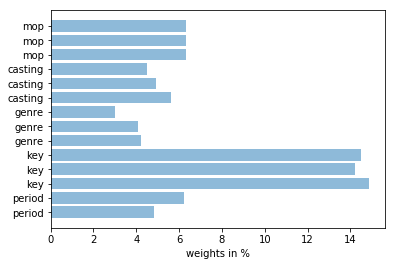

ERR: 0.049104369096120926


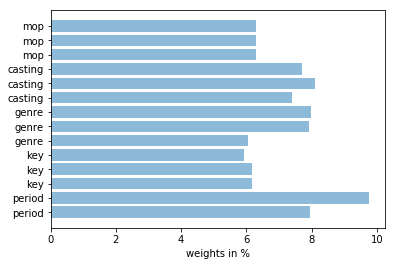

ERR: 0.1339762601448108


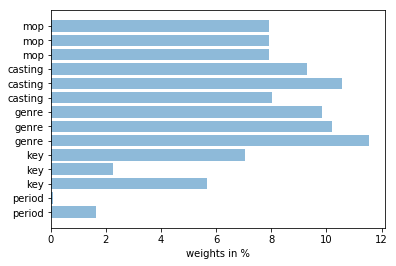

ERR: 0.18803980566814313


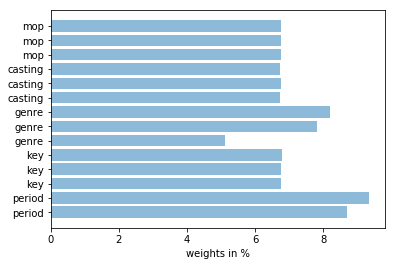

ERR: 1.0193522936983884e-05


ERR: 3.755386028867771e-05


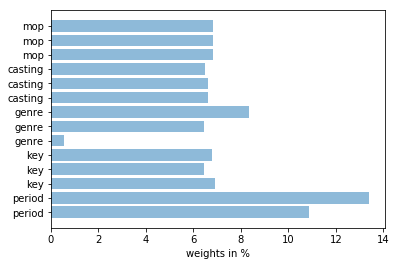

ERR: 0.6173469387755102


ERR: 0.00019401585408341314


ERR: 0.05006033208785276


ERR: 0.05097049240295958


ERR: 5.4586516017523255e-05


ERR: 0.00011516780655582774


ERR: 0.04985978344328705


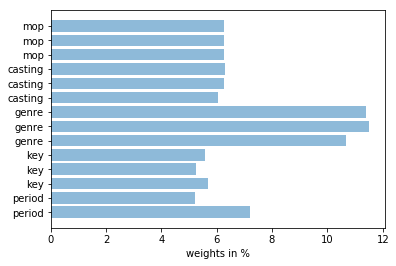

ERR: 5.173337013411315e-05


ERR: 4.652648121341092e-05


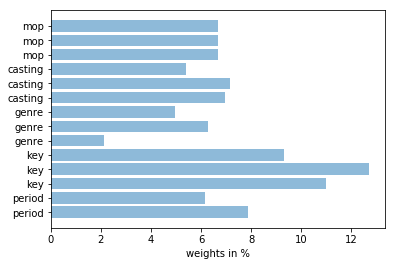

ERR: 0.00010861170246662695


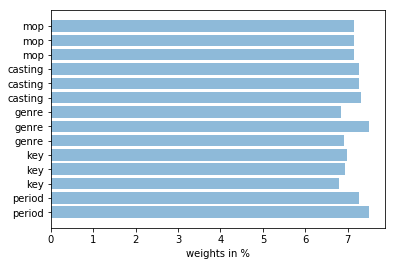

ERR: 0.00010618377829077381


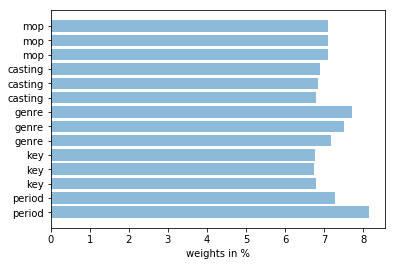

ERR: 9.923565388910118e-06


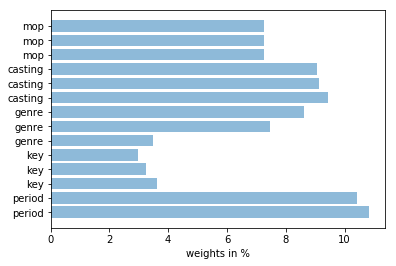

ERR: 1.2837478990268462e-05


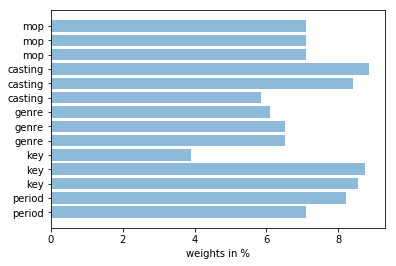

ERR: 0.0


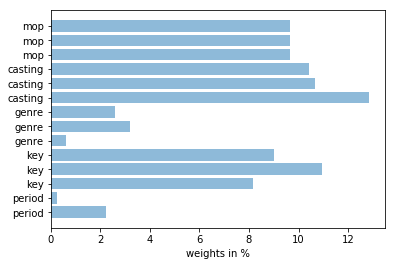

ERR: 0.00016480656973469514


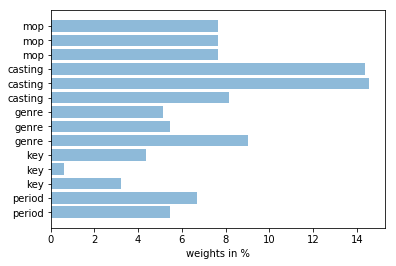

ERR: 0.18950036466275086


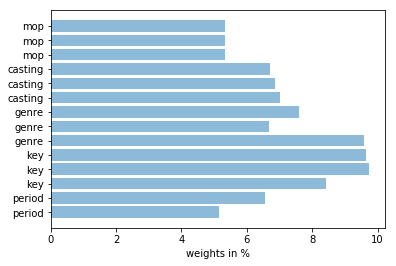

ERR: 2.9444485118549005e-05


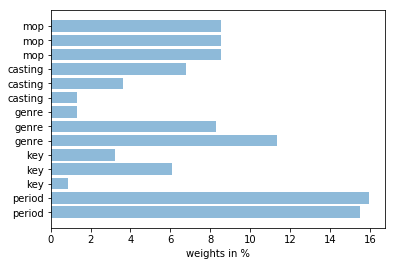

ERR: 1.795359950442347e-05


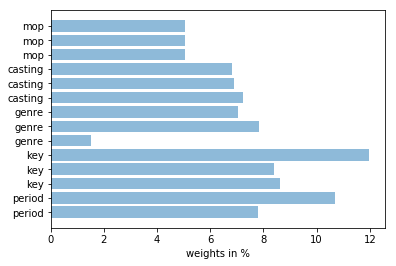

ERR: 0.18702563329057761


ERR: 7.192711478831369e-05


ERR: 6.187018392716251e-05


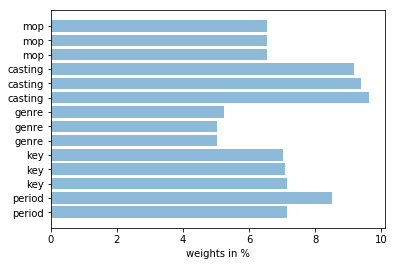

ERR: 0.18570349166858624


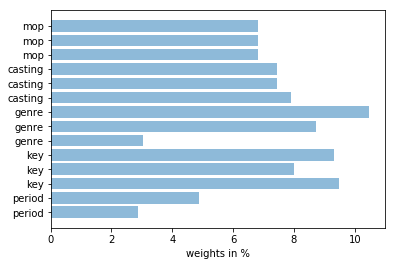

ERR: 8.386972651439875e-05


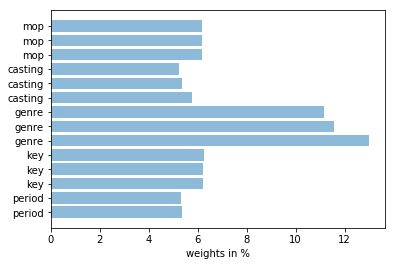

ERR: 9.075238844641284e-05


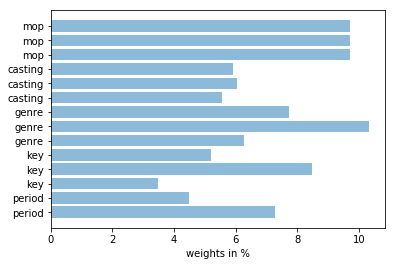

ERR: 0.005480521622486938


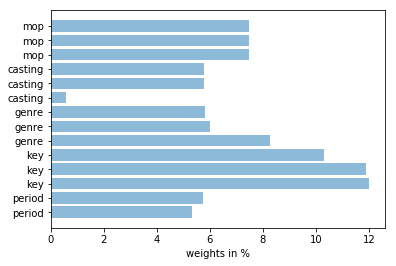

ERR: 3.3284324705036018e-06


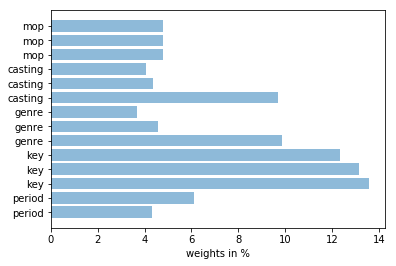

ERR: 0.00015242147893647205


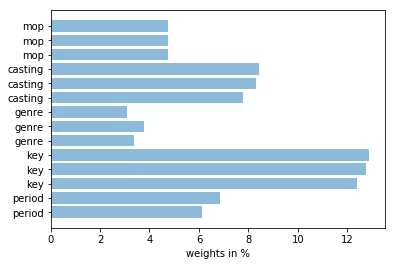

ERR: 0.00031311694673278803


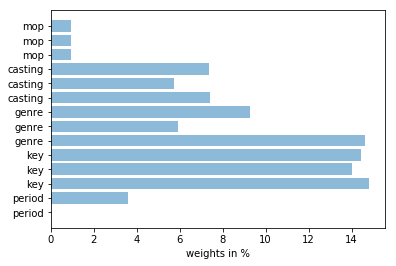

ERR: 2.501685672422155e-05


ERR: 0.12990362312508558


ERR: 0.0002925916812961249


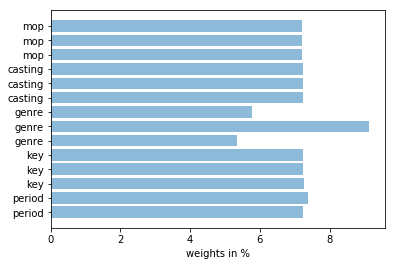

ERR: 0.19501409936870412


ERR: 0.00012476485930656612


ERR: 9.468326089186515e-06


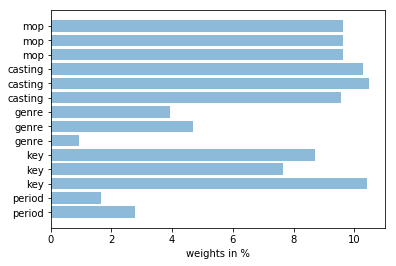

ERR: 0.049059347154455576


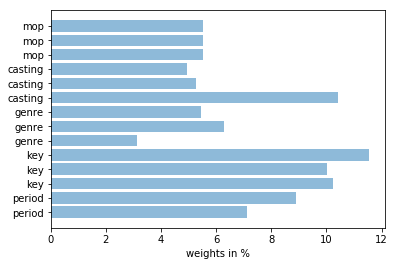

ERR: 0.04834675780033517


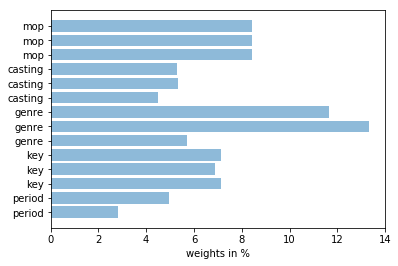

ERR: 0.32653061224489793


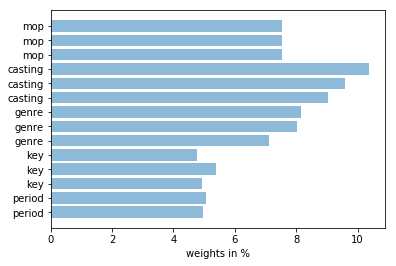

ERR: 5.617437241795825e-05


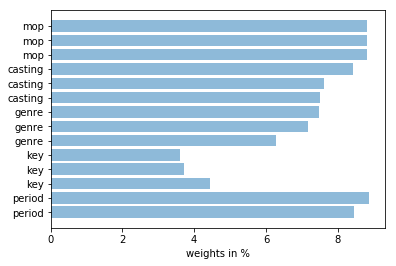

ERR: 0.005239991321564135


ERR: 3.81903361325676e-05


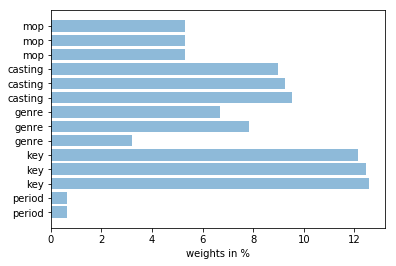

ERR: 7.292445142636755e-05


ERR: 0.4154167491456441


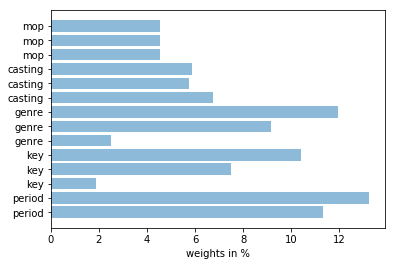

ERR: 0.007294216281741797


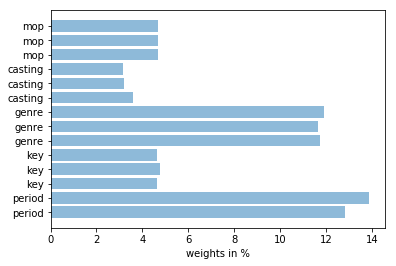

ERR: 2.6823491528805732e-05


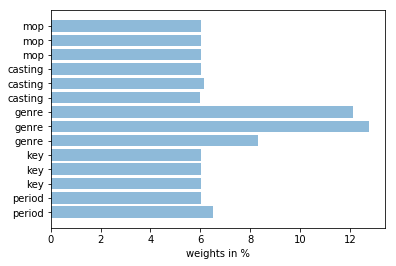

ERR: 0.41556768529363297


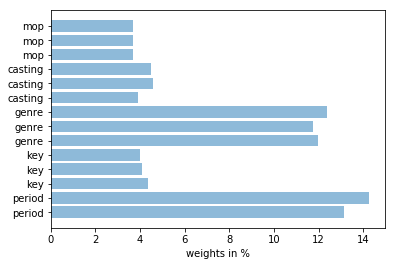

ERR: 0.0004026337503783806


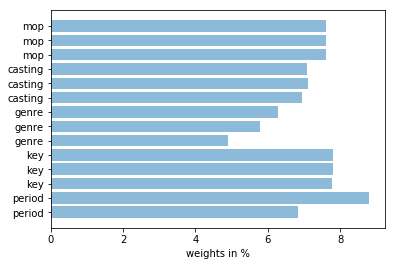

ERR: 0.00023267908945404905


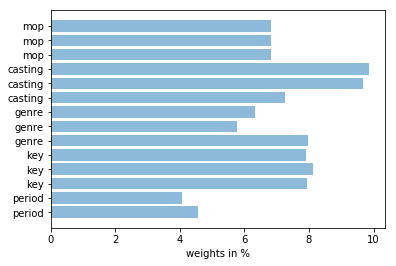

ERR: 5.313099561195997e-05


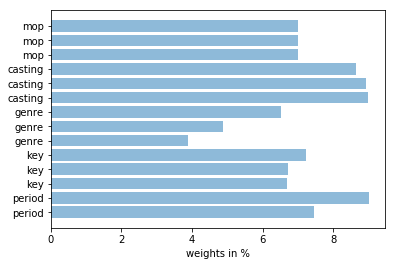

ERR: 0.0003084891490051784


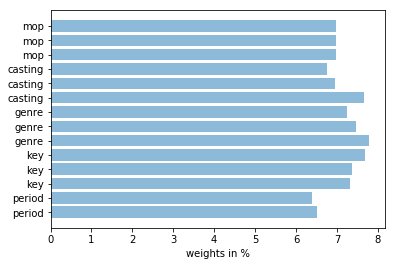

ERR: 0.08522984935016636


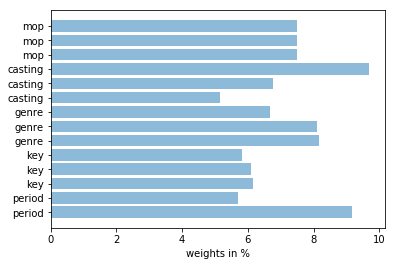

ERR: 3.135369848680924e-05


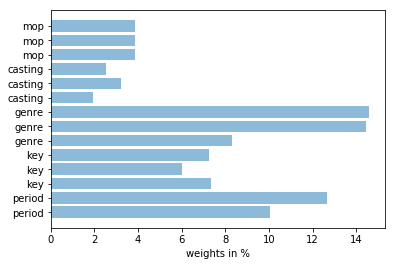

ERR: 0.00015453728355434523


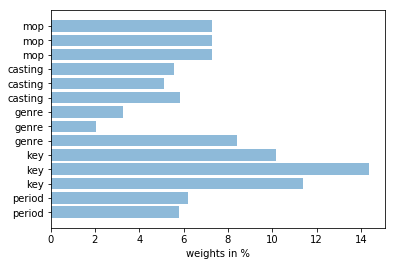

ERR: 6.963412166209298e-05


ERR: 0.0002053900518239389


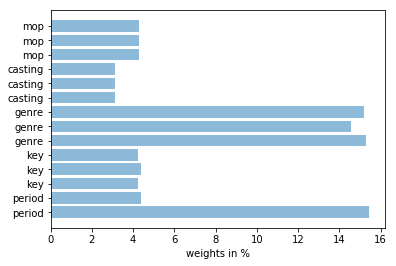

ERR: 0.0


ERR: 8.052046727514957e-05


ERR: 0.08776171859901928


ERR: 0.00015814723455880316


ERR: 9.121339054833794e-06


ERR: 6.622332252774626e-05


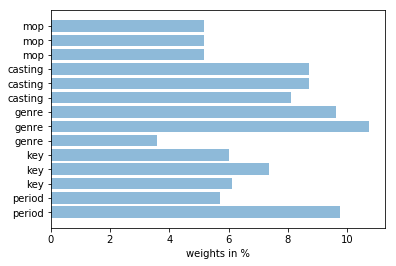

ERR: 4.779740967155962e-05


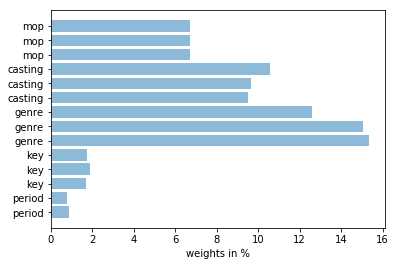

ERR: 0.13096395496125096


ERR: 8.751083735967028e-05


ERR: 0.051645204067783695


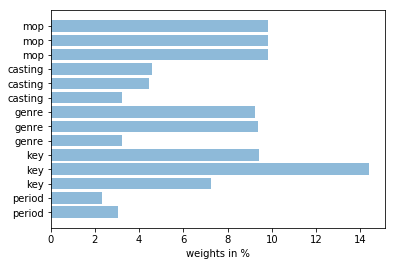

ERR: 0.00012088130430576205


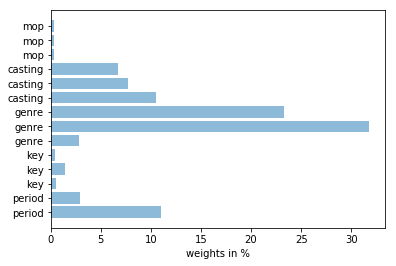

ERR: 1.0316289167377274e-05


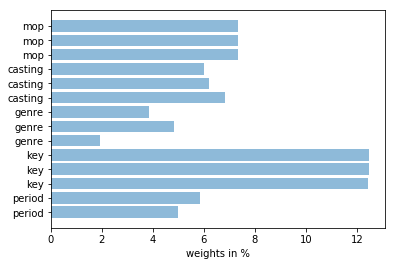

ERR: 0.9772670192468055


ERR: 0.00011618930059037935


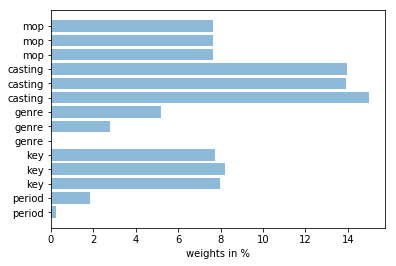

ERR: 7.200887862522008e-05


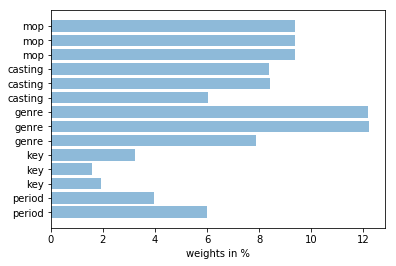

ERR: 4.327314351442897e-05


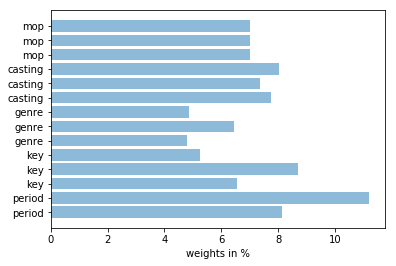

ERR: 0.1904716920587231


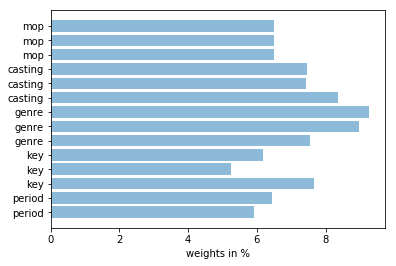

ERR: 0.000285389895083976


ERR: 5.377112931092135e-05


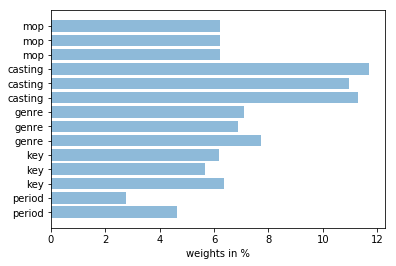

ERR: 0.0003025160033150994


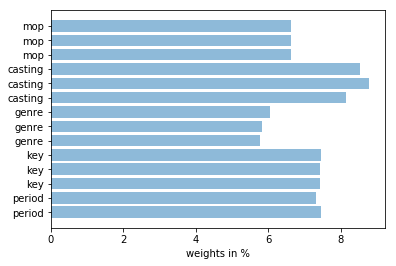

ERR: 0.0


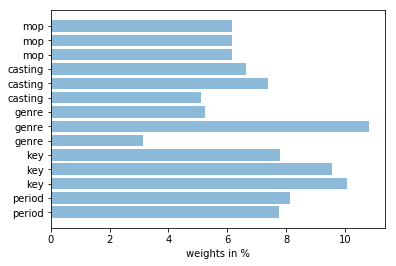

ERR: 0.0004662724952265742


ERR: 5.2808337338636686e-05


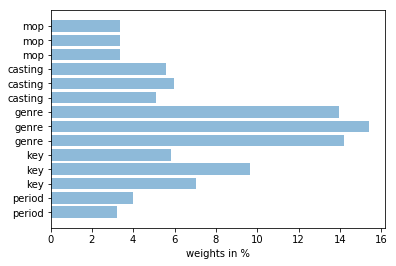

ERR: 0.0003899349256761402


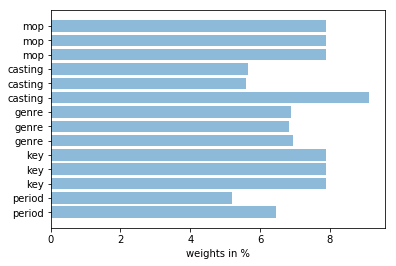

ERR: 6.103723179837999e-05


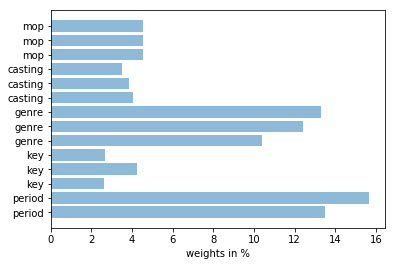

ERR: 4.629119419937246e-05


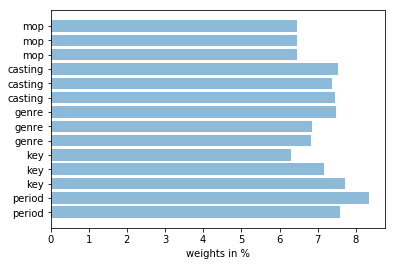

ERR: 0.0001343825016689314


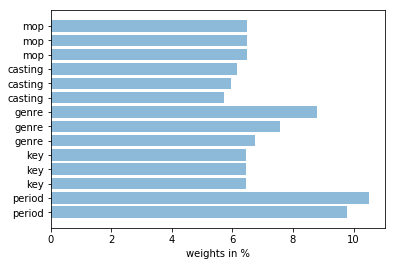

ERR: 0.00015532174508502464


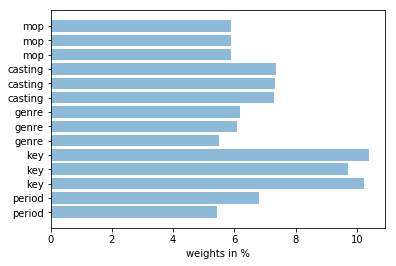

ERR: 0.00018257944589462912


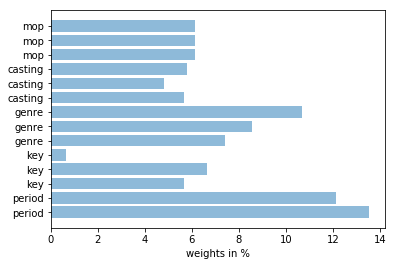

ERR: 0.04690695256874573


ERR: 0.00017319290437655785


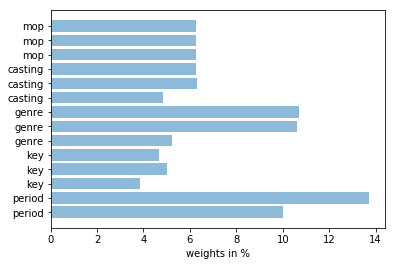

ERR: 1.5067032461680279e-05


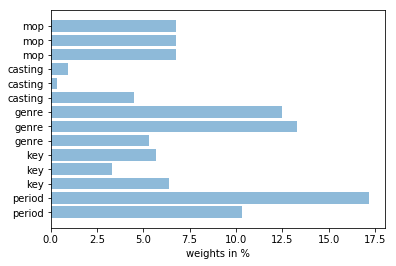

ERR: 0.0003090405792066415


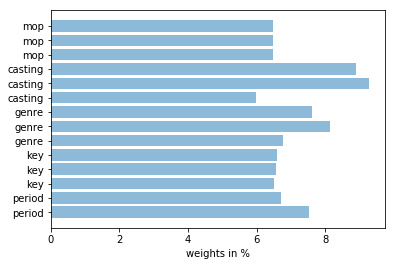

ERR: 1.3336480773365718e-05


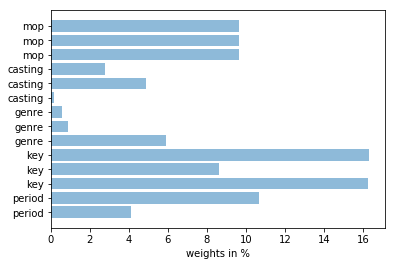

ERR: 5.799944011924598e-05


ERR: 0.00025017149057725193


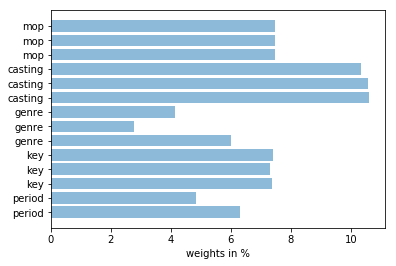

ERR: 0.04790990686636726


ERR: 8.123419235525794e-05


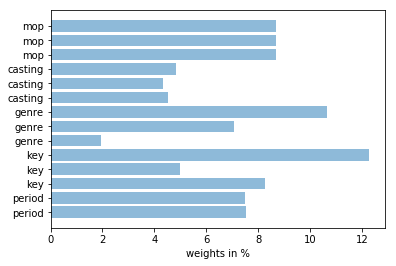

ERR: 0.05052791927541262


ERR: 0.048000224974074086


ERR: 5.3994084509163114e-05


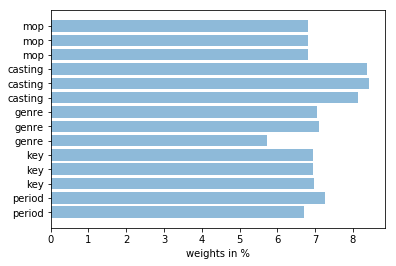

ERR: 2.161909314533236e-05


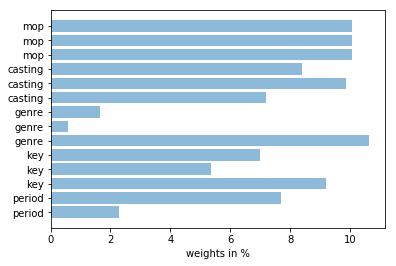

ERR: 0.3331058741785921


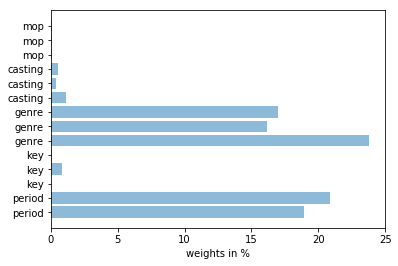

ERR: 3.2600219624662437e-05


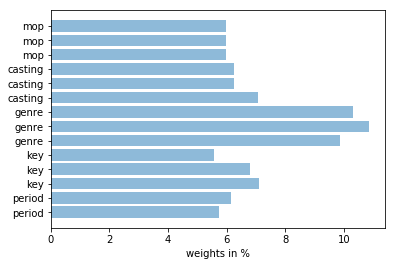

ERR: 0.0004427487529892835


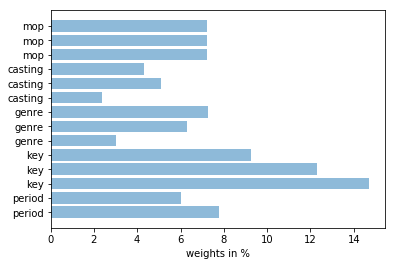

ERR: 0.0002028023836412468


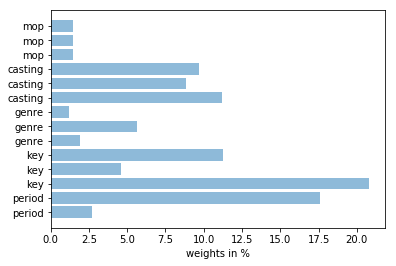

ERR: 9.71464015319965e-05


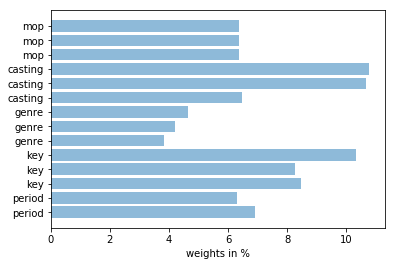

ERR: 0.00013237192873887706


ERR: 1.8220545343175668e-06


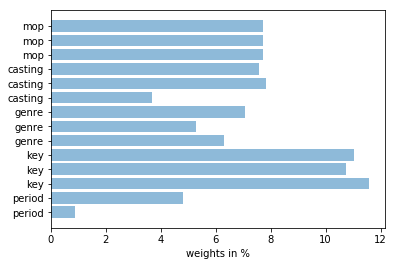

ERR: 0.18533899859758196


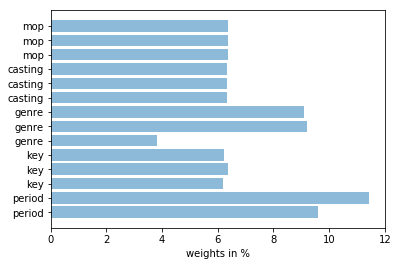

ERR: 0.32784044337172086


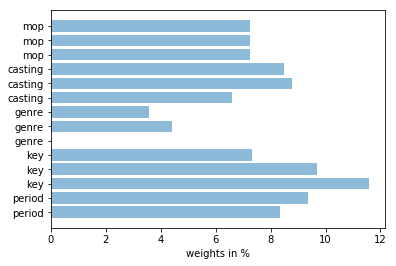

ERR: 0.18877117590873776


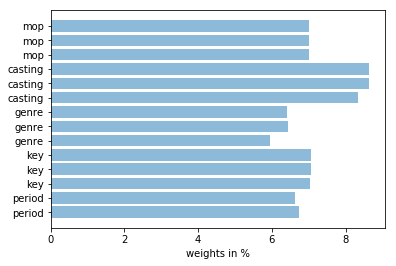

ERR: 0.050202412453165375


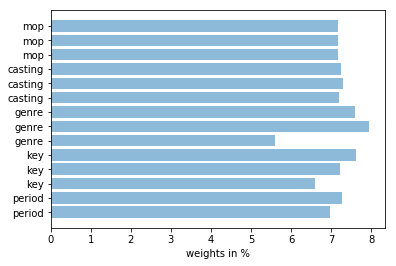

ERR: 3.8554431140254104e-05


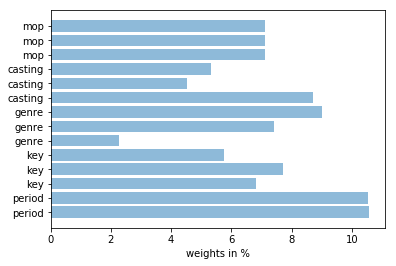

ERR: 3.769887811631886e-05


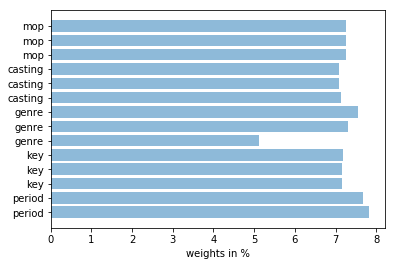

ERR: 0.18884319923158893


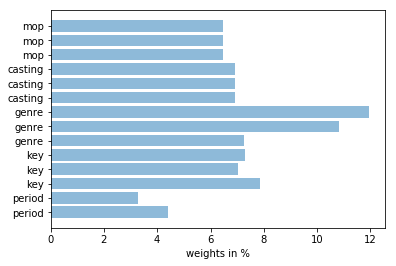

ERR: 0.000959761431766542


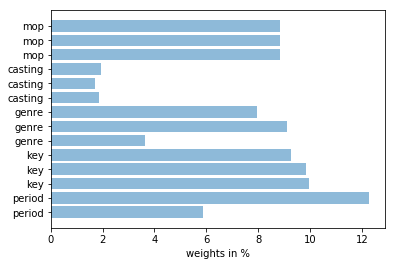

ERR: 2.5781216501047293e-05


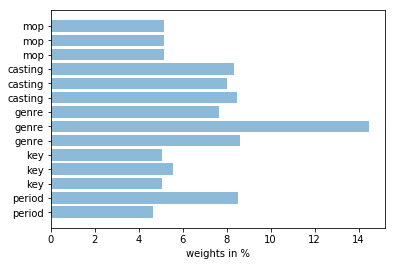

ERR: 0.04803633573328984


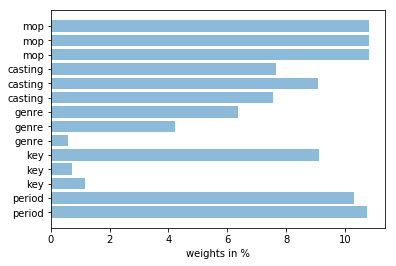

ERR: 0.0002003646243047426


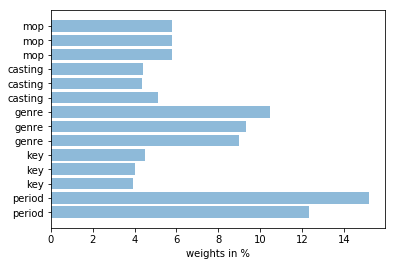

ERR: 0.1876767605165768


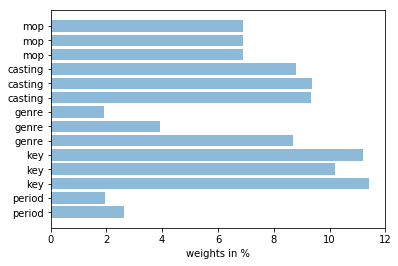

ERR: 5.454786252730651e-06


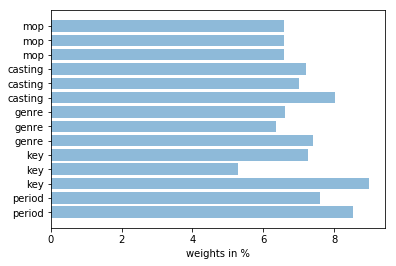

ERR: 3.077532714423764e-05


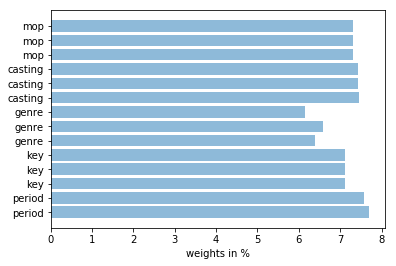

ERR: 0.04982739423811106


ERR: 0.0008144180138943913


ERR: 0.00013444323002652524


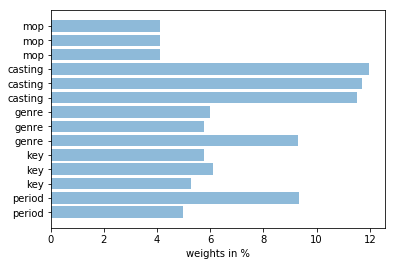

ERR: 0.0003312719890491712


ERR: 0.00011571440741064467


ERR: 0.04772586935785554


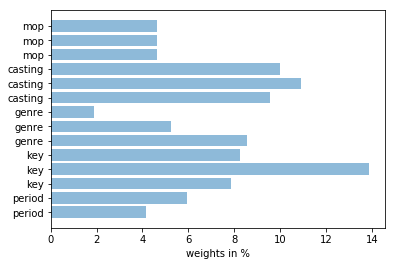

ERR: 2.7330567532909307e-05


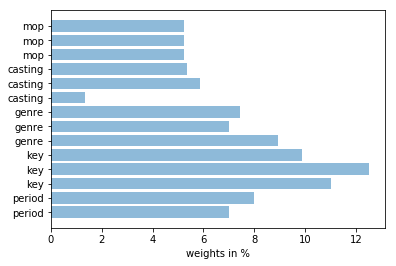

ERR: 6.523836105160024e-06


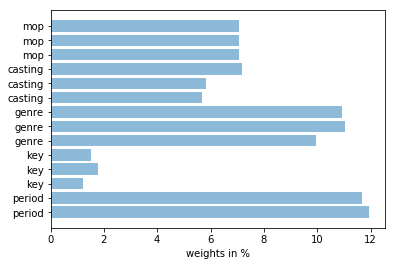

ERR: 0.0001305972051838616


ERR: 0.00010679944279024191


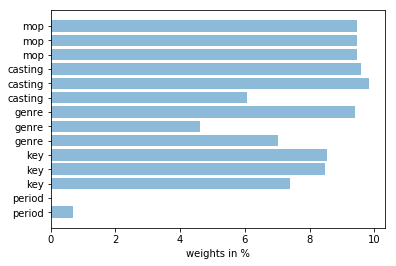

ERR: 0.253745302040094


ERR: 6.051854033642472e-05


ERR: 0.04846528459414876


ERR: 0.00010641212722830729


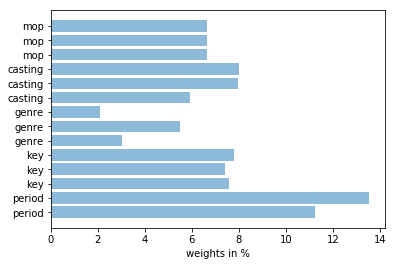

ERR: 9.619105026580804e-05


ERR: 5.5561844966334754e-05


ERR: 0.04891175795925169


ERR: 0.00040410829808136685


ERR: 2.9093996714772922e-05


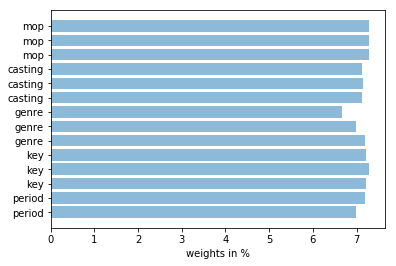

ERR: 0.00013095150352262111


ERR: 0.04972499515637309


ERR: 0.04843790001917061


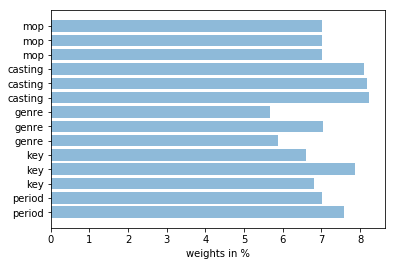

ERR: 2.7986334368701227e-05


ERR: 8.212290559698521e-06


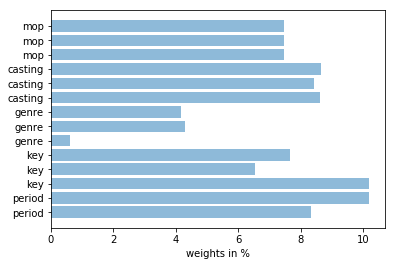

ERR: 0.04851120878126312


ERR: 0.12927223778060126


ERR: 0.00010521546871225561


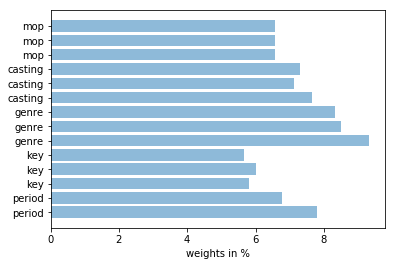

ERR: 9.498722070452702e-05


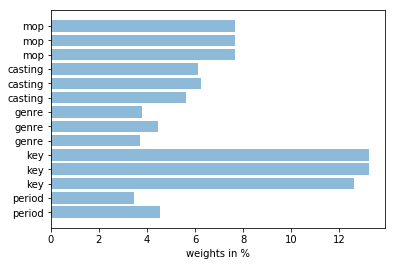

ERR: 0.00028788494195578087


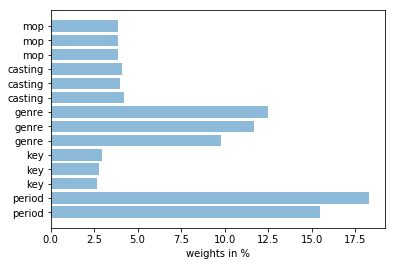

ERR: 0.000585013542502881


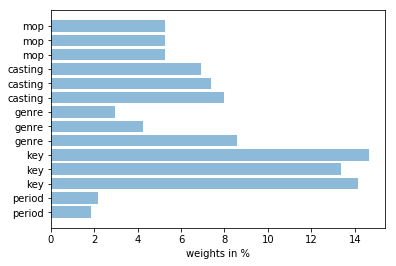

ERR: 0.050108868948817484


ERR: 0.005280500689578232


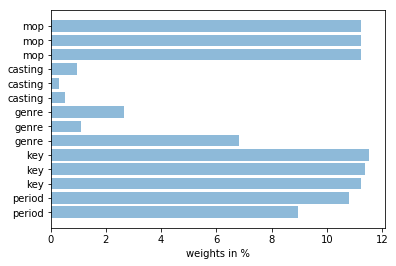

ERR: 5.0438487367413774e-05


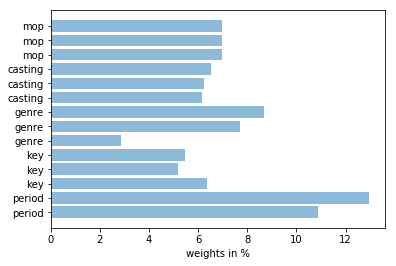

ERR: 0.05017816005442135


ERR: 0.6106080509566734


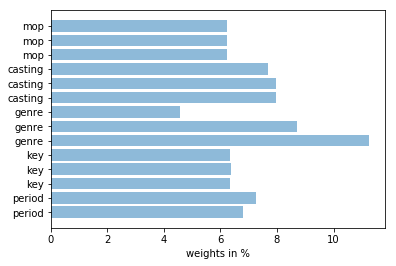

ERR: 6.128467063034259e-05


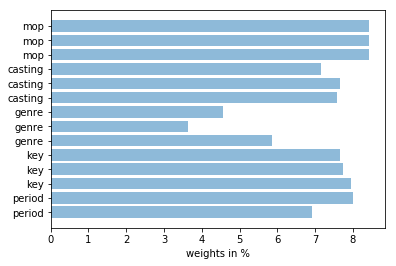

ERR: 0.190847094043574


ERR: 0.006542891394531763


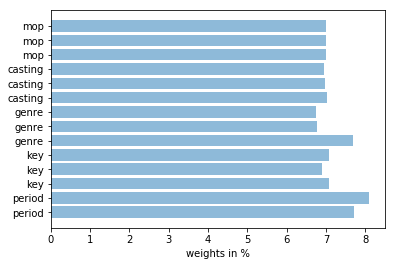

ERR: 1.8281230811242894e-05


ERR: 7.970000444105635e-07


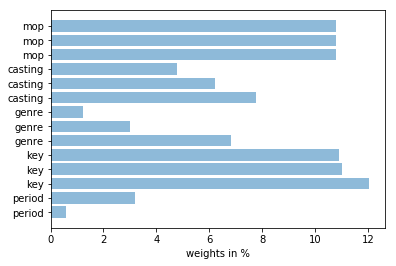

ERR: 0.0001705133684668346


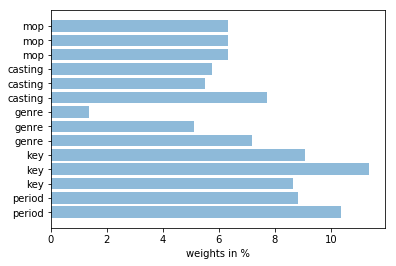

ERR: 1.466535557592046e-07


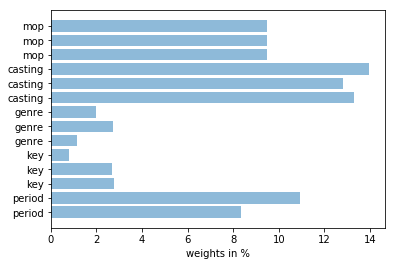

ERR: 0.05094296913948941


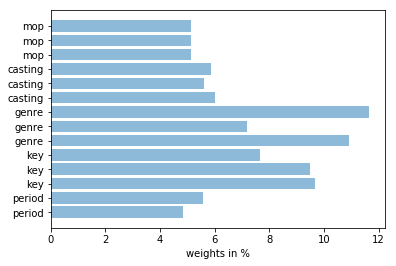

ERR: 0.049631547956435526


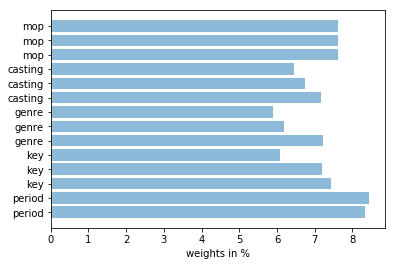

ERR: 0.0003659158020401249


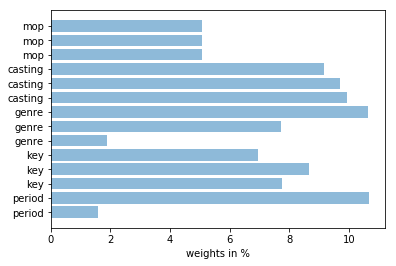

ERR: 0.0074113438574788925


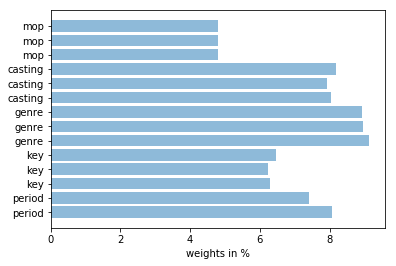

ERR: 6.840357537865812e-05


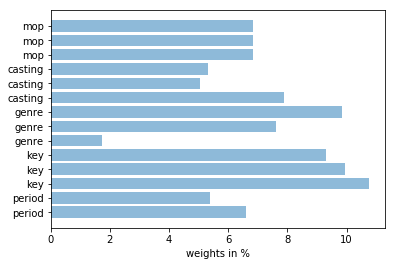

ERR: 0.049279904068347286


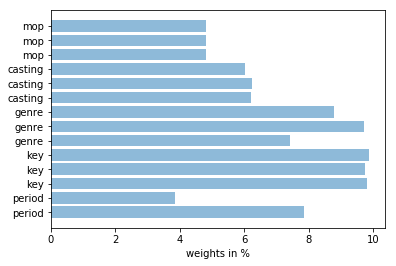

ERR: 7.011558417051078e-05


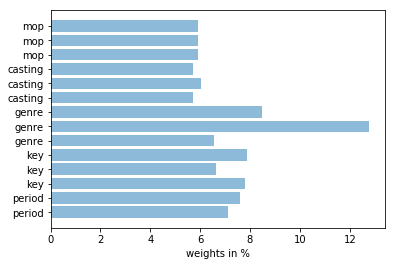

ERR: 0.047874641361553


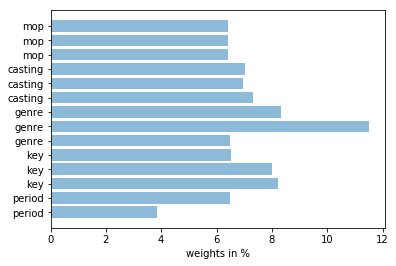

ERR: 0.08692310117429766


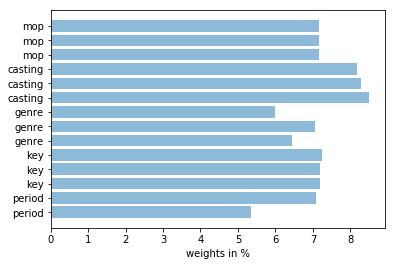

ERR: 7.876175650316373e-05


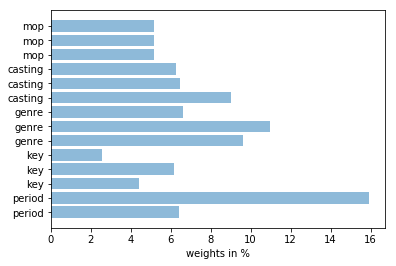

ERR: 0.1854995190705116


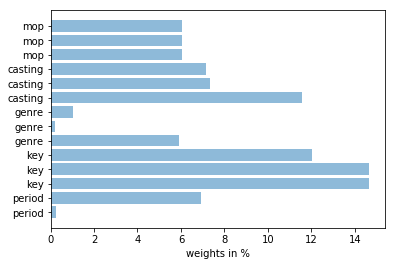

ERR: 4.759248957649329e-06


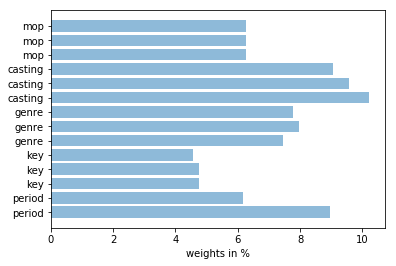

ERR: 0.9796236759468689


ERR: 0.000283613605566932


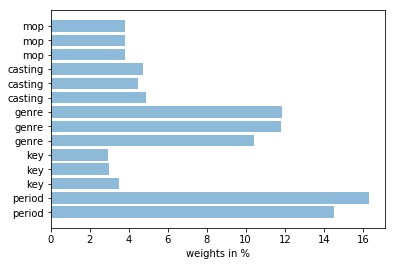

ERR: 0.0062210784735109445


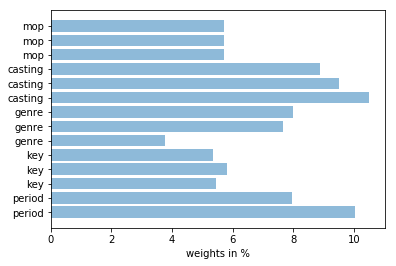

ERR: 5.340591846774834e-05


ERR: 0.0005400732322149016


ERR: 7.059372971476784e-05


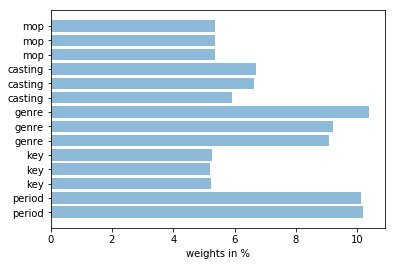

ERR: 0.0


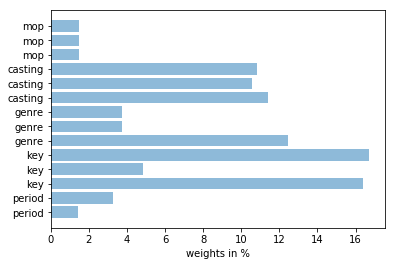

ERR: 0.048774378004801215


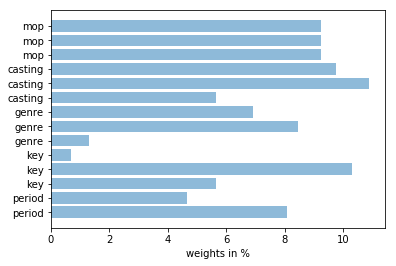

ERR: 0.0


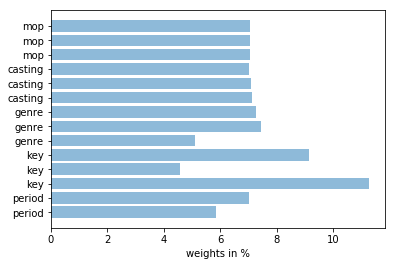

ERR: 0.132449756088096


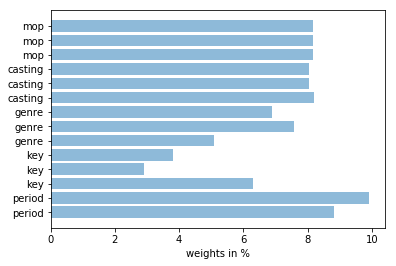

ERR: 3.534890777211858e-05


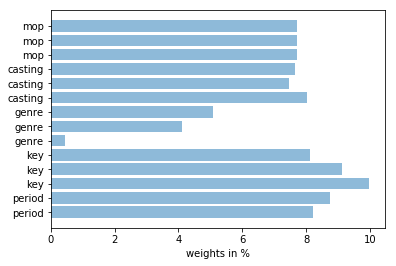

ERR: 7.647862088616915e-06


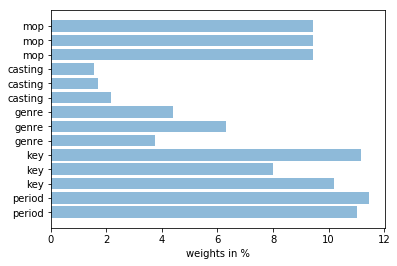

ERR: 4.5385605084644424e-05


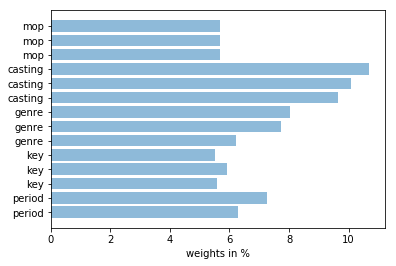

ERR: 0.006086383257560673


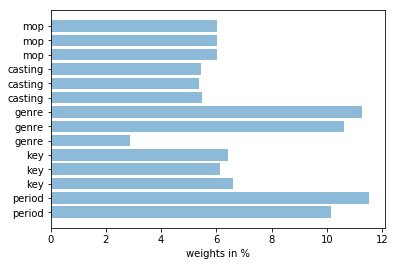

ERR: 0.04822086383796761


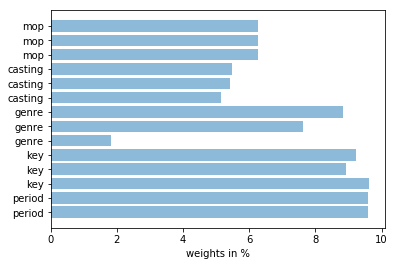

ERR: 0.00010697546314881846


ERR: 2.214512893482938e-05


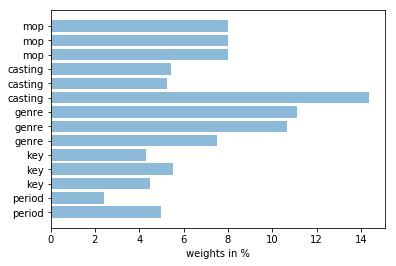

ERR: 0.0003174108014338591


ERR: 5.199089751179376e-05


ERR: 0.049310358110394574


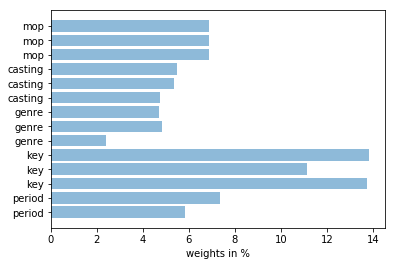

ERR: 0.08530129507286109


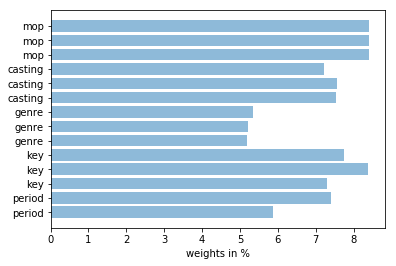

ERR: 0.00011232302556074458


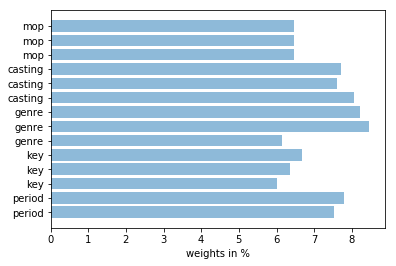

ERR: 0.00018393372215475202


ERR: 0.41794160555874565


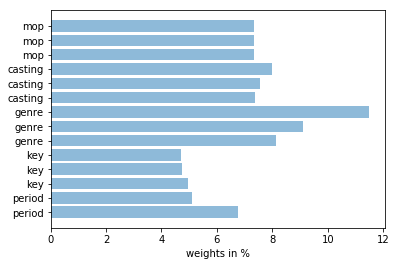

ERR: 0.00013269192045084973


ERR: 0.9664957712317943


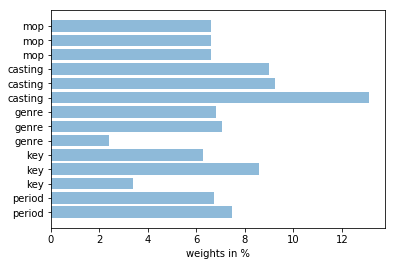

ERR: 4.423711497488626e-05


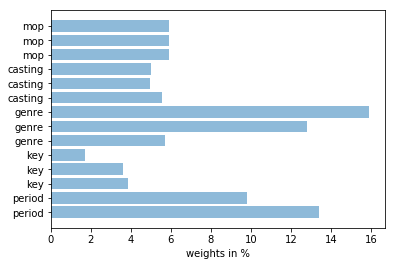

ERR: 0.1298978281200235


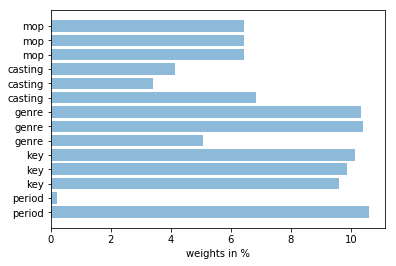

ERR: 0.0001442025368261115


ERR: 0.04965162172758272


ERR: 4.579522286235726e-05


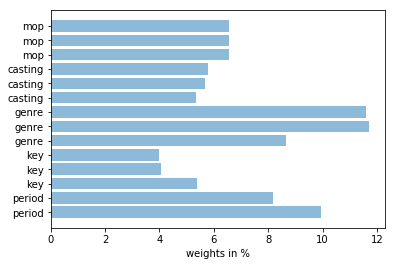

ERR: 3.392769650122376e-05


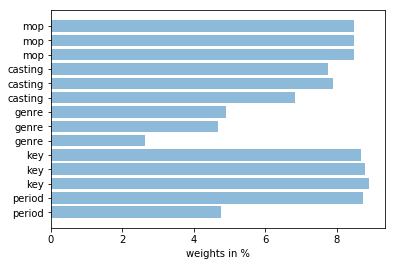

ERR: 0.00011254306438981428


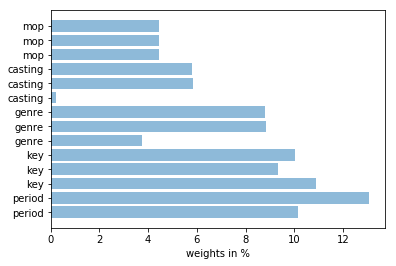

ERR: 3.0941084488727626e-05


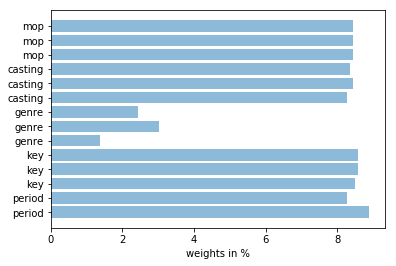

ERR: 0.04929022864202435


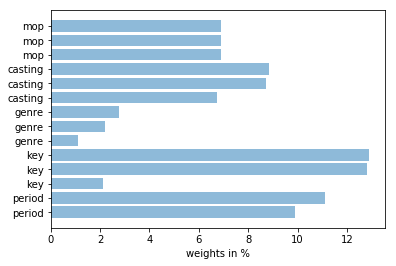

ERR: 0.32653061224489793


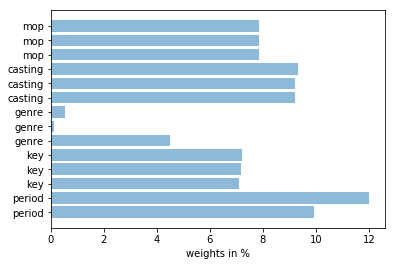

ERR: 0.00013017600690968373


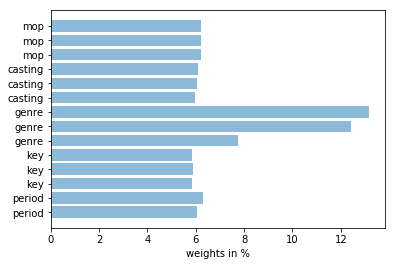

ERR: 0.00011677553253052637


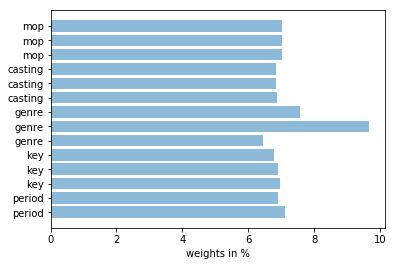

ERR: 0.04719717819155022


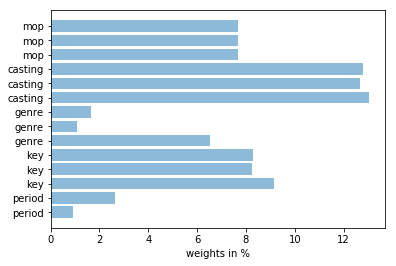

ERR: 1.4211507703048878e-05


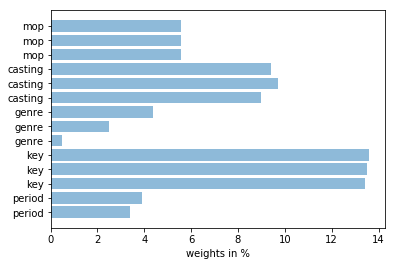

ERR: 8.131738527069567e-05


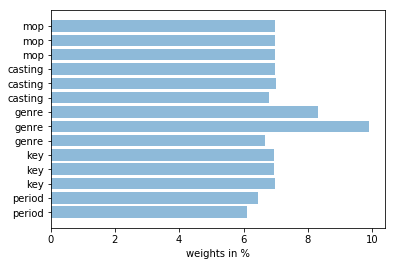

ERR: 2.1043869874764703e-05


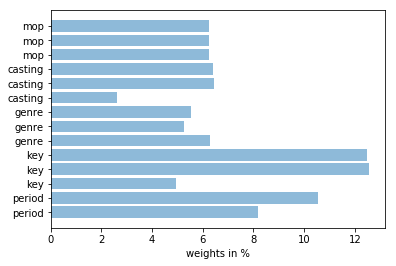

ERR: 0.04851241828010869


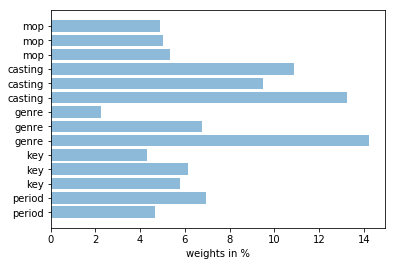

ERR: 0.005853708419735511


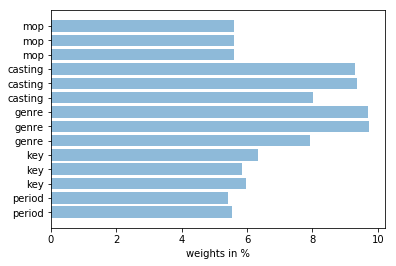

ERR: 3.4828213715052985e-05


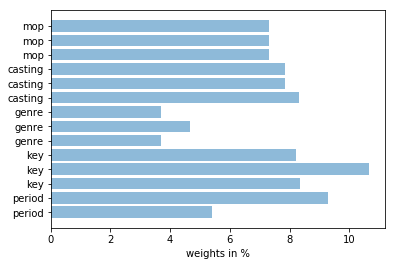

ERR: 0.04942715289127985


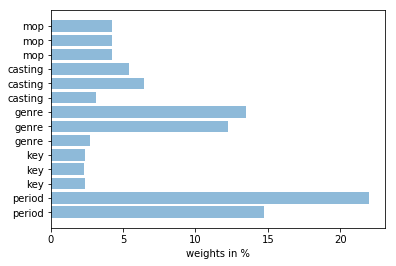

ERR: 0.00021297152962348833


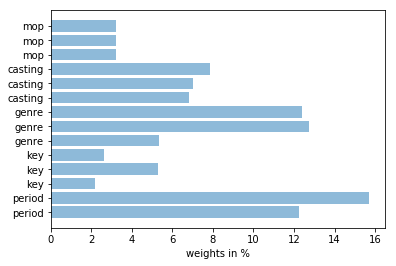

ERR: 8.585789979197512e-06


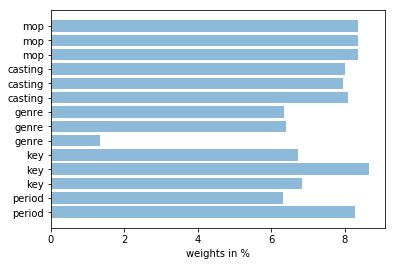

ERR: 6.222746731838878e-05


ERR: 0.00017537039275716598


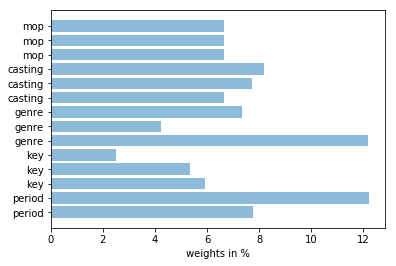

ERR: 0.04788506630986786


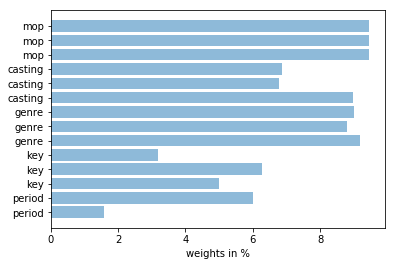

ERR: 0.18691743982479506


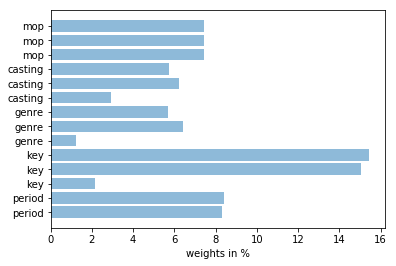

ERR: 0.0006445279543337175


ERR: 0.00023415163630568364


ERR: 0.0054745770184513555


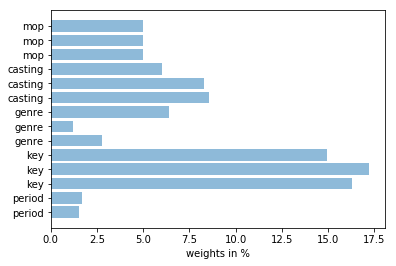

ERR: 9.958213294933525e-05


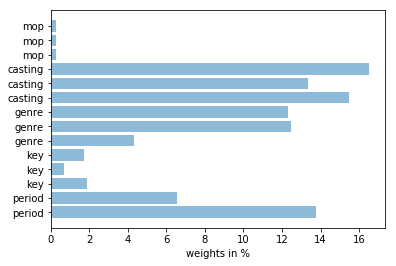

ERR: 0.6189016235418966


ERR: 3.2760165874175714e-05


ERR: 0.0


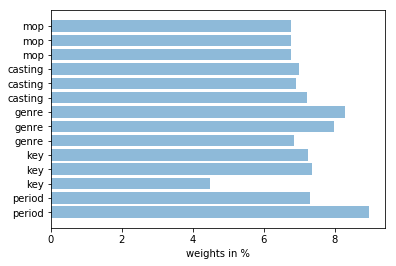

ERR: 1.7826059814738098e-05


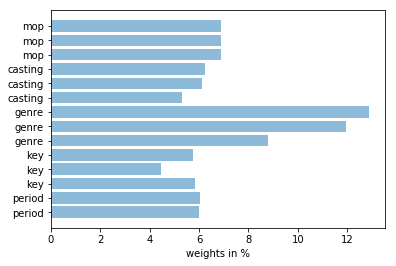

ERR: 1.4578462140389213e-05


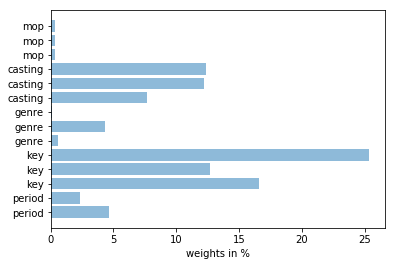

ERR: 0.19085275478812314


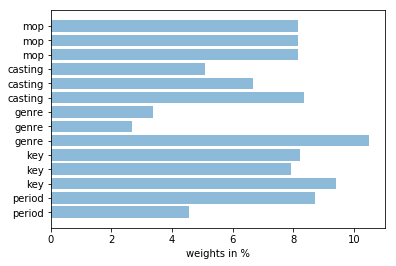

ERR: 0.9843546587065469


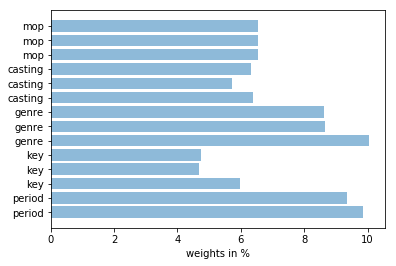

ERR: 0.0478802298633863


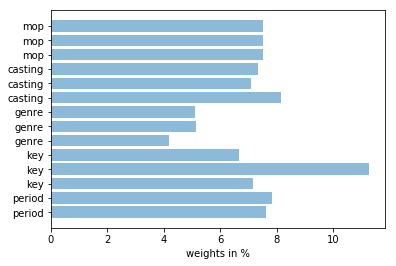

ERR: 0.8549704292639783


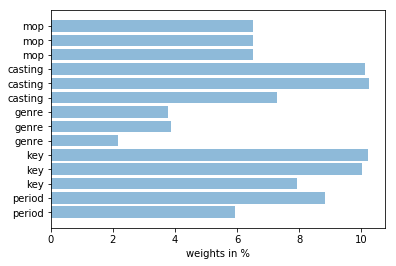

ERR: 0.05014491524586114


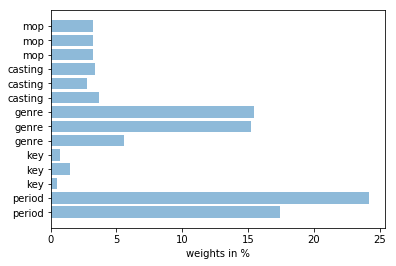

ERR: 0.1315539961488634


ERR: 0.0


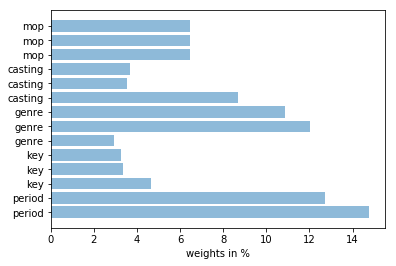

ERR: 0.00024070886634851283


ERR: 0.00017854623623538943


ERR: 0.00010265380129262272


ERR: 0.00026176291452171825


ERR: 0.0516286935282319


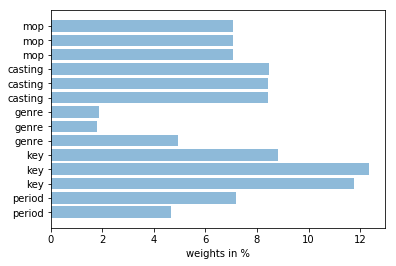

ERR: 4.7506200521176685e-05


ERR: 0.00017564735668189555


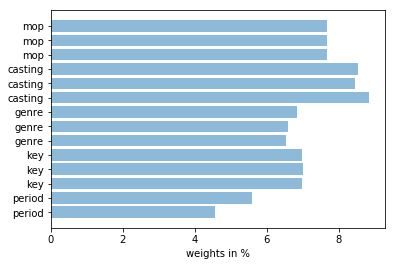

ERR: 5.555614589677945e-05


ERR: 7.44153684460437e-07


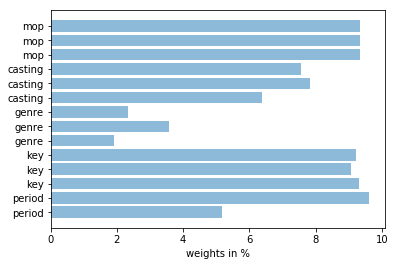

ERR: 4.214804234201419e-05


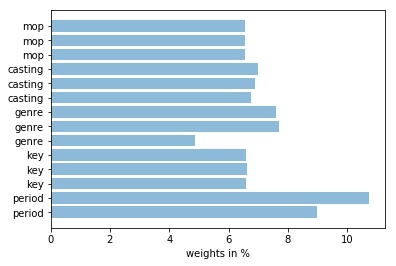

ERR: 3.1467731405299175e-05


ERR: 9.787340069774251e-05


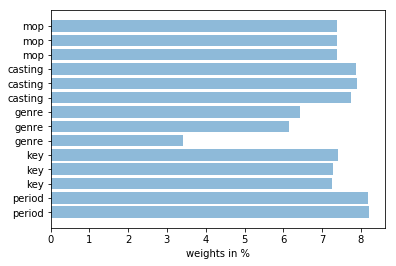

ERR: 0.0068862521750172245


ERR: 0.00011580577994780608


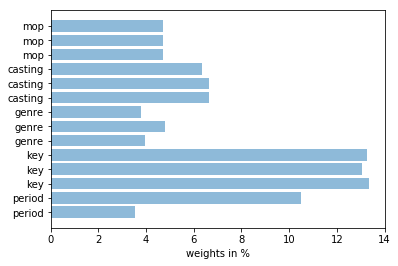

ERR: 1.539850164484447e-05


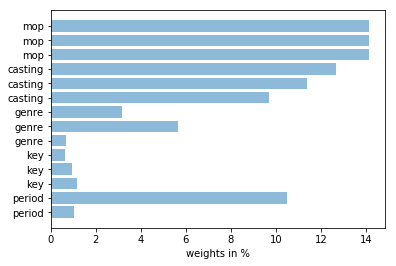

ERR: 0.006540061764633345


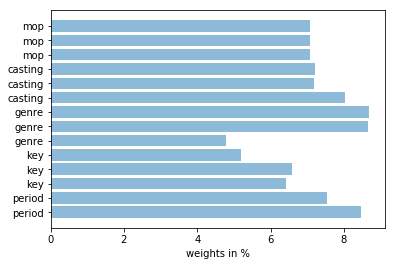

ERR: 0.0454313413814483


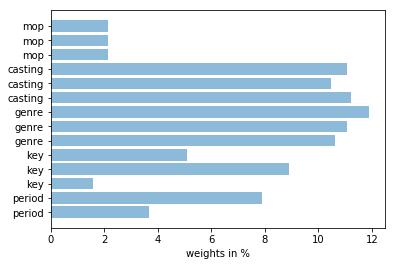

ERR: 0.186750589904523


ERR: 1.0


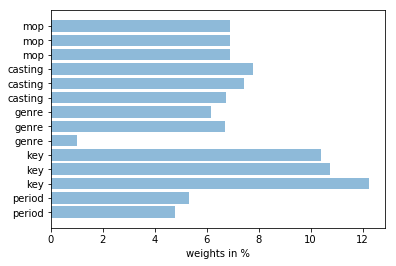

ERR: 0.0


ERR: 1.3387919930106147e-05


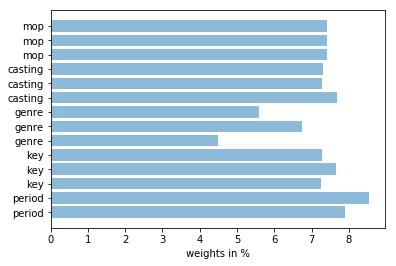

ERR: 0.1872874452756538


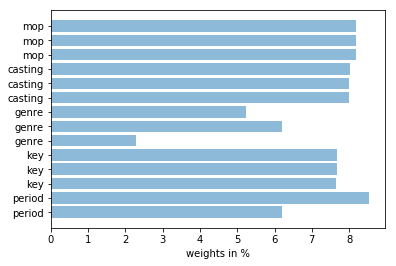

ERR: 0.842680599308962


ERR: 0.18756975691406996


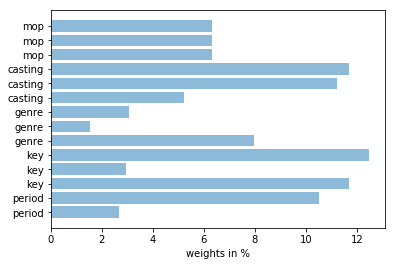

ERR: 0.00015113520734041713


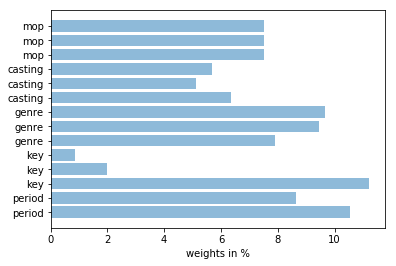

ERR: 0.00042021463436971585


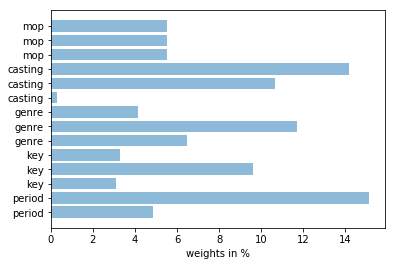

ERR: 0.4150131769830833


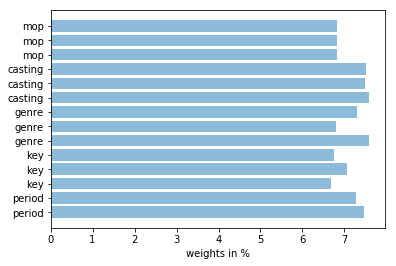

ERR: 9.407341771494161e-05


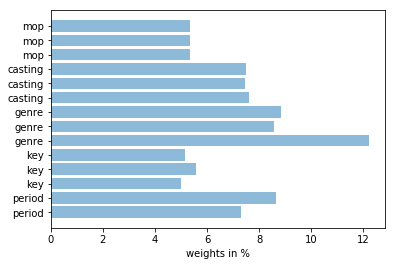

ERR: 0.5973374575860644


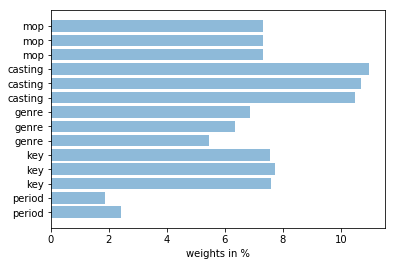

ERR: 0.0002708161109295033


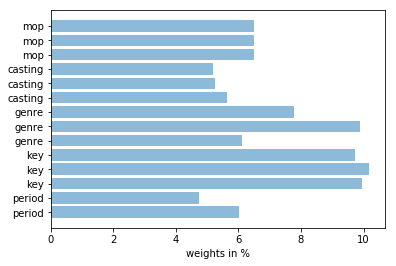

ERR: 0.049845139573479656


ERR: 0.18693430549424472


ERR: 0.32846135553451955


ERR: 0.00010336867112820534


ERR: 0.0002532618402385803


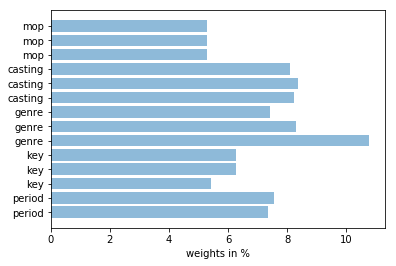

ERR: 0.08394115351049612


ERR: 0.0004255494640957145


ERR: 0.0518976413734045


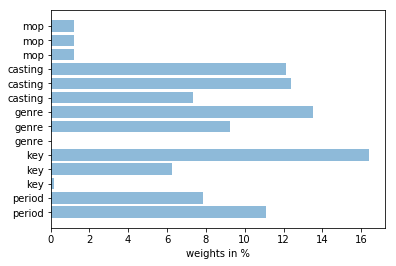

ERR: 0.005564324075856819


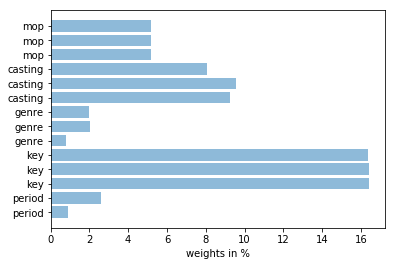

ERR: 7.091172758986112e-05


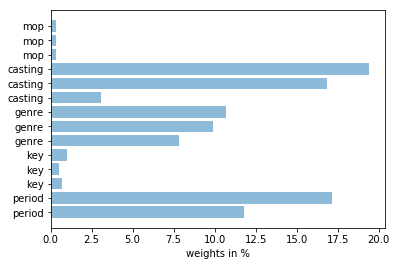

ERR: 2.6165997829787212e-05


ERR: 8.265469747687512e-05


ERR: 0.00025276469443064075


ERR: 7.812547111515785e-05


ERR: 0.0004285699205982416


ERR: 9.445592774114171e-05


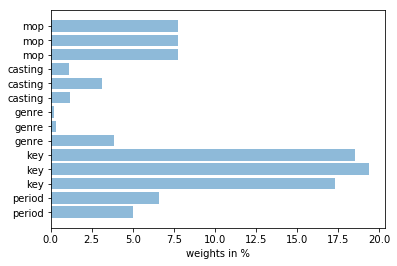

ERR: 0.04843392712683477


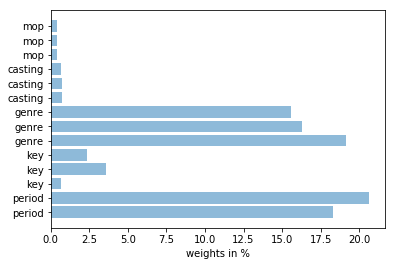

ERR: 0.18953578242952626


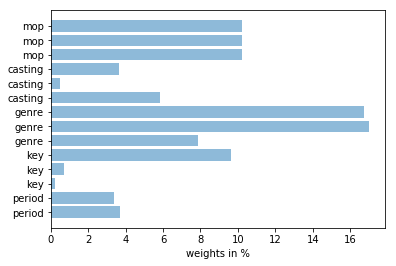

ERR: 0.00019465266259259336


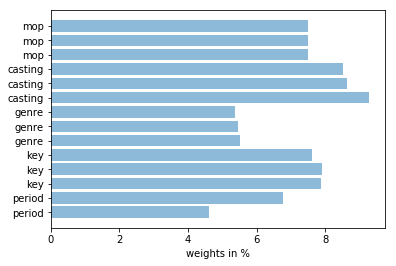

ERR: 0.00011634401616477016


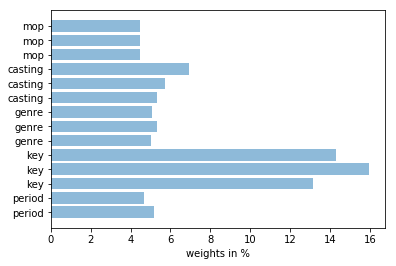

ERR: 0.0001415275305293511


In [1098]:
w = reset_weights()
# print(w)

for step in np.arange(0, num_steps):
#     print('--')
    v, l = next_batch(batch_size, train_vector, train_label)
    pred, mask = compute_similarity_split(v, w)
    diff = pred - l
    error = (diff ** 2).mean()
    
    if step % display_step == 0 or step == 1:
        print("ERR: " + str(error))
        print_weights(w)
#     print("GT: " + str(l[0][0]))
#     print(pred)

    if error == 0:
        continue
    
    w -= l_rate(mask) * dE_dW(v, w, pred, l, mask)
#     print("ERR: " + str(error))

#     print(dE_dW(v, w, pred, l, mask))
    w = positive_norm(w + 10 ** -40)
#     print_weights(w)
#     pred, mask = compute_similarity_split(v, w)
#     print(pred)
#     diff = pred - l
#     error = (diff ** 2).mean()
#     print("ERR: " + str(error))


# np.set_printoptions(precision=3)
# print(w[0][-1])
# print_weights(w)

In [1066]:
def print_results(label, a, b,):
    a = a.reshape((1, emb_size))
    b = b.reshape((1, emb_size))
    print(label + "\t{:.4f}".format(compute_similarity(a, b, w)[0][0]) + " |  " +
          "{:.4f}".format(compute_similarity(a, b, np.ones_like(w))[0][0]))

In [1069]:
verdi = get_embs('http://data.doremus.org/artist/b82c0771-5280-39af-ad2e-8ace2f4ebda3')
rossini = get_embs('http://data.doremus.org/artist/c5d5735c-1095-3ed4-a20f-1208ab9567f9')
rossini_pp = get_embs('http://data.doremus.org/artist/32c2b0ff-35f1-3e65-b0ca-34aaf35f3d50')
beethoven = get_embs('http://data.doremus.org/artist/6963af5e-b126-3d40-a84b-97e0b78f5452')
mozart = get_embs('http://data.doremus.org/artist/4802a043-23bb-3b8d-a443-4a3bd22ccc63')
ravel = get_embs('http://data.doremus.org/artist/1b1205f9-b99a-3bb8-ba77-256689af2e00')
gershwin = get_embs('http://data.doremus.org/artist/5b2ec204-a456-3aa2-8ac7-25305464add8')
coltrane = get_embs('http://data.doremus.org/artist/5425efed-002f-3638-a7b0-ad379a2bf63d')

print("\t\t\t  w    |   ones")
print_results("Verdi vs Verdi: ", verdi, verdi)
print_results("Verdi vs Ravel: ", verdi, ravel)
print_results("Verdi vs Mozart: ", verdi, mozart)
print_results("Verdi vs Gershwin: ", verdi, gershwin)
print_results("Verdi vs Rossini: ", verdi, rossini)
print_results("Verdi vs Beethoven: ", verdi, beethoven)
print_results("Verdi vs Rossini (pp): ", verdi, rossini_pp)
print_results("Verdi vs Coltrane: ", verdi, coltrane)
print('__')
print_results("Beethoven vs Mozart: ", beethoven, mozart)
print_results("Rossini vs Verdi: ", rossini, verdi)



			  w    |   ones
Verdi vs Verdi: 	1.0000 |  1.0000
Verdi vs Ravel: 	0.9939 |  0.9764
Verdi vs Mozart: 	0.9936 |  0.9737
Verdi vs Gershwin: 	0.9927 |  0.9724
Verdi vs Rossini: 	0.9925 |  0.9657
Verdi vs Beethoven: 	0.9918 |  0.9607
Verdi vs Rossini (pp): 	0.9836 |  0.9423
Verdi vs Coltrane: 	0.7759 |  0.7484
__
Beethoven vs Mozart: 	0.9953 |  0.9784
Rossini vs Verdi: 	0.9925 |  0.9657


In [1024]:
aida = get_embs('http://data.doremus.org/expression/4a5b26d7-6e75-3850-851f-8da9554b4115')
rigoletto = get_embs('http://data.doremus.org/expression/dc6ea9c6-88fa-3f87-80a2-a3b4fa3c0ad5')
rigoletto_pp = get_embs('http://data.doremus.org/expression/83485101-69c2-3871-8413-8ea13db5267e')
quattro_stagioni = get_embs('http://data.doremus.org/expression/6dd59267-fef0-392d-911f-7abbe676e289')
rhapsody_in_blue = get_embs('http://data.doremus.org/expression/bf957ff7-af9b-3c67-b9f4-3c8b374caaf3')
giant_steps = get_embs('http://data.doremus.org/expression/eecf626b-8996-341d-83d5-216ac70cc2de')

# print(aida)
# print(rhapsody_in_blue)
# aida.shape


print("\t\t\t\t   w   |   ones")
print_results("Aida vs Rigoletto: \t", aida, rigoletto)
print_results("Rigoletto vs Aida: \t", rigoletto, aida)
print_results("Aida vs Rigoletto (pp): ",aida, rigoletto_pp)
print_results("Aida vs Le Quattro Stagioni: ", aida, quattro_stagioni)
print_results("Aida vs Rhapsody in Blue: ", aida, rhapsody_in_blue)
print_results("Aida vs Giant Steps: \t", aida, giant_steps)


				   w   |   ones
Aida vs Rigoletto: 		0.8885 |  0.8475
Rigoletto vs Aida: 		0.9625 |  0.9182
Aida vs Rigoletto (pp): 	0.5894 |  0.4687
Aida vs Le Quattro Stagioni: 	0.7806 |  0.6080
Aida vs Rhapsody in Blue: 	0.7853 |  0.6250
Aida vs Giant Steps: 		0.6779 |  0.5499
